# Autoencoder trained on the preprocessed dataset.
-------------------------------------------------------------------------------------------------------------------
# Technology used: Tensorflow 

### Changes: mostly same as the old one, with a diferent batch size for training along with tensorboard summary inclusion

### Changes over previous: Trying to debug the batch normalization error

### Start with creating some utility cells

In [7]:
# packages used for processing: 
import matplotlib.pyplot as plt # for visualization
import numpy as np

# deep learning framework
import tensorflow as tf

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '..'])

LICENSE
Models
network_architecture
processed_words_binary_data
README.md
readme.txt
readme.txt~
Scripts
svc2004
task_log
thresh_wordnet_english_test.py
thresh_wordnet_english_test.py~
words_binary



In [4]:
# ''' Set the constants for the script '''

# various paths of the files
data_path = "../words_binary" # the data path
base_model_path = "../Models"
processed_data_path = "../processed_words_binary_data"
log_dir = os.path.join(base_model_path, "logdir")

# constants for the preprocessing script
data_size = (96, 192, 3)
batch_size = 5000 # 10000 images in each batch
no_of_epochs = 200 # run the training loop for 200 epochs
no_of_batches = 10 # There are 10 batches of data
checkpoint_factor = 2 # save the model after every 2 epochs

In [5]:
# load a batch and check a few images from it
batch_path = os.path.join(processed_data_path, "batch_1")
sanity_test_batch = np.load(batch_path)

In [6]:
sanity_test_batch.shape

(5000, 96, 192, 3)

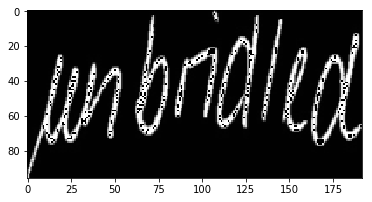

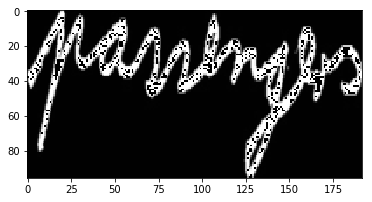

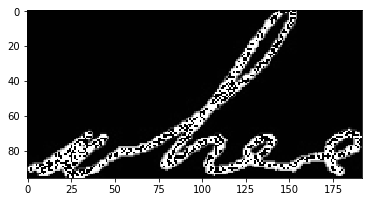

In [8]:
# display a few random images from the dataset:
for _ in range(3):
    random_index = np.random.randint(sanity_test_batch.shape[0])
    plt.figure()
    plt.imshow(sanity_test_batch[random_index])

# In the following cell, I define the computation graph for the network architecture that has been proposed for this task

There is a lot of code written in a single cell, so take a step by step approach towards understanding it

In [9]:
'''
    This cell defines the method required to spawn and return a tensorflow graph for the autoencoder model.
    coded by: Animesh
'''

import tensorflow as tf


myGraph = tf.Graph() #create a new graph object

with myGraph.as_default():
    # define the computations of this graph here:
    
    # helper functions to run the model:
    def normalize(ip_tensor, name = "normalization"):
        '''
            function to normalize the input tensor in the range of [-1, 1] 
            @param
            ip_tensor => the tensor to be normalized
            @return => the normalized version of the tensor
        '''
        with tf.name_scope(name): 
            ip_range = tf.reduce_max(ip_tensor) - tf.reduce_min(ip_tensor)
            mean = tf.reduce_mean(ip_tensor)
            return (ip_tensor - mean) / ip_range
    
    

    # placeholder for the input data batch
    inputs = tf.placeholder(dtype= tf.float32, 
                            shape=(None, data_size[0], data_size[1], data_size[2]), name="inputs")
    
    # normalized inputs to the range of [-1, 1]
    normalized_inputs = normalize(inputs, name="input_normalization")
    
    # create a summary node for some of the inputs
    inputs_summary = tf.summary.image("Input", normalized_inputs[:8])
    # visualize only first 8 images from the batch

    
    # We feed the original inputs to the convNet as shown below:
    # encoder layers: 96 x 192
    conv1_1 = tf.layers.conv2d(inputs, 32, [7, 7], strides=(2, 2), 
                            padding="SAME", name="conv_layer1_1")
    
    bn1_1 = tf.contrib.layers.batch_norm(conv1_1)
    
    # record histogram summary:
    bn1_1_summary = tf.summary.histogram("bn1_1_summary", bn1_1)
    
    relu1_1 = tf.nn.relu(bn1_1, name="relu1_1")
    
    # 48 x 96
    conv1_2 = tf.layers.conv2d(relu1_1, 32, [5, 5], strides=(2, 2),
                            padding="SAME", name="conv_layer1_2")
    
    bn1_2 = tf.contrib.layers.batch_norm(conv1_2)
    
    relu1_2 = tf.nn.relu(bn1_2, name="relu1_2")
    
    # 24 x 48
    conv1_3 = tf.layers.conv2d(relu1_2, 32, [5, 5], strides=(2, 2),
                            padding="SAME", name="conv_layer1_3")
    
    bn1_3 = tf.contrib.layers.batch_norm(conv1_3)
    
    relu1_3 = tf.nn.relu(bn1_3, name="relu1_3")
    
    # 12 x 24
    conv1_4 = tf.layers.conv2d(relu1_3, 16, [3, 3], strides=(2, 2), 
                            padding="SAME", name="conv_layer1_4")

    bn1_4 = tf.contrib.layers.batch_norm(conv1_4)
    
    # record histogram summary:
    bn1_4_summary = tf.summary.histogram("bn1_4_summary", bn1_4)
    
    relu1_4 = tf.nn.relu(bn1_4, name="relu1_4")
    
    # 6 x 12
    
    
    # decoder layers:
    # 6 x 12
    deconv1_1 = tf.layers.conv2d_transpose(relu1_4, 32, [4, 4], strides=(2, 2), 
                                           padding="SAME", name="deconv_layer_1")
    
    deBn1_1 = tf.contrib.layers.batch_norm(deconv1_1)
    # record summary to see the values
    deBn1_1_summary = tf.summary.histogram("deBn1_1_summary", deBn1_1)
    
    deRelu1_1 = tf.nn.relu(deBn1_1, name="de_relu1_1")
    
    # 12 x 24
    deconv1_2 = tf.layers.conv2d_transpose(deRelu1_1, 32, [4, 4], strides=(2, 2), 
                                           padding="SAME", name="deconv_layer_2")
    
    deBn1_2 = tf.contrib.layers.batch_norm(deconv1_2)
    
    deRelu1_2 = tf.nn.relu(deBn1_2, name="de_relu1_2")
    
    # 24 x 48
    deconv1_3 = tf.layers.conv2d_transpose(deRelu1_2, 32, [4, 4], strides=(2, 2), 
                                           padding="SAME", name="deconv_layer_3")
    
    deBn1_3 = tf.contrib.layers.batch_norm(deconv1_3)
    
    deRelu1_3 = tf.nn.relu(deBn1_3, name="de_relu1_3")
    
    # 48 x 96
    deconv1_4 = tf.layers.conv2d_transpose(deRelu1_3, 32, [4, 4], strides=(2, 2),
                                           padding="SAME", name="deconv_layer_4")
    
    deBn1_4 = tf.contrib.layers.batch_norm(deconv1_4)
    
    # record the histogram summary:
    deBn1_4_summary = tf.summary.histogram("deBn1_4_summary", deBn1_4)
    
    deRelu1_4 = tf.nn.relu(deBn1_4, name="de_relu1_4")

    # 96 x 192
    deconv1_5 = tf.layers.conv2d_transpose(deRelu1_4, 3, [3, 3], strides=(1, 1),
                                           padding="SAME", name="deconv_layer_5")
    
    # normalize the predictions i.e deconv1_5 as mentioned above. and then use it for calculating the loss
    normalized_outputs = normalize(deconv1_5, name="output_normalization")
    
    # summary for the output image.
    output_image_summary = tf.summary.image("Output", normalized_outputs[:8]) # record corresponding outputs 
    # for the images.
    
    output = relu1_4 # get a hook on to the latent representation of the encoder
    
    # also generate the summary of the latent representations.
    output_summary = tf.summary.histogram("Latent_Representation", output)

    y_pred = normalized_outputs # output of the decoder
    y_true = normalized_inputs # input at the beginning

    # define the loss for this model:
    # calculate the loss and optimize the network
    loss = tf.norm(y_pred - y_true, ord="euclidean", name="eucledian_loss") # claculate the euclidean loss.
    
    # add a summary op for loss.
    loss_summary = tf.summary.scalar("Loss", loss)

    # using Adam optimizer for optimization
    train_op = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.9, beta2=0.999).minimize(loss, name="train_op")
    
    # single op to generate all the summary data
    all_summaries = tf.summary.merge_all()

In [10]:
itera = 1
model_name = "Model3"

In [11]:
# generate a graph of the above model and visualize it.
log_path = os.path.join(log_dir, model_name)
tensorboard_writer = tf.summary.FileWriter(log_path, graph=myGraph)

In [ ]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is SVC2004, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
'''

with tf.Session(graph=myGraph) as sess:
    
    # the path where the model will be saved 
    ''' Currently using the Model no. 3 '''
    model_path = os.path.join(base_model_path, model_name)
    
    # The saver object for saving and loading the model
    saver = tf.train.Saver(max_to_keep=2)
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        # load the weights from the model
        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
        
    else:
        
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    for ep in range(46, itera * no_of_epochs):  # start the loop 
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            # log a comment related to the current batch:
            print "current_batch: " + str(batch_n + 1)
            
            # generate the batch images and labels
            batch_images = np.load(os.path.join(processed_data_path, "batch_" + str(batch_n + 1)))
            
            min_batch_size = 64 # we look at only 64 images in a single batch
            
            for index in range(int(float(len(batch_images)) / min_batch_size + 0.5)):
                start = index * min_batch_size
                end = start + min_batch_size
                _, cost = sess.run([train_op, loss], feed_dict={inputs: batch_images[start: end]})
                print('range:{} loss= {}'.format((start, start + len(batch_images[start:end])), cost))
                    
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0):
            # run the summary op also
            summary = sess.run(all_summaries, feed_dict={inputs: batch_images[start: end]})

            # add the generated summary to the fileWriter
            tensorboard_writer.add_summary(summary, (ep + 1))
            
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, model_name), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

INFO:tensorflow:Restoring parameters from ../Models/Model3/Model3-46
epoch: 47
current_batch: 1
range:(0, 64) loss= 112.040657043
range:(64, 128) loss= 108.358467102
range:(128, 192) loss= 107.17276001
range:(192, 256) loss= 103.152641296
range:(256, 320) loss= 109.311073303
range:(320, 384) loss= 106.278808594
range:(384, 448) loss= 109.194221497
range:(448, 512) loss= 106.321212769
range:(512, 576) loss= 110.920547485
range:(576, 640) loss= 114.141082764
range:(640, 704) loss= 102.556442261
range:(704, 768) loss= 105.501876831
range:(768, 832) loss= 110.785575867
range:(832, 896) loss= 108.102615356
range:(896, 960) loss= 108.69834137
range:(960, 1024) loss= 107.138671875
range:(1024, 1088) loss= 106.007362366
range:(1088, 1152) loss= 105.998161316
range:(1152, 1216) loss= 115.026161194
range:(1216, 1280) loss= 112.568649292
range:(1280, 1344) loss= 106.402671814
range:(1344, 1408) loss= 109.899795532
range:(1408, 1472) loss= 104.979370117
range:(1472, 1536) loss= 109.62146759
range:

range:(2880, 2944) loss= 112.731712341
range:(2944, 3008) loss= 104.912452698
range:(3008, 3072) loss= 112.87512207
range:(3072, 3136) loss= 107.465270996
range:(3136, 3200) loss= 107.204040527
range:(3200, 3264) loss= 105.043144226
range:(3264, 3328) loss= 107.002120972
range:(3328, 3392) loss= 105.412757874
range:(3392, 3456) loss= 107.258270264
range:(3456, 3520) loss= 106.124252319
range:(3520, 3584) loss= 115.070022583
range:(3584, 3648) loss= 104.53591156
range:(3648, 3712) loss= 110.425094604
range:(3712, 3776) loss= 109.63986969
range:(3776, 3840) loss= 106.599777222
range:(3840, 3904) loss= 108.549545288
range:(3904, 3968) loss= 108.658180237
range:(3968, 4032) loss= 107.900352478
range:(4032, 4096) loss= 111.453125
range:(4096, 4160) loss= 107.502250671
range:(4160, 4224) loss= 107.874641418
range:(4224, 4288) loss= 107.033454895
range:(4288, 4352) loss= 108.67464447
range:(4352, 4416) loss= 103.082588196
range:(4416, 4480) loss= 103.145591736
range:(4480, 4544) loss= 107.576

range:(1024, 1088) loss= 105.05544281
range:(1088, 1152) loss= 111.559890747
range:(1152, 1216) loss= 107.627540588
range:(1216, 1280) loss= 105.518356323
range:(1280, 1344) loss= 114.039009094
range:(1344, 1408) loss= 106.456680298
range:(1408, 1472) loss= 109.480918884
range:(1472, 1536) loss= 106.16104126
range:(1536, 1600) loss= 104.249313354
range:(1600, 1664) loss= 109.168060303
range:(1664, 1728) loss= 111.557258606
range:(1728, 1792) loss= 113.204956055
range:(1792, 1856) loss= 106.810279846
range:(1856, 1920) loss= 108.697097778
range:(1920, 1984) loss= 108.828544617
range:(1984, 2048) loss= 110.390090942
range:(2048, 2112) loss= 111.010314941
range:(2112, 2176) loss= 107.031776428
range:(2176, 2240) loss= 106.290565491
range:(2240, 2304) loss= 112.026679993
range:(2304, 2368) loss= 110.735771179
range:(2368, 2432) loss= 114.651435852
range:(2432, 2496) loss= 106.876159668
range:(2496, 2560) loss= 104.663566589
range:(2560, 2624) loss= 109.472801208
range:(2624, 2688) loss= 10

range:(4288, 4352) loss= 110.296401978
range:(4352, 4416) loss= 109.167686462
range:(4416, 4480) loss= 110.810874939
range:(4480, 4544) loss= 104.906616211
range:(4544, 4608) loss= 107.156921387
range:(4608, 4672) loss= 109.494911194
range:(4672, 4736) loss= 107.509971619
range:(4736, 4800) loss= 107.55493927
range:(4800, 4864) loss= 106.141082764
range:(4864, 4928) loss= 102.412635803
range:(4928, 4992) loss= 108.734069824


current_batch: 9
range:(0, 64) loss= 108.385765076
range:(64, 128) loss= 106.534851074
range:(128, 192) loss= 111.400917053
range:(192, 256) loss= 107.325309753
range:(256, 320) loss= 108.251335144
range:(320, 384) loss= 107.651519775
range:(384, 448) loss= 109.612686157
range:(448, 512) loss= 106.738502502
range:(512, 576) loss= 107.964782715
range:(576, 640) loss= 112.299667358
range:(640, 704) loss= 119.752883911
range:(704, 768) loss= 104.22000885
range:(768, 832) loss= 110.414375305
range:(832, 896) loss= 104.582191467
range:(896, 960) loss= 109.048522949
ran

range:(3200, 3264) loss= 111.409599304
range:(3264, 3328) loss= 111.582893372
range:(3328, 3392) loss= 106.452934265
range:(3392, 3456) loss= 114.524032593
range:(3456, 3520) loss= 110.010437012
range:(3520, 3584) loss= 107.432785034
range:(3584, 3648) loss= 109.17464447
range:(3648, 3712) loss= 105.764801025
range:(3712, 3776) loss= 108.701751709
range:(3776, 3840) loss= 107.868507385
range:(3840, 3904) loss= 106.576591492
range:(3904, 3968) loss= 111.111862183
range:(3968, 4032) loss= 107.369377136
range:(4032, 4096) loss= 108.909614563
range:(4096, 4160) loss= 105.045021057
range:(4160, 4224) loss= 105.917907715
range:(4224, 4288) loss= 108.245384216
range:(4288, 4352) loss= 112.334793091
range:(4352, 4416) loss= 107.042434692
range:(4416, 4480) loss= 109.046287537
range:(4480, 4544) loss= 108.601242065
range:(4544, 4608) loss= 108.702278137
range:(4608, 4672) loss= 108.888237
range:(4672, 4736) loss= 108.12902832
range:(4736, 4800) loss= 112.036331177
range:(4800, 4864) loss= 114.8

range:(1344, 1408) loss= 107.102531433
range:(1408, 1472) loss= 110.366836548
range:(1472, 1536) loss= 106.754325867
range:(1536, 1600) loss= 113.380462646
range:(1600, 1664) loss= 108.889175415
range:(1664, 1728) loss= 112.357063293
range:(1728, 1792) loss= 103.455215454
range:(1792, 1856) loss= 116.131477356
range:(1856, 1920) loss= 105.70501709
range:(1920, 1984) loss= 116.132019043
range:(1984, 2048) loss= 105.01839447
range:(2048, 2112) loss= 106.022735596
range:(2112, 2176) loss= 107.682220459
range:(2176, 2240) loss= 112.771842957
range:(2240, 2304) loss= 107.002426147
range:(2304, 2368) loss= 111.521026611
range:(2368, 2432) loss= 110.885215759
range:(2432, 2496) loss= 107.27192688
range:(2496, 2560) loss= 104.615516663
range:(2560, 2624) loss= 102.523460388
range:(2624, 2688) loss= 111.888946533
range:(2688, 2752) loss= 108.505020142
range:(2752, 2816) loss= 107.429466248
range:(2816, 2880) loss= 107.785568237
range:(2880, 2944) loss= 106.056892395
range:(2944, 3008) loss= 106

range:(4608, 4672) loss= 104.622261047
range:(4672, 4736) loss= 105.665046692
range:(4736, 4800) loss= 110.357421875
range:(4800, 4864) loss= 109.609870911
range:(4864, 4928) loss= 104.932853699
range:(4928, 4992) loss= 114.137435913


current_batch: 7
range:(0, 64) loss= 106.758529663
range:(64, 128) loss= 108.765411377
range:(128, 192) loss= 104.396209717
range:(192, 256) loss= 109.605705261
range:(256, 320) loss= 108.402397156
range:(320, 384) loss= 114.284080505
range:(384, 448) loss= 110.636161804
range:(448, 512) loss= 107.516052246
range:(512, 576) loss= 109.276100159
range:(576, 640) loss= 105.876609802
range:(640, 704) loss= 109.142623901
range:(704, 768) loss= 104.661407471
range:(768, 832) loss= 108.457054138
range:(832, 896) loss= 108.268669128
range:(896, 960) loss= 105.761405945
range:(960, 1024) loss= 106.293319702
range:(1024, 1088) loss= 109.227142334
range:(1088, 1152) loss= 103.206741333
range:(1152, 1216) loss= 110.549987793
range:(1216, 1280) loss= 107.479278564
ra

range:(2752, 2816) loss= 105.297622681
range:(2816, 2880) loss= 110.673744202
range:(2880, 2944) loss= 110.303085327
range:(2944, 3008) loss= 106.007713318
range:(3008, 3072) loss= 117.960258484
range:(3072, 3136) loss= 109.196052551
range:(3136, 3200) loss= 109.039703369
range:(3200, 3264) loss= 115.843154907
range:(3264, 3328) loss= 108.26247406
range:(3328, 3392) loss= 104.243019104
range:(3392, 3456) loss= 110.890167236
range:(3456, 3520) loss= 108.319137573
range:(3520, 3584) loss= 108.442062378
range:(3584, 3648) loss= 105.124359131
range:(3648, 3712) loss= 109.058799744
range:(3712, 3776) loss= 104.965415955
range:(3776, 3840) loss= 109.706237793
range:(3840, 3904) loss= 112.830543518
range:(3904, 3968) loss= 114.211799622
range:(3968, 4032) loss= 109.029602051
range:(4032, 4096) loss= 122.516197205
range:(4096, 4160) loss= 106.405754089
range:(4160, 4224) loss= 106.531967163
range:(4224, 4288) loss= 107.735267639
range:(4288, 4352) loss= 105.121665955
range:(4352, 4416) loss= 1

range:(1664, 1728) loss= 110.655761719
range:(1728, 1792) loss= 103.884986877
range:(1792, 1856) loss= 105.334411621
range:(1856, 1920) loss= 108.788398743
range:(1920, 1984) loss= 106.308616638
range:(1984, 2048) loss= 113.451225281
range:(2048, 2112) loss= 104.479949951
range:(2112, 2176) loss= 105.068412781
range:(2176, 2240) loss= 106.120231628
range:(2240, 2304) loss= 109.241073608
range:(2304, 2368) loss= 110.034187317
range:(2368, 2432) loss= 108.989959717
range:(2432, 2496) loss= 108.783378601
range:(2496, 2560) loss= 108.79335022
range:(2560, 2624) loss= 109.715835571
range:(2624, 2688) loss= 106.481269836
range:(2688, 2752) loss= 106.557754517
range:(2752, 2816) loss= 105.3384552
range:(2816, 2880) loss= 117.383674622
range:(2880, 2944) loss= 108.078514099
range:(2944, 3008) loss= 107.732887268
range:(3008, 3072) loss= 107.610282898
range:(3072, 3136) loss= 105.497283936
range:(3136, 3200) loss= 104.895095825
range:(3200, 3264) loss= 104.77583313
range:(3264, 3328) loss= 105.

range:(4928, 4992) loss= 110.881896973


current_batch: 5
range:(0, 64) loss= 105.663238525
range:(64, 128) loss= 109.810562134
range:(128, 192) loss= 105.523628235
range:(192, 256) loss= 105.771812439
range:(256, 320) loss= 107.059776306
range:(320, 384) loss= 111.190010071
range:(384, 448) loss= 109.476371765
range:(448, 512) loss= 105.097808838
range:(512, 576) loss= 103.520942688
range:(576, 640) loss= 106.497596741
range:(640, 704) loss= 108.093605042
range:(704, 768) loss= 108.772819519
range:(768, 832) loss= 114.59186554
range:(832, 896) loss= 104.665428162
range:(896, 960) loss= 108.62689209
range:(960, 1024) loss= 100.3695755
range:(1024, 1088) loss= 109.193687439
range:(1088, 1152) loss= 114.115753174
range:(1152, 1216) loss= 113.610229492
range:(1216, 1280) loss= 112.328041077
range:(1280, 1344) loss= 110.114845276
range:(1344, 1408) loss= 108.658843994
range:(1408, 1472) loss= 104.309333801
range:(1472, 1536) loss= 111.92440033
range:(1536, 1600) loss= 106.39491272
range:(1

range:(3072, 3136) loss= 104.999565125
range:(3136, 3200) loss= 106.639305115
range:(3200, 3264) loss= 108.758155823
range:(3264, 3328) loss= 110.683181763
range:(3328, 3392) loss= 105.487533569
range:(3392, 3456) loss= 111.445274353
range:(3456, 3520) loss= 106.69127655
range:(3520, 3584) loss= 109.74282074
range:(3584, 3648) loss= 110.183731079
range:(3648, 3712) loss= 104.326278687
range:(3712, 3776) loss= 113.242828369
range:(3776, 3840) loss= 108.880592346
range:(3840, 3904) loss= 105.773750305
range:(3904, 3968) loss= 108.793952942
range:(3968, 4032) loss= 106.850822449
range:(4032, 4096) loss= 110.177558899
range:(4096, 4160) loss= 106.404220581
range:(4160, 4224) loss= 107.571083069
range:(4224, 4288) loss= 103.299468994
range:(4288, 4352) loss= 106.860321045
range:(4352, 4416) loss= 110.233703613
range:(4416, 4480) loss= 102.986801147
range:(4480, 4544) loss= 119.475585938
range:(4544, 4608) loss= 115.808059692
range:(4608, 4672) loss= 104.039131165
range:(4672, 4736) loss= 10

range:(1216, 1280) loss= 104.968063354
range:(1280, 1344) loss= 106.367950439
range:(1344, 1408) loss= 108.219459534
range:(1408, 1472) loss= 103.924278259
range:(1472, 1536) loss= 108.316429138
range:(1536, 1600) loss= 111.124351501
range:(1600, 1664) loss= 107.567985535
range:(1664, 1728) loss= 111.735588074
range:(1728, 1792) loss= 107.729858398
range:(1792, 1856) loss= 109.848999023
range:(1856, 1920) loss= 106.509590149
range:(1920, 1984) loss= 106.529350281
range:(1984, 2048) loss= 104.314819336
range:(2048, 2112) loss= 111.109718323
range:(2112, 2176) loss= 110.033782959
range:(2176, 2240) loss= 106.266983032
range:(2240, 2304) loss= 107.461151123
range:(2304, 2368) loss= 105.353141785
range:(2368, 2432) loss= 112.500526428
range:(2432, 2496) loss= 109.709388733
range:(2496, 2560) loss= 103.882987976
range:(2560, 2624) loss= 105.928329468
range:(2624, 2688) loss= 112.132621765
range:(2688, 2752) loss= 105.108512878
range:(2752, 2816) loss= 102.920799255
range:(2816, 2880) loss= 

range:(64, 128) loss= 107.277664185
range:(128, 192) loss= 110.63445282
range:(192, 256) loss= 114.457275391
range:(256, 320) loss= 106.801429749
range:(320, 384) loss= 104.140846252
range:(384, 448) loss= 106.277862549
range:(448, 512) loss= 107.156997681
range:(512, 576) loss= 107.149436951
range:(576, 640) loss= 106.854263306
range:(640, 704) loss= 110.04750061
range:(704, 768) loss= 107.886474609
range:(768, 832) loss= 105.145706177
range:(832, 896) loss= 105.321395874
range:(896, 960) loss= 107.349365234
range:(960, 1024) loss= 107.106361389
range:(1024, 1088) loss= 106.270210266
range:(1088, 1152) loss= 103.96799469
range:(1152, 1216) loss= 105.003036499
range:(1216, 1280) loss= 104.744613647
range:(1280, 1344) loss= 103.4087677
range:(1344, 1408) loss= 106.584434509
range:(1408, 1472) loss= 102.666526794
range:(1472, 1536) loss= 102.261047363
range:(1536, 1600) loss= 106.176292419
range:(1600, 1664) loss= 106.994590759
range:(1664, 1728) loss= 103.795379639
range:(1728, 1792) lo

range:(3392, 3456) loss= 106.633483887
range:(3456, 3520) loss= 115.316947937
range:(3520, 3584) loss= 111.383674622
range:(3584, 3648) loss= 108.967308044
range:(3648, 3712) loss= 111.604148865
range:(3712, 3776) loss= 103.967933655
range:(3776, 3840) loss= 104.099769592
range:(3840, 3904) loss= 105.665847778
range:(3904, 3968) loss= 108.952140808
range:(3968, 4032) loss= 107.781898499
range:(4032, 4096) loss= 107.348869324
range:(4096, 4160) loss= 104.377113342
range:(4160, 4224) loss= 108.58228302
range:(4224, 4288) loss= 108.821868896
range:(4288, 4352) loss= 108.934944153
range:(4352, 4416) loss= 101.968742371
range:(4416, 4480) loss= 101.206451416
range:(4480, 4544) loss= 105.697906494
range:(4544, 4608) loss= 103.93132019
range:(4608, 4672) loss= 105.797302246
range:(4672, 4736) loss= 104.384513855
range:(4736, 4800) loss= 106.356430054
range:(4800, 4864) loss= 105.009529114
range:(4864, 4928) loss= 104.764122009
range:(4928, 4992) loss= 104.271011353


current_batch: 6
range:(0

range:(1600, 1664) loss= 107.956672668
range:(1664, 1728) loss= 117.005844116
range:(1728, 1792) loss= 108.190414429
range:(1792, 1856) loss= 105.225830078
range:(1856, 1920) loss= 105.587158203
range:(1920, 1984) loss= 105.209701538
range:(1984, 2048) loss= 107.834236145
range:(2048, 2112) loss= 107.769737244
range:(2112, 2176) loss= 103.161010742
range:(2176, 2240) loss= 105.737335205
range:(2240, 2304) loss= 108.295974731
range:(2304, 2368) loss= 112.061569214
range:(2368, 2432) loss= 104.586418152
range:(2432, 2496) loss= 100.853424072
range:(2496, 2560) loss= 106.297554016
range:(2560, 2624) loss= 107.645133972
range:(2624, 2688) loss= 112.989250183
range:(2688, 2752) loss= 107.328384399
range:(2752, 2816) loss= 106.240524292
range:(2816, 2880) loss= 102.015098572
range:(2880, 2944) loss= 104.722648621
range:(2944, 3008) loss= 106.893913269
range:(3008, 3072) loss= 106.801574707
range:(3072, 3136) loss= 107.843406677
range:(3136, 3200) loss= 102.476478577
range:(3200, 3264) loss= 

range:(512, 576) loss= 109.84198761
range:(576, 640) loss= 112.887336731
range:(640, 704) loss= 101.659614563
range:(704, 768) loss= 104.926399231
range:(768, 832) loss= 110.189315796
range:(832, 896) loss= 107.40486908
range:(896, 960) loss= 107.448104858
range:(960, 1024) loss= 105.808898926
range:(1024, 1088) loss= 104.761566162
range:(1088, 1152) loss= 104.988777161
range:(1152, 1216) loss= 113.272247314
range:(1216, 1280) loss= 111.375274658
range:(1280, 1344) loss= 105.126953125
range:(1344, 1408) loss= 108.780525208
range:(1408, 1472) loss= 104.016662598
range:(1472, 1536) loss= 108.668838501
range:(1536, 1600) loss= 102.890869141
range:(1600, 1664) loss= 111.382293701
range:(1664, 1728) loss= 108.923576355
range:(1728, 1792) loss= 109.585121155
range:(1792, 1856) loss= 107.331687927
range:(1856, 1920) loss= 108.087020874
range:(1920, 1984) loss= 104.673568726
range:(1984, 2048) loss= 107.48903656
range:(2048, 2112) loss= 106.645462036
range:(2112, 2176) loss= 109.773414612
rang

range:(3840, 3904) loss= 106.92880249
range:(3904, 3968) loss= 106.60849762
range:(3968, 4032) loss= 106.489547729
range:(4032, 4096) loss= 110.552490234
range:(4096, 4160) loss= 105.934745789
range:(4160, 4224) loss= 106.265708923
range:(4224, 4288) loss= 105.429260254
range:(4288, 4352) loss= 106.749351501
range:(4352, 4416) loss= 101.420524597
range:(4416, 4480) loss= 101.89414978
range:(4480, 4544) loss= 106.357704163
range:(4544, 4608) loss= 110.31602478
range:(4608, 4672) loss= 107.978317261
range:(4672, 4736) loss= 107.548431396
range:(4736, 4800) loss= 104.773628235
range:(4800, 4864) loss= 107.530487061
range:(4864, 4928) loss= 112.164703369
range:(4928, 4992) loss= 105.182594299


current_batch: 4
range:(0, 64) loss= 107.518623352
range:(64, 128) loss= 104.123809814
range:(128, 192) loss= 104.699226379
range:(192, 256) loss= 105.829910278
range:(256, 320) loss= 106.619422913
range:(320, 384) loss= 104.860305786
range:(384, 448) loss= 105.874298096
range:(448, 512) loss= 115.6

range:(2048, 2112) loss= 107.792243958
range:(2112, 2176) loss= 104.483665466
range:(2176, 2240) loss= 104.71622467
range:(2240, 2304) loss= 109.088935852
range:(2304, 2368) loss= 108.379020691
range:(2368, 2432) loss= 111.64730835
range:(2432, 2496) loss= 105.0651474
range:(2496, 2560) loss= 102.460647583
range:(2560, 2624) loss= 107.392677307
range:(2624, 2688) loss= 105.606254578
range:(2688, 2752) loss= 106.215713501
range:(2752, 2816) loss= 102.459136963
range:(2816, 2880) loss= 108.034873962
range:(2880, 2944) loss= 105.837219238
range:(2944, 3008) loss= 104.618286133
range:(3008, 3072) loss= 101.104278564
range:(3072, 3136) loss= 113.914642334
range:(3136, 3200) loss= 109.403617859
range:(3200, 3264) loss= 106.119125366
range:(3264, 3328) loss= 108.702339172
range:(3328, 3392) loss= 111.919143677
range:(3392, 3456) loss= 108.340034485
range:(3456, 3520) loss= 108.94519043
range:(3520, 3584) loss= 106.807098389
range:(3584, 3648) loss= 102.696784973
range:(3648, 3712) loss= 114.1

range:(192, 256) loss= 104.552848816
range:(256, 320) loss= 106.484085083
range:(320, 384) loss= 105.637191772
range:(384, 448) loss= 107.844078064
range:(448, 512) loss= 104.850715637
range:(512, 576) loss= 106.059501648
range:(576, 640) loss= 109.912094116
range:(640, 704) loss= 118.252593994
range:(704, 768) loss= 102.209976196
range:(768, 832) loss= 108.920791626
range:(832, 896) loss= 103.372245789
range:(896, 960) loss= 107.055076599
range:(960, 1024) loss= 104.470092773
range:(1024, 1088) loss= 109.357574463
range:(1088, 1152) loss= 105.649482727
range:(1152, 1216) loss= 104.541427612
range:(1216, 1280) loss= 106.135864258
range:(1280, 1344) loss= 103.29107666
range:(1344, 1408) loss= 105.087982178
range:(1408, 1472) loss= 106.100105286
range:(1472, 1536) loss= 105.660079956
range:(1536, 1600) loss= 113.595054626
range:(1600, 1664) loss= 105.864250183
range:(1664, 1728) loss= 109.332809448
range:(1728, 1792) loss= 110.077407837
range:(1792, 1856) loss= 105.083015442
range:(1856,

range:(4288, 4352) loss= 110.777183533
range:(4352, 4416) loss= 105.167427063
range:(4416, 4480) loss= 106.560302734
range:(4480, 4544) loss= 107.031745911
range:(4544, 4608) loss= 107.144897461
range:(4608, 4672) loss= 107.341636658
range:(4672, 4736) loss= 105.967262268
range:(4736, 4800) loss= 110.514549255
range:(4800, 4864) loss= 113.289657593
range:(4864, 4928) loss= 104.739677429
range:(4928, 4992) loss= 110.55316925


current_batch: 2
range:(0, 64) loss= 102.516326904
range:(64, 128) loss= 105.394485474
range:(128, 192) loss= 105.936271667
range:(192, 256) loss= 108.568519592
range:(256, 320) loss= 108.548171997
range:(320, 384) loss= 107.959251404
range:(384, 448) loss= 107.228302002
range:(448, 512) loss= 109.135261536
range:(512, 576) loss= 109.009117126
range:(576, 640) loss= 106.691818237
range:(640, 704) loss= 111.63432312
range:(704, 768) loss= 110.527030945
range:(768, 832) loss= 107.370559692
range:(832, 896) loss= 104.974403381
range:(896, 960) loss= 106.141288757
ran

range:(2496, 2560) loss= 103.897506714
range:(2560, 2624) loss= 101.725952148
range:(2624, 2688) loss= 111.233192444
range:(2688, 2752) loss= 108.149864197
range:(2752, 2816) loss= 106.667984009
range:(2816, 2880) loss= 106.681251526
range:(2880, 2944) loss= 105.731933594
range:(2944, 3008) loss= 105.230232239
range:(3008, 3072) loss= 106.067749023
range:(3072, 3136) loss= 105.767333984
range:(3136, 3200) loss= 108.031486511
range:(3200, 3264) loss= 113.411506653
range:(3264, 3328) loss= 110.129623413
range:(3328, 3392) loss= 107.166786194
range:(3392, 3456) loss= 106.255706787
range:(3456, 3520) loss= 107.630126953
range:(3520, 3584) loss= 109.022842407
range:(3584, 3648) loss= 108.654220581
range:(3648, 3712) loss= 106.563316345
range:(3712, 3776) loss= 105.564910889
range:(3776, 3840) loss= 113.278045654
range:(3840, 3904) loss= 105.519889832
range:(3904, 3968) loss= 112.970954895
range:(3968, 4032) loss= 102.78012085
range:(4032, 4096) loss= 105.368240356
range:(4096, 4160) loss= 1

range:(640, 704) loss= 108.305801392
range:(704, 768) loss= 103.84198761
range:(768, 832) loss= 107.090446472
range:(832, 896) loss= 107.207984924
range:(896, 960) loss= 104.338241577
range:(960, 1024) loss= 104.61517334
range:(1024, 1088) loss= 108.034126282
range:(1088, 1152) loss= 101.698059082
range:(1152, 1216) loss= 108.995986938
range:(1216, 1280) loss= 106.880966187
range:(1280, 1344) loss= 106.958770752
range:(1344, 1408) loss= 104.090606689
range:(1408, 1472) loss= 103.718894958
range:(1472, 1536) loss= 107.419700623
range:(1536, 1600) loss= 106.093559265
range:(1600, 1664) loss= 107.432151794
range:(1664, 1728) loss= 104.049598694
range:(1728, 1792) loss= 110.457595825
range:(1792, 1856) loss= 107.240837097
range:(1856, 1920) loss= 110.371429443
range:(1920, 1984) loss= 108.263404846
range:(1984, 2048) loss= 106.712127686
range:(2048, 2112) loss= 105.872688293
range:(2112, 2176) loss= 104.147644043
range:(2176, 2240) loss= 107.658981323
range:(2240, 2304) loss= 106.143943787

range:(3968, 4032) loss= 107.223983765
range:(4032, 4096) loss= 121.108695984
range:(4096, 4160) loss= 104.575843811
range:(4160, 4224) loss= 105.197463989
range:(4224, 4288) loss= 106.660743713
range:(4288, 4352) loss= 103.473258972
range:(4352, 4416) loss= 106.121002197
range:(4416, 4480) loss= 105.698738098
range:(4480, 4544) loss= 101.320755005
range:(4544, 4608) loss= 103.58441925
range:(4608, 4672) loss= 104.837692261
range:(4672, 4736) loss= 105.294136047
range:(4736, 4800) loss= 109.836997986
range:(4800, 4864) loss= 106.491630554
range:(4864, 4928) loss= 105.221008301
range:(4928, 4992) loss= 103.835990906


current_batch: 10
range:(0, 64) loss= 102.742668152
range:(64, 128) loss= 104.702278137
range:(128, 192) loss= 102.979156494
range:(192, 256) loss= 106.781738281
range:(256, 320) loss= 108.995536804
range:(320, 384) loss= 108.647850037
range:(384, 448) loss= 113.798042297
range:(448, 512) loss= 105.573867798
range:(512, 576) loss= 106.553146362
range:(576, 640) loss= 104.0

range:(2880, 2944) loss= 107.169250488
range:(2944, 3008) loss= 106.672546387
range:(3008, 3072) loss= 107.033622742
range:(3072, 3136) loss= 104.237869263
range:(3136, 3200) loss= 104.014709473
range:(3200, 3264) loss= 103.348121643
range:(3264, 3328) loss= 104.417411804
range:(3328, 3392) loss= 107.971244812
range:(3392, 3456) loss= 104.168663025
range:(3456, 3520) loss= 106.00403595
range:(3520, 3584) loss= 109.791610718
range:(3584, 3648) loss= 106.816833496
range:(3648, 3712) loss= 104.837020874
range:(3712, 3776) loss= 109.79309845
range:(3776, 3840) loss= 109.156768799
range:(3840, 3904) loss= 107.597229004
range:(3904, 3968) loss= 104.998832703
range:(3968, 4032) loss= 101.449188232
range:(4032, 4096) loss= 104.782989502
range:(4096, 4160) loss= 104.144264221
range:(4160, 4224) loss= 105.735870361
range:(4224, 4288) loss= 108.0938797
range:(4288, 4352) loss= 110.193191528
range:(4352, 4416) loss= 101.338851929
range:(4416, 4480) loss= 102.563453674
range:(4480, 4544) loss= 110.

range:(1088, 1152) loss= 113.200057983
range:(1152, 1216) loss= 113.17868042
range:(1216, 1280) loss= 111.968475342
range:(1280, 1344) loss= 108.86831665
range:(1344, 1408) loss= 107.368164062
range:(1408, 1472) loss= 103.062149048
range:(1472, 1536) loss= 110.789329529
range:(1536, 1600) loss= 105.416870117
range:(1600, 1664) loss= 108.364898682
range:(1664, 1728) loss= 105.236557007
range:(1728, 1792) loss= 105.396896362
range:(1792, 1856) loss= 104.245033264
range:(1856, 1920) loss= 106.156936646
range:(1920, 1984) loss= 104.279174805
range:(1984, 2048) loss= 113.110939026
range:(2048, 2112) loss= 110.289398193
range:(2112, 2176) loss= 107.371482849
range:(2176, 2240) loss= 107.469566345
range:(2240, 2304) loss= 117.505371094
range:(2304, 2368) loss= 103.719398499
range:(2368, 2432) loss= 113.02759552
range:(2432, 2496) loss= 111.868049622
range:(2496, 2560) loss= 108.337486267
range:(2560, 2624) loss= 107.342086792
range:(2624, 2688) loss= 111.045051575
range:(2688, 2752) loss= 109

range:(4352, 4416) loss= 109.100837708
range:(4416, 4480) loss= 102.258636475
range:(4480, 4544) loss= 118.283699036
range:(4544, 4608) loss= 114.55443573
range:(4608, 4672) loss= 102.824150085
range:(4672, 4736) loss= 105.770477295
range:(4736, 4800) loss= 108.657081604
range:(4800, 4864) loss= 109.339019775
range:(4864, 4928) loss= 103.755905151
range:(4928, 4992) loss= 108.452964783


current_batch: 8
range:(0, 64) loss= 103.225028992
range:(64, 128) loss= 103.854988098
range:(128, 192) loss= 106.621170044
range:(192, 256) loss= 105.06879425
range:(256, 320) loss= 101.103530884
range:(320, 384) loss= 104.644378662
range:(384, 448) loss= 107.63735199
range:(448, 512) loss= 106.274085999
range:(512, 576) loss= 103.968032837
range:(576, 640) loss= 103.095230103
range:(640, 704) loss= 114.172271729
range:(704, 768) loss= 105.305335999
range:(768, 832) loss= 111.4871521
range:(832, 896) loss= 106.256317139
range:(896, 960) loss= 104.182884216
range:(960, 1024) loss= 108.061981201
range:(

range:(2560, 2624) loss= 104.244049072
range:(2624, 2688) loss= 110.727859497
range:(2688, 2752) loss= 103.891990662
range:(2752, 2816) loss= 101.770393372
range:(2816, 2880) loss= 106.132095337
range:(2880, 2944) loss= 104.445960999
range:(2944, 3008) loss= 107.755767822
range:(3008, 3072) loss= 110.735282898
range:(3072, 3136) loss= 108.307479858
range:(3136, 3200) loss= 108.327445984
range:(3200, 3264) loss= 108.148391724
range:(3264, 3328) loss= 106.263755798
range:(3328, 3392) loss= 111.28338623
range:(3392, 3456) loss= 107.498100281
range:(3456, 3520) loss= 108.904327393
range:(3520, 3584) loss= 108.669410706
range:(3584, 3648) loss= 102.347106934
range:(3648, 3712) loss= 102.835792542
range:(3712, 3776) loss= 105.695320129
range:(3776, 3840) loss= 113.925460815
range:(3840, 3904) loss= 101.278701782


epoch: 54
current_batch: 1
range:(0, 64) loss= 109.045631409
range:(64, 128) loss= 106.098327637
range:(128, 192) loss= 105.097045898
range:(192, 256) loss= 100.993606567
range:(25

range:(1472, 1536) loss= 101.894325256
range:(1536, 1600) loss= 105.519393921
range:(1600, 1664) loss= 106.454231262
range:(1664, 1728) loss= 103.49634552
range:(1728, 1792) loss= 107.405693054
range:(1792, 1856) loss= 105.350296021
range:(1856, 1920) loss= 107.070091248
range:(1920, 1984) loss= 105.3724823
range:(1984, 2048) loss= 106.886749268
range:(2048, 2112) loss= 108.162216187
range:(2112, 2176) loss= 110.173995972
range:(2176, 2240) loss= 104.272880554
range:(2240, 2304) loss= 107.939002991
range:(2304, 2368) loss= 107.879386902
range:(2368, 2432) loss= 110.846984863
range:(2432, 2496) loss= 108.335571289
range:(2496, 2560) loss= 105.653274536
range:(2560, 2624) loss= 102.478340149
range:(2624, 2688) loss= 108.969718933
range:(2688, 2752) loss= 109.840408325
range:(2752, 2816) loss= 107.076049805
range:(2816, 2880) loss= 103.284996033
range:(2880, 2944) loss= 110.655677795
range:(2944, 3008) loss= 102.146286011
range:(3008, 3072) loss= 109.640838623
range:(3072, 3136) loss= 104

range:(4736, 4800) loss= 105.415985107
range:(4800, 4864) loss= 103.976303101
range:(4864, 4928) loss= 103.502471924
range:(4928, 4992) loss= 102.658195496


current_batch: 6
range:(0, 64) loss= 107.49168396
range:(64, 128) loss= 103.78276825
range:(128, 192) loss= 106.173591614
range:(192, 256) loss= 103.228118896
range:(256, 320) loss= 103.887565613
range:(320, 384) loss= 102.077438354
range:(384, 448) loss= 104.664482117
range:(448, 512) loss= 105.910446167
range:(512, 576) loss= 107.662414551
range:(576, 640) loss= 106.998054504
range:(640, 704) loss= 106.143363953
range:(704, 768) loss= 103.865371704
range:(768, 832) loss= 107.508918762
range:(832, 896) loss= 103.999961853
range:(896, 960) loss= 109.946731567
range:(960, 1024) loss= 111.548446655
range:(1024, 1088) loss= 103.775566101
range:(1088, 1152) loss= 109.376686096
range:(1152, 1216) loss= 105.388877869
range:(1216, 1280) loss= 103.399765015
range:(1280, 1344) loss= 111.700233459
range:(1344, 1408) loss= 105.369743347
rang

range:(2880, 2944) loss= 105.355987549
range:(2944, 3008) loss= 106.946456909
range:(3008, 3072) loss= 106.670181274
range:(3072, 3136) loss= 107.843734741
range:(3136, 3200) loss= 103.007911682
range:(3200, 3264) loss= 108.372817993
range:(3264, 3328) loss= 109.100708008
range:(3328, 3392) loss= 109.910362244
range:(3392, 3456) loss= 110.144012451
range:(3456, 3520) loss= 110.317390442
range:(3520, 3584) loss= 107.758964539
range:(3584, 3648) loss= 105.902839661
range:(3648, 3712) loss= 101.75528717
range:(3712, 3776) loss= 111.422569275
range:(3776, 3840) loss= 104.129165649
range:(3840, 3904) loss= 105.87677002
range:(3904, 3968) loss= 103.492958069
range:(3968, 4032) loss= 103.277206421
range:(4032, 4096) loss= 108.317253113
range:(4096, 4160) loss= 107.986740112
range:(4160, 4224) loss= 107.302070618
range:(4224, 4288) loss= 106.171035767
range:(4288, 4352) loss= 108.372253418
range:(4352, 4416) loss= 107.099884033
range:(4416, 4480) loss= 108.319381714
range:(4480, 4544) loss= 10

range:(1792, 1856) loss= 105.757278442
range:(1856, 1920) loss= 106.837211609
range:(1920, 1984) loss= 104.520774841
range:(1984, 2048) loss= 107.089698792
range:(2048, 2112) loss= 106.098907471
range:(2112, 2176) loss= 108.907905579
range:(2176, 2240) loss= 106.11831665
range:(2240, 2304) loss= 105.395874023
range:(2304, 2368) loss= 106.607185364
range:(2368, 2432) loss= 107.835510254
range:(2432, 2496) loss= 104.756286621
range:(2496, 2560) loss= 103.033950806
range:(2560, 2624) loss= 106.05216217
range:(2624, 2688) loss= 102.229804993
range:(2688, 2752) loss= 102.792373657
range:(2752, 2816) loss= 109.71370697
range:(2816, 2880) loss= 107.001655579
range:(2880, 2944) loss= 105.615318298
range:(2944, 3008) loss= 106.846611023
range:(3008, 3072) loss= 111.822212219
range:(3072, 3136) loss= 110.972305298
range:(3136, 3200) loss= 109.341567993
range:(3200, 3264) loss= 109.020309448
range:(3264, 3328) loss= 108.913467407
range:(3328, 3392) loss= 103.689994812
range:(3392, 3456) loss= 111

range:(0, 64) loss= 107.497703552
range:(64, 128) loss= 103.915077209
range:(128, 192) loss= 104.692192078
range:(192, 256) loss= 105.022842407
range:(256, 320) loss= 106.03225708
range:(320, 384) loss= 104.669151306
range:(384, 448) loss= 104.917449951
range:(448, 512) loss= 115.183189392
range:(512, 576) loss= 109.756797791
range:(576, 640) loss= 105.274276733
range:(640, 704) loss= 109.427062988
range:(704, 768) loss= 101.553497314
range:(768, 832) loss= 103.149185181
range:(832, 896) loss= 105.912620544
range:(896, 960) loss= 107.975540161
range:(960, 1024) loss= 108.927238464
range:(1024, 1088) loss= 105.055168152
range:(1088, 1152) loss= 109.925758362
range:(1152, 1216) loss= 105.257781982
range:(1216, 1280) loss= 107.269287109
range:(1280, 1344) loss= 103.010704041
range:(1344, 1408) loss= 104.660545349
range:(1408, 1472) loss= 108.379142761
range:(1472, 1536) loss= 105.283348083
range:(1536, 1600) loss= 111.392234802
range:(1600, 1664) loss= 107.006378174
range:(1664, 1728) los

range:(3328, 3392) loss= 110.59161377
range:(3392, 3456) loss= 107.463623047
range:(3456, 3520) loss= 108.083854675
range:(3520, 3584) loss= 105.32170105
range:(3584, 3648) loss= 101.179244995
range:(3648, 3712) loss= 112.921714783
range:(3712, 3776) loss= 106.30393219
range:(3776, 3840) loss= 109.712722778
range:(3840, 3904) loss= 104.723106384
range:(3904, 3968) loss= 104.972663879
range:(3968, 4032) loss= 112.77192688
range:(4032, 4096) loss= 109.276390076
range:(4096, 4160) loss= 113.204826355
range:(4160, 4224) loss= 106.907043457
range:(4224, 4288) loss= 104.453536987
range:(4288, 4352) loss= 104.617378235
range:(4352, 4416) loss= 103.851478577
range:(4416, 4480) loss= 100.330047607
range:(4480, 4544) loss= 103.051605225
range:(4544, 4608) loss= 106.647964478
range:(4608, 4672) loss= 101.543617249
range:(4672, 4736) loss= 103.306037903
range:(4736, 4800) loss= 108.266334534
range:(4800, 4864) loss= 107.22857666
range:(4864, 4928) loss= 102.259887695
range:(4928, 4992) loss= 111.5

range:(1536, 1600) loss= 112.497497559
range:(1600, 1664) loss= 104.960914612
range:(1664, 1728) loss= 108.412368774
range:(1728, 1792) loss= 109.097877502
range:(1792, 1856) loss= 103.785209656
range:(1856, 1920) loss= 104.779907227
range:(1920, 1984) loss= 110.756156921
range:(1984, 2048) loss= 112.113761902
range:(2048, 2112) loss= 104.793312073
range:(2112, 2176) loss= 110.66910553
range:(2176, 2240) loss= 108.567909241
range:(2240, 2304) loss= 107.937553406
range:(2304, 2368) loss= 105.224266052
range:(2368, 2432) loss= 103.779571533
range:(2432, 2496) loss= 107.547279358
range:(2496, 2560) loss= 102.322891235
range:(2560, 2624) loss= 108.717086792
range:(2624, 2688) loss= 107.345848083
range:(2688, 2752) loss= 111.655540466
range:(2752, 2816) loss= 102.887969971
range:(2816, 2880) loss= 107.565734863
range:(2880, 2944) loss= 106.998977661
range:(2944, 3008) loss= 102.974357605
range:(3008, 3072) loss= 114.574050903
range:(3072, 3136) loss= 105.838676453
range:(3136, 3200) loss= 1

range:(448, 512) loss= 107.708328247
range:(512, 576) loss= 107.471176147
range:(576, 640) loss= 105.731498718
range:(640, 704) loss= 110.625213623
range:(704, 768) loss= 109.468597412
range:(768, 832) loss= 106.005378723
range:(832, 896) loss= 103.588623047
range:(896, 960) loss= 104.788665771
range:(960, 1024) loss= 106.06048584
range:(1024, 1088) loss= 104.887130737
range:(1088, 1152) loss= 107.259254456
range:(1152, 1216) loss= 106.884185791
range:(1216, 1280) loss= 103.546180725
range:(1280, 1344) loss= 105.850746155
range:(1344, 1408) loss= 108.111976624
range:(1408, 1472) loss= 105.618400574
range:(1472, 1536) loss= 99.4947509766
range:(1536, 1600) loss= 106.407562256
range:(1600, 1664) loss= 105.140838623
range:(1664, 1728) loss= 108.535705566
range:(1728, 1792) loss= 101.896400452
range:(1792, 1856) loss= 103.339736938
range:(1856, 1920) loss= 106.915222168
range:(1920, 1984) loss= 104.011238098
range:(1984, 2048) loss= 111.209655762
range:(2048, 2112) loss= 101.902008057
rang

range:(3776, 3840) loss= 112.126029968
range:(3840, 3904) loss= 104.00415802
range:(3904, 3968) loss= 110.849906921
range:(3968, 4032) loss= 101.065048218
range:(4032, 4096) loss= 104.480049133
range:(4096, 4160) loss= 110.13494873
range:(4160, 4224) loss= 112.277206421
range:(4224, 4288) loss= 111.720588684
range:(4288, 4352) loss= 103.153114319
range:(4352, 4416) loss= 102.51599884
range:(4416, 4480) loss= 101.970184326
range:(4480, 4544) loss= 113.485061646
range:(4544, 4608) loss= 107.931861877
range:(4608, 4672) loss= 104.254837036
range:(4672, 4736) loss= 103.053329468
range:(4736, 4800) loss= 106.300048828
range:(4800, 4864) loss= 104.291282654
range:(4864, 4928) loss= 104.056190491
range:(4928, 4992) loss= 108.493049622


current_batch: 5
range:(0, 64) loss= 103.498100281
range:(64, 128) loss= 107.56905365
range:(128, 192) loss= 103.211845398
range:(192, 256) loss= 103.244537354
range:(256, 320) loss= 105.014152527
range:(320, 384) loss= 108.816490173
range:(384, 448) loss= 107

range:(1920, 1984) loss= 107.361808777
range:(1984, 2048) loss= 105.293418884
range:(2048, 2112) loss= 104.772277832
range:(2112, 2176) loss= 102.998878479
range:(2176, 2240) loss= 106.710884094
range:(2240, 2304) loss= 105.154472351
range:(2304, 2368) loss= 103.848724365
range:(2368, 2432) loss= 101.558326721
range:(2432, 2496) loss= 103.605697632
range:(2496, 2560) loss= 105.187828064
range:(2560, 2624) loss= 106.614837646
range:(2624, 2688) loss= 112.112632751
range:(2688, 2752) loss= 98.3509140015
range:(2752, 2816) loss= 107.768218994
range:(2816, 2880) loss= 104.276260376
range:(2880, 2944) loss= 106.134140015
range:(2944, 3008) loss= 101.391868591
range:(3008, 3072) loss= 104.874694824
range:(3072, 3136) loss= 102.685966492
range:(3136, 3200) loss= 104.471618652
range:(3200, 3264) loss= 106.529457092
range:(3264, 3328) loss= 108.350219727
range:(3328, 3392) loss= 102.903404236
range:(3392, 3456) loss= 109.188400269
range:(3456, 3520) loss= 104.144081116
range:(3520, 3584) loss= 

range:(64, 128) loss= 103.601539612
range:(128, 192) loss= 101.748672485
range:(192, 256) loss= 105.710174561
range:(256, 320) loss= 107.661911011
range:(320, 384) loss= 107.341384888
range:(384, 448) loss= 112.477920532
range:(448, 512) loss= 104.701583862
range:(512, 576) loss= 105.266784668
range:(576, 640) loss= 103.055374146
range:(640, 704) loss= 111.587127686
range:(704, 768) loss= 104.110832214
range:(768, 832) loss= 109.626358032
range:(832, 896) loss= 105.950134277
range:(896, 960) loss= 108.420555115
range:(960, 1024) loss= 105.047363281
range:(1024, 1088) loss= 103.972396851
range:(1088, 1152) loss= 108.757766724
range:(1152, 1216) loss= 105.958465576
range:(1216, 1280) loss= 103.034736633
range:(1280, 1344) loss= 104.228149414
range:(1344, 1408) loss= 106.005973816
range:(1408, 1472) loss= 102.514251709
range:(1472, 1536) loss= 106.769607544
range:(1536, 1600) loss= 109.58278656
range:(1600, 1664) loss= 105.748100281
range:(1664, 1728) loss= 110.120018005
range:(1728, 1792

range:(4160, 4224) loss= 104.63482666
range:(4224, 4288) loss= 107.079833984
range:(4288, 4352) loss= 109.165924072
range:(4352, 4416) loss= 100.137397766
range:(4416, 4480) loss= 101.861732483
range:(4480, 4544) loss= 109.476089478
range:(4544, 4608) loss= 102.465682983
range:(4608, 4672) loss= 107.412261963
range:(4672, 4736) loss= 101.249229431
range:(4736, 4800) loss= 106.143455505
range:(4800, 4864) loss= 105.367332458
range:(4864, 4928) loss= 109.728515625
range:(4928, 4992) loss= 104.094451904


current_batch: 3
range:(0, 64) loss= 107.338180542
range:(64, 128) loss= 105.568023682
range:(128, 192) loss= 108.39037323
range:(192, 256) loss= 112.01285553
range:(256, 320) loss= 104.518501282
range:(320, 384) loss= 102.4373703
range:(384, 448) loss= 104.1199646
range:(448, 512) loss= 105.001045227
range:(512, 576) loss= 104.893188477
range:(576, 640) loss= 104.836387634
range:(640, 704) loss= 108.262229919
range:(704, 768) loss= 106.405418396
range:(768, 832) loss= 103.076667786
rang

range:(2304, 2368) loss= 102.175498962
range:(2368, 2432) loss= 111.636238098
range:(2432, 2496) loss= 110.090499878
range:(2496, 2560) loss= 106.547637939
range:(2560, 2624) loss= 105.565223694
range:(2624, 2688) loss= 109.418174744
range:(2688, 2752) loss= 108.506515503
range:(2752, 2816) loss= 108.333908081
range:(2816, 2880) loss= 105.662368774
range:(2880, 2944) loss= 106.812240601
range:(2944, 3008) loss= 104.082328796
range:(3008, 3072) loss= 104.446105957
range:(3072, 3136) loss= 102.284614563
range:(3136, 3200) loss= 101.841804504
range:(3200, 3264) loss= 104.485557556
range:(3264, 3328) loss= 102.74446106
range:(3328, 3392) loss= 101.214454651
range:(3392, 3456) loss= 104.316970825
range:(3456, 3520) loss= 113.347488403
range:(3520, 3584) loss= 108.617507935
range:(3584, 3648) loss= 106.558410645
range:(3648, 3712) loss= 110.397468567
range:(3712, 3776) loss= 102.279098511
range:(3776, 3840) loss= 101.980705261
range:(3840, 3904) loss= 104.057395935
range:(3904, 3968) loss= 1

range:(448, 512) loss= 105.267478943
range:(512, 576) loss= 102.748428345
range:(576, 640) loss= 101.888816833
range:(640, 704) loss= 113.167984009
range:(704, 768) loss= 103.863815308
range:(768, 832) loss= 110.026809692
range:(832, 896) loss= 104.64176178
range:(896, 960) loss= 103.915283203
range:(960, 1024) loss= 107.264389038
range:(1024, 1088) loss= 107.856918335
range:(1088, 1152) loss= 102.321350098
range:(1152, 1216) loss= 104.303695679
range:(1216, 1280) loss= 106.585716248
range:(1280, 1344) loss= 109.296028137
range:(1344, 1408) loss= 108.511550903
range:(1408, 1472) loss= 103.839241028
range:(1472, 1536) loss= 106.223274231
range:(1536, 1600) loss= 106.43421936
range:(1600, 1664) loss= 105.919548035
range:(1664, 1728) loss= 115.002052307
range:(1728, 1792) loss= 106.065383911
range:(1792, 1856) loss= 103.377235413
range:(1856, 1920) loss= 104.281074524
range:(1920, 1984) loss= 103.42023468
range:(1984, 2048) loss= 105.987297058
range:(2048, 2112) loss= 106.256088257
range:

range:(3776, 3840) loss= 112.850440979
range:(3840, 3904) loss= 100.340682983


epoch: 58
current_batch: 1
range:(0, 64) loss= 108.310112
range:(64, 128) loss= 105.223640442
range:(128, 192) loss= 104.394996643
range:(192, 256) loss= 99.522277832
range:(256, 320) loss= 105.571212769
range:(320, 384) loss= 103.240097046
range:(384, 448) loss= 105.974838257
range:(448, 512) loss= 102.987136841
range:(512, 576) loss= 107.634292603
range:(576, 640) loss= 110.626831055
range:(640, 704) loss= 99.4301376343
range:(704, 768) loss= 102.127182007
range:(768, 832) loss= 108.263519287
range:(832, 896) loss= 105.773391724
range:(896, 960) loss= 105.447052002
range:(960, 1024) loss= 103.984291077
range:(1024, 1088) loss= 102.511749268
range:(1088, 1152) loss= 103.036811829
range:(1152, 1216) loss= 111.473266602
range:(1216, 1280) loss= 109.682373047
range:(1280, 1344) loss= 103.097236633
range:(1344, 1408) loss= 106.085441589
range:(1408, 1472) loss= 101.56452179
range:(1472, 1536) loss= 106.4440078

range:(2688, 2752) loss= 109.113563538
range:(2752, 2816) loss= 105.881698608
range:(2816, 2880) loss= 102.266342163
range:(2880, 2944) loss= 109.775772095
range:(2944, 3008) loss= 100.933052063
range:(3008, 3072) loss= 108.852005005
range:(3072, 3136) loss= 103.970565796
range:(3136, 3200) loss= 103.444694519
range:(3200, 3264) loss= 101.297943115
range:(3264, 3328) loss= 104.176475525
range:(3328, 3392) loss= 101.684188843
range:(3392, 3456) loss= 102.867912292
range:(3456, 3520) loss= 102.046051025
range:(3520, 3584) loss= 110.985244751
range:(3584, 3648) loss= 100.748664856
range:(3648, 3712) loss= 107.749061584
range:(3712, 3776) loss= 105.963638306
range:(3776, 3840) loss= 103.079353333
range:(3840, 3904) loss= 105.14188385
range:(3904, 3968) loss= 105.11907196
range:(3968, 4032) loss= 104.776573181
range:(4032, 4096) loss= 108.605911255
range:(4096, 4160) loss= 104.351303101
range:(4160, 4224) loss= 104.468315125
range:(4224, 4288) loss= 104.093513489
range:(4288, 4352) loss= 10

range:(896, 960) loss= 108.854568481
range:(960, 1024) loss= 109.889205933
range:(1024, 1088) loss= 101.566093445
range:(1088, 1152) loss= 108.087249756
range:(1152, 1216) loss= 103.876358032
range:(1216, 1280) loss= 102.500358582
range:(1280, 1344) loss= 110.66985321
range:(1344, 1408) loss= 103.40296936
range:(1408, 1472) loss= 105.793357849
range:(1472, 1536) loss= 102.851158142
range:(1536, 1600) loss= 100.041809082
range:(1600, 1664) loss= 105.11138916
range:(1664, 1728) loss= 106.411712646
range:(1728, 1792) loss= 107.906860352
range:(1792, 1856) loss= 101.325973511
range:(1856, 1920) loss= 102.79650116
range:(1920, 1984) loss= 102.77684021
range:(1984, 2048) loss= 103.683044434
range:(2048, 2112) loss= 106.45778656
range:(2112, 2176) loss= 101.90650177
range:(2176, 2240) loss= 102.270774841
range:(2240, 2304) loss= 107.306304932
range:(2304, 2368) loss= 106.812545776
range:(2368, 2432) loss= 109.681106567
range:(2432, 2496) loss= 103.20224762
range:(2496, 2560) loss= 100.1725845

range:(4224, 4288) loss= 105.190620422
range:(4288, 4352) loss= 106.79548645
range:(4352, 4416) loss= 105.505088806
range:(4416, 4480) loss= 106.838516235
range:(4480, 4544) loss= 101.554534912
range:(4544, 4608) loss= 104.352310181
range:(4608, 4672) loss= 106.050109863
range:(4672, 4736) loss= 104.027854919
range:(4736, 4800) loss= 104.007766724
range:(4800, 4864) loss= 102.916984558
range:(4864, 4928) loss= 99.8261413574
range:(4928, 4992) loss= 105.336677551


current_batch: 9
range:(0, 64) loss= 104.829849243
range:(64, 128) loss= 102.955841064
range:(128, 192) loss= 107.924995422
range:(192, 256) loss= 103.519210815
range:(256, 320) loss= 104.328849792
range:(320, 384) loss= 103.738342285
range:(384, 448) loss= 105.789215088
range:(448, 512) loss= 103.177238464
range:(512, 576) loss= 104.079475403
range:(576, 640) loss= 108.007850647
range:(640, 704) loss= 116.196060181
range:(704, 768) loss= 100.602272034
range:(768, 832) loss= 107.219268799
range:(832, 896) loss= 101.245544434


range:(3136, 3200) loss= 107.970680237
range:(3200, 3264) loss= 107.672958374
range:(3264, 3328) loss= 107.799835205
range:(3328, 3392) loss= 102.475028992
range:(3392, 3456) loss= 110.582138062
range:(3456, 3520) loss= 106.436813354
range:(3520, 3584) loss= 103.514762878
range:(3584, 3648) loss= 105.559608459
range:(3648, 3712) loss= 102.506752014
range:(3712, 3776) loss= 105.097557068
range:(3776, 3840) loss= 104.813583374
range:(3840, 3904) loss= 103.113624573
range:(3904, 3968) loss= 108.093353271
range:(3968, 4032) loss= 103.837394714
range:(4032, 4096) loss= 105.415664673
range:(4096, 4160) loss= 102.273757935
range:(4160, 4224) loss= 102.127410889
range:(4224, 4288) loss= 104.801628113
range:(4288, 4352) loss= 109.622779846
range:(4352, 4416) loss= 103.84324646
range:(4416, 4480) loss= 105.257202148
range:(4480, 4544) loss= 105.341171265
range:(4544, 4608) loss= 105.83870697
range:(4608, 4672) loss= 106.16028595
range:(4672, 4736) loss= 104.770706177
range:(4736, 4800) loss= 108

range:(1344, 1408) loss= 103.363182068
range:(1408, 1472) loss= 107.367774963
range:(1472, 1536) loss= 103.658752441
range:(1536, 1600) loss= 110.189437866
range:(1600, 1664) loss= 105.270111084
range:(1664, 1728) loss= 109.205703735
range:(1728, 1792) loss= 100.053024292
range:(1792, 1856) loss= 113.052505493
range:(1856, 1920) loss= 102.557746887
range:(1920, 1984) loss= 112.75302124
range:(1984, 2048) loss= 101.961013794
range:(2048, 2112) loss= 103.050926208
range:(2112, 2176) loss= 104.334945679
range:(2176, 2240) loss= 109.421669006
range:(2240, 2304) loss= 104.051300049
range:(2304, 2368) loss= 108.063537598
range:(2368, 2432) loss= 108.156227112
range:(2432, 2496) loss= 104.065437317
range:(2496, 2560) loss= 101.536941528
range:(2560, 2624) loss= 100.153053284
range:(2624, 2688) loss= 108.732536316
range:(2688, 2752) loss= 105.328712463
range:(2752, 2816) loss= 103.916191101
range:(2816, 2880) loss= 104.595863342
range:(2880, 2944) loss= 103.80052948
range:(2944, 3008) loss= 10

range:(4608, 4672) loss= 100.838813782
range:(4672, 4736) loss= 101.962722778
range:(4736, 4800) loss= 107.058258057
range:(4800, 4864) loss= 106.036972046
range:(4864, 4928) loss= 101.26713562
range:(4928, 4992) loss= 111.661048889


current_batch: 7
range:(0, 64) loss= 103.838287354
range:(64, 128) loss= 105.243919373
range:(128, 192) loss= 102.614753723
range:(192, 256) loss= 106.625312805
range:(256, 320) loss= 105.999710083
range:(320, 384) loss= 111.254051208
range:(384, 448) loss= 108.333122253
range:(448, 512) loss= 104.755897522
range:(512, 576) loss= 106.553718567
range:(576, 640) loss= 103.644035339
range:(640, 704) loss= 106.688018799
range:(704, 768) loss= 102.455696106
range:(768, 832) loss= 105.432022095
range:(832, 896) loss= 105.2085495
range:(896, 960) loss= 102.910171509
range:(960, 1024) loss= 103.515342712
range:(1024, 1088) loss= 106.943077087
range:(1088, 1152) loss= 100.371932983
range:(1152, 1216) loss= 107.702987671
range:(1216, 1280) loss= 104.569137573
range

range:(2752, 2816) loss= 102.124519348
range:(2816, 2880) loss= 106.668708801
range:(2880, 2944) loss= 106.25466156
range:(2944, 3008) loss= 102.198783875
range:(3008, 3072) loss= 113.794830322
range:(3072, 3136) loss= 104.908210754
range:(3136, 3200) loss= 105.372901917
range:(3200, 3264) loss= 112.402641296
range:(3264, 3328) loss= 104.164306641
range:(3328, 3392) loss= 100.587638855
range:(3392, 3456) loss= 107.004798889
range:(3456, 3520) loss= 104.286811829
range:(3520, 3584) loss= 104.707962036
range:(3584, 3648) loss= 101.438049316
range:(3648, 3712) loss= 105.527389526
range:(3712, 3776) loss= 101.155830383
range:(3776, 3840) loss= 106.104927063
range:(3840, 3904) loss= 108.944442749
range:(3904, 3968) loss= 110.642295837
range:(3968, 4032) loss= 105.564842224
range:(4032, 4096) loss= 119.41242981
range:(4096, 4160) loss= 102.949157715
range:(4160, 4224) loss= 103.054397583
range:(4224, 4288) loss= 104.833908081
range:(4288, 4352) loss= 102.309677124
range:(4352, 4416) loss= 10

range:(1664, 1728) loss= 107.194496155
range:(1728, 1792) loss= 100.857894897
range:(1792, 1856) loss= 102.065109253
range:(1856, 1920) loss= 105.785964966
range:(1920, 1984) loss= 103.01374054
range:(1984, 2048) loss= 110.388587952
range:(2048, 2112) loss= 101.071922302
range:(2112, 2176) loss= 102.436309814
range:(2176, 2240) loss= 103.114494324
range:(2240, 2304) loss= 106.293418884
range:(2304, 2368) loss= 107.451431274
range:(2368, 2432) loss= 106.592681885
range:(2432, 2496) loss= 106.74307251
range:(2496, 2560) loss= 106.742416382
range:(2560, 2624) loss= 107.717247009
range:(2624, 2688) loss= 104.777610779
range:(2688, 2752) loss= 104.183662415
range:(2752, 2816) loss= 102.83102417
range:(2816, 2880) loss= 115.168121338
range:(2880, 2944) loss= 105.692321777
range:(2944, 3008) loss= 104.606452942
range:(3008, 3072) loss= 106.771965027
range:(3072, 3136) loss= 103.525268555
range:(3136, 3200) loss= 102.413490295
range:(3200, 3264) loss= 101.92237854
range:(3264, 3328) loss= 102.

range:(0, 64) loss= 102.958374023
range:(64, 128) loss= 106.859024048
range:(128, 192) loss= 102.543731689
range:(192, 256) loss= 102.707450867
range:(256, 320) loss= 104.188018799
range:(320, 384) loss= 108.069046021
range:(384, 448) loss= 107.053215027
range:(448, 512) loss= 102.324371338
range:(512, 576) loss= 100.753364563
range:(576, 640) loss= 103.052742004
range:(640, 704) loss= 105.4713974
range:(704, 768) loss= 106.354942322
range:(768, 832) loss= 112.292022705
range:(832, 896) loss= 101.686584473
range:(896, 960) loss= 105.507759094
range:(960, 1024) loss= 97.470741272
range:(1024, 1088) loss= 105.874816895
range:(1088, 1152) loss= 110.868972778
range:(1152, 1216) loss= 110.946380615
range:(1216, 1280) loss= 109.626205444
range:(1280, 1344) loss= 106.981803894
range:(1344, 1408) loss= 105.485603333
range:(1408, 1472) loss= 101.098297119
range:(1472, 1536) loss= 108.745323181
range:(1536, 1600) loss= 103.631896973
range:(1600, 1664) loss= 106.810920715
range:(1664, 1728) loss=

range:(3328, 3392) loss= 101.979698181
range:(3392, 3456) loss= 107.920677185
range:(3456, 3520) loss= 103.509460449
range:(3520, 3584) loss= 106.660018921
range:(3584, 3648) loss= 107.827766418
range:(3648, 3712) loss= 101.580482483
range:(3712, 3776) loss= 110.490905762
range:(3776, 3840) loss= 106.093544006
range:(3840, 3904) loss= 103.277000427
range:(3904, 3968) loss= 105.991455078
range:(3968, 4032) loss= 104.710266113
range:(4032, 4096) loss= 107.776802063
range:(4096, 4160) loss= 103.647674561
range:(4160, 4224) loss= 105.255752563
range:(4224, 4288) loss= 100.63860321
range:(4288, 4352) loss= 104.647399902
range:(4352, 4416) loss= 108.02872467
range:(4416, 4480) loss= 101.050239563
range:(4480, 4544) loss= 116.9320755
range:(4544, 4608) loss= 113.332138062
range:(4608, 4672) loss= 101.563697815
range:(4672, 4736) loss= 104.081443787
range:(4736, 4800) loss= 107.060272217
range:(4800, 4864) loss= 108.209686279
range:(4864, 4928) loss= 102.679634094
range:(4928, 4992) loss= 107.

range:(1536, 1600) loss= 108.144927979
range:(1600, 1664) loss= 104.719291687
range:(1664, 1728) loss= 108.915405273
range:(1728, 1792) loss= 104.013328552
range:(1792, 1856) loss= 105.983314514
range:(1856, 1920) loss= 102.98613739
range:(1920, 1984) loss= 103.158027649
range:(1984, 2048) loss= 101.303840637
range:(2048, 2112) loss= 107.665672302
range:(2112, 2176) loss= 106.752891541
range:(2176, 2240) loss= 103.204696655
range:(2240, 2304) loss= 104.167984009
range:(2304, 2368) loss= 102.032646179
range:(2368, 2432) loss= 109.381271362
range:(2432, 2496) loss= 106.241928101
range:(2496, 2560) loss= 100.74243927
range:(2560, 2624) loss= 102.278640747
range:(2624, 2688) loss= 108.902938843
range:(2688, 2752) loss= 101.931846619
range:(2752, 2816) loss= 100.15637207
range:(2816, 2880) loss= 104.871490479
range:(2880, 2944) loss= 102.801383972
range:(2944, 3008) loss= 105.823867798
range:(3008, 3072) loss= 108.704788208
range:(3072, 3136) loss= 106.624534607
range:(3136, 3200) loss= 106

range:(448, 512) loss= 104.595619202
range:(512, 576) loss= 104.321624756
range:(576, 640) loss= 103.850975037
range:(640, 704) loss= 107.165496826
range:(704, 768) loss= 105.540596008
range:(768, 832) loss= 102.167633057
range:(832, 896) loss= 102.646903992
range:(896, 960) loss= 104.357322693
range:(960, 1024) loss= 104.258735657
range:(1024, 1088) loss= 103.452186584
range:(1088, 1152) loss= 101.063865662
range:(1152, 1216) loss= 101.83366394
range:(1216, 1280) loss= 102.002441406
range:(1280, 1344) loss= 100.81010437
range:(1344, 1408) loss= 103.876205444
range:(1408, 1472) loss= 100.175102234
range:(1472, 1536) loss= 99.891784668
range:(1536, 1600) loss= 103.405601501
range:(1600, 1664) loss= 104.192337036
range:(1664, 1728) loss= 101.302276611
range:(1728, 1792) loss= 105.346435547
range:(1792, 1856) loss= 102.577720642
range:(1856, 1920) loss= 104.802146912
range:(1920, 1984) loss= 103.582397461
range:(1984, 2048) loss= 105.156257629
range:(2048, 2112) loss= 106.035934448
range:

range:(3776, 3840) loss= 101.275405884
range:(3840, 3904) loss= 103.031684875
range:(3904, 3968) loss= 105.67162323
range:(3968, 4032) loss= 105.393554688
range:(4032, 4096) loss= 104.284057617
range:(4096, 4160) loss= 101.199966431
range:(4160, 4224) loss= 106.102409363
range:(4224, 4288) loss= 105.807731628
range:(4288, 4352) loss= 106.254684448
range:(4352, 4416) loss= 99.2808685303
range:(4416, 4480) loss= 98.0411682129
range:(4480, 4544) loss= 102.314483643
range:(4544, 4608) loss= 100.995727539
range:(4608, 4672) loss= 102.91494751
range:(4672, 4736) loss= 101.488624573
range:(4736, 4800) loss= 102.736442566
range:(4800, 4864) loss= 101.616600037
range:(4864, 4928) loss= 101.408889771
range:(4928, 4992) loss= 100.49697113


current_batch: 6
range:(0, 64) loss= 105.168174744
range:(64, 128) loss= 102.026382446
range:(128, 192) loss= 104.171546936
range:(192, 256) loss= 100.862220764
range:(256, 320) loss= 102.590530396
range:(320, 384) loss= 100.973846436
range:(384, 448) loss= 10

range:(1920, 1984) loss= 102.616767883
range:(1984, 2048) loss= 105.109260559
range:(2048, 2112) loss= 105.479034424
range:(2112, 2176) loss= 99.8549957275
range:(2176, 2240) loss= 102.761863708
range:(2240, 2304) loss= 105.1067276
range:(2304, 2368) loss= 109.26725769
range:(2368, 2432) loss= 101.890045166
range:(2432, 2496) loss= 97.8549499512
range:(2496, 2560) loss= 103.427314758
range:(2560, 2624) loss= 104.796691895
range:(2624, 2688) loss= 110.008995056
range:(2688, 2752) loss= 103.809951782
range:(2752, 2816) loss= 104.054618835
range:(2816, 2880) loss= 99.6553115845
range:(2880, 2944) loss= 101.851005554
range:(2944, 3008) loss= 103.63596344
range:(3008, 3072) loss= 103.708106995
range:(3072, 3136) loss= 104.836677551
range:(3136, 3200) loss= 99.6106796265
range:(3200, 3264) loss= 105.40058136
range:(3264, 3328) loss= 106.681854248
range:(3328, 3392) loss= 107.770179749
range:(3392, 3456) loss= 107.458229065
range:(3456, 3520) loss= 107.204650879
range:(3520, 3584) loss= 104.7

range:(832, 896) loss= 104.671005249
range:(896, 960) loss= 104.310676575
range:(960, 1024) loss= 102.744430542
range:(1024, 1088) loss= 101.683914185
range:(1088, 1152) loss= 102.093551636
range:(1152, 1216) loss= 110.708969116
range:(1216, 1280) loss= 108.904296875
range:(1280, 1344) loss= 102.288825989
range:(1344, 1408) loss= 105.077217102
range:(1408, 1472) loss= 100.845252991
range:(1472, 1536) loss= 105.857429504
range:(1536, 1600) loss= 99.9780578613
range:(1600, 1664) loss= 108.254318237
range:(1664, 1728) loss= 106.104278564
range:(1728, 1792) loss= 107.024528503
range:(1792, 1856) loss= 104.766868591
range:(1856, 1920) loss= 105.127891541
range:(1920, 1984) loss= 102.268844604
range:(1984, 2048) loss= 104.603210449
range:(2048, 2112) loss= 103.733200073
range:(2112, 2176) loss= 106.779830933
range:(2176, 2240) loss= 104.266952515
range:(2240, 2304) loss= 103.123672485
range:(2304, 2368) loss= 104.528388977
range:(2368, 2432) loss= 105.75365448
range:(2432, 2496) loss= 102.85

range:(4096, 4160) loss= 102.928077698
range:(4160, 4224) loss= 103.262649536
range:(4224, 4288) loss= 103.279441833
range:(4288, 4352) loss= 103.629981995
range:(4352, 4416) loss= 99.1050720215
range:(4416, 4480) loss= 99.3173904419
range:(4480, 4544) loss= 103.520782471
range:(4544, 4608) loss= 107.273597717
range:(4608, 4672) loss= 105.134757996
range:(4672, 4736) loss= 104.83506012
range:(4736, 4800) loss= 102.39805603
range:(4800, 4864) loss= 104.187026978
range:(4864, 4928) loss= 109.317527771
range:(4928, 4992) loss= 102.35786438


current_batch: 4
range:(0, 64) loss= 104.53553009
range:(64, 128) loss= 102.035018921
range:(128, 192) loss= 102.588729858
range:(192, 256) loss= 102.86819458
range:(256, 320) loss= 103.668273926
range:(320, 384) loss= 102.020111084
range:(384, 448) loss= 102.905326843
range:(448, 512) loss= 113.206802368
range:(512, 576) loss= 107.948928833
range:(576, 640) loss= 103.714614868
range:(640, 704) loss= 107.967338562
range:(704, 768) loss= 99.4675292969


range:(2240, 2304) loss= 106.37436676
range:(2304, 2368) loss= 106.176765442
range:(2368, 2432) loss= 109.105255127
range:(2432, 2496) loss= 102.71207428
range:(2496, 2560) loss= 99.5732269287
range:(2560, 2624) loss= 104.686080933
range:(2624, 2688) loss= 102.705619812
range:(2688, 2752) loss= 103.67375946
range:(2752, 2816) loss= 99.5712127686
range:(2816, 2880) loss= 105.067314148
range:(2880, 2944) loss= 103.058921814
range:(2944, 3008) loss= 101.841026306
range:(3008, 3072) loss= 98.1455993652
range:(3072, 3136) loss= 111.125595093
range:(3136, 3200) loss= 106.204673767
range:(3200, 3264) loss= 103.024307251
range:(3264, 3328) loss= 106.143600464
range:(3328, 3392) loss= 108.811775208
range:(3392, 3456) loss= 105.465522766
range:(3456, 3520) loss= 105.918731689
range:(3520, 3584) loss= 103.93637085
range:(3584, 3648) loss= 99.4817657471
range:(3648, 3712) loss= 110.360168457
range:(3712, 3776) loss= 104.418678284
range:(3776, 3840) loss= 107.767532349
range:(3840, 3904) loss= 102.

range:(384, 448) loss= 104.915931702
range:(448, 512) loss= 102.210220337
range:(512, 576) loss= 103.218544006
range:(576, 640) loss= 107.026039124
range:(640, 704) loss= 115.747390747
range:(704, 768) loss= 99.2385864258
range:(768, 832) loss= 106.133651733
range:(832, 896) loss= 100.426368713
range:(896, 960) loss= 104.460571289
range:(960, 1024) loss= 102.211845398
range:(1024, 1088) loss= 106.476615906
range:(1088, 1152) loss= 103.145004272
range:(1152, 1216) loss= 101.917297363
range:(1216, 1280) loss= 103.443595886
range:(1280, 1344) loss= 101.06022644
range:(1344, 1408) loss= 102.436431885
range:(1408, 1472) loss= 103.448226929
range:(1472, 1536) loss= 103.14225769
range:(1536, 1600) loss= 110.987716675
range:(1600, 1664) loss= 103.412467957
range:(1664, 1728) loss= 106.504425049
range:(1728, 1792) loss= 107.497848511
range:(1792, 1856) loss= 102.049331665
range:(1856, 1920) loss= 103.254592896
range:(1920, 1984) loss= 109.22089386
range:(1984, 2048) loss= 110.573242188
range:(2

range:(4416, 4480) loss= 104.502441406
range:(4480, 4544) loss= 104.136993408
range:(4544, 4608) loss= 104.648147583
range:(4608, 4672) loss= 104.795196533
range:(4672, 4736) loss= 103.537666321
range:(4736, 4800) loss= 107.566688538
range:(4800, 4864) loss= 110.782226562
range:(4864, 4928) loss= 102.193984985
range:(4928, 4992) loss= 108.00025177


current_batch: 2
range:(0, 64) loss= 100.451477051
range:(64, 128) loss= 102.520774841
range:(128, 192) loss= 103.150909424
range:(192, 256) loss= 106.020439148
range:(256, 320) loss= 105.524375916
range:(320, 384) loss= 105.138870239
range:(384, 448) loss= 104.223731995
range:(448, 512) loss= 105.891586304
range:(512, 576) loss= 105.841751099
range:(576, 640) loss= 103.909507751
range:(640, 704) loss= 109.018470764
range:(704, 768) loss= 108.667472839
range:(768, 832) loss= 104.881538391
range:(832, 896) loss= 102.383415222
range:(896, 960) loss= 103.272956848
range:(960, 1024) loss= 104.858177185
range:(1024, 1088) loss= 103.900016785
ran

range:(2624, 2688) loss= 108.522483826
range:(2688, 2752) loss= 105.287338257
range:(2752, 2816) loss= 103.518836975
range:(2816, 2880) loss= 104.895195007
range:(2880, 2944) loss= 103.377510071
range:(2944, 3008) loss= 102.240447998
range:(3008, 3072) loss= 103.124588013
range:(3072, 3136) loss= 103.622283936
range:(3136, 3200) loss= 105.938682556
range:(3200, 3264) loss= 110.254745483
range:(3264, 3328) loss= 106.568107605
range:(3328, 3392) loss= 103.880096436
range:(3392, 3456) loss= 103.908592224
range:(3456, 3520) loss= 105.168998718
range:(3520, 3584) loss= 106.532745361
range:(3584, 3648) loss= 105.781860352
range:(3648, 3712) loss= 103.668518066
range:(3712, 3776) loss= 102.477012634
range:(3776, 3840) loss= 110.840393066
range:(3840, 3904) loss= 103.628997803
range:(3904, 3968) loss= 110.546073914
range:(3968, 4032) loss= 99.8429718018
range:(4032, 4096) loss= 102.432296753
range:(4096, 4160) loss= 108.368415833
range:(4160, 4224) loss= 110.946296692
range:(4224, 4288) loss= 

range:(832, 896) loss= 104.409515381
range:(896, 960) loss= 101.35848999
range:(960, 1024) loss= 102.113441467
range:(1024, 1088) loss= 105.867660522
range:(1088, 1152) loss= 99.3925933838
range:(1152, 1216) loss= 107.267684937
range:(1216, 1280) loss= 103.904121399
range:(1280, 1344) loss= 103.882591248
range:(1344, 1408) loss= 101.375518799
range:(1408, 1472) loss= 101.39024353
range:(1472, 1536) loss= 104.420898438
range:(1536, 1600) loss= 103.010643005
range:(1600, 1664) loss= 104.776931763
range:(1664, 1728) loss= 101.377838135
range:(1728, 1792) loss= 107.61353302
range:(1792, 1856) loss= 103.677474976
range:(1856, 1920) loss= 107.353225708
range:(1920, 1984) loss= 105.539932251
range:(1984, 2048) loss= 103.858963013
range:(2048, 2112) loss= 103.285018921
range:(2112, 2176) loss= 100.928382874
range:(2176, 2240) loss= 104.538795471
range:(2240, 2304) loss= 103.191619873
range:(2304, 2368) loss= 101.937850952
range:(2368, 2432) loss= 99.936882019
range:(2432, 2496) loss= 101.98741

range:(4096, 4160) loss= 102.683998108
range:(4160, 4224) loss= 102.441299438
range:(4224, 4288) loss= 103.957061768
range:(4288, 4352) loss= 101.027641296
range:(4352, 4416) loss= 103.057991028
range:(4416, 4480) loss= 102.804374695
range:(4480, 4544) loss= 98.4081878662
range:(4544, 4608) loss= 100.960533142
range:(4608, 4672) loss= 102.187202454
range:(4672, 4736) loss= 102.504859924
range:(4736, 4800) loss= 107.455108643
range:(4800, 4864) loss= 103.739135742
range:(4864, 4928) loss= 102.109703064
range:(4928, 4992) loss= 100.50353241


current_batch: 10
range:(0, 64) loss= 99.8284301758
range:(64, 128) loss= 102.075294495
range:(128, 192) loss= 100.757415771
range:(192, 256) loss= 104.1876297
range:(256, 320) loss= 105.859794617
range:(320, 384) loss= 105.823928833
range:(384, 448) loss= 110.791816711
range:(448, 512) loss= 103.035133362
range:(512, 576) loss= 103.767921448
range:(576, 640) loss= 101.797149658
range:(640, 704) loss= 109.900436401
range:(704, 768) loss= 102.3952941

range:(3008, 3072) loss= 104.973907471
range:(3072, 3136) loss= 101.693191528
range:(3136, 3200) loss= 101.089279175
range:(3200, 3264) loss= 100.969093323
range:(3264, 3328) loss= 102.070571899
range:(3328, 3392) loss= 105.300689697
range:(3392, 3456) loss= 101.810089111
range:(3456, 3520) loss= 103.631980896
range:(3520, 3584) loss= 107.464035034
range:(3584, 3648) loss= 104.508178711
range:(3648, 3712) loss= 102.966194153
range:(3712, 3776) loss= 107.927444458
range:(3776, 3840) loss= 106.819404602
range:(3840, 3904) loss= 105.064941406
range:(3904, 3968) loss= 102.130653381
range:(3968, 4032) loss= 99.5788803101
range:(4032, 4096) loss= 102.063430786
range:(4096, 4160) loss= 101.724700928
range:(4160, 4224) loss= 103.324996948
range:(4224, 4288) loss= 105.779151917
range:(4288, 4352) loss= 107.507087708
range:(4352, 4416) loss= 99.0244827271
range:(4416, 4480) loss= 100.448867798
range:(4480, 4544) loss= 108.081199646
range:(4544, 4608) loss= 100.875045776
range:(4608, 4672) loss= 

range:(1152, 1216) loss= 110.779029846
range:(1216, 1280) loss= 110.284362793
range:(1280, 1344) loss= 107.221382141
range:(1344, 1408) loss= 104.930809021
range:(1408, 1472) loss= 101.152748108
range:(1472, 1536) loss= 108.726203918
range:(1536, 1600) loss= 104.398765564
range:(1600, 1664) loss= 107.528968811
range:(1664, 1728) loss= 103.548309326
range:(1728, 1792) loss= 105.081451416
range:(1792, 1856) loss= 102.475578308
range:(1856, 1920) loss= 103.634552002
range:(1920, 1984) loss= 102.200294495
range:(1984, 2048) loss= 111.502861023
range:(2048, 2112) loss= 108.445724487
range:(2112, 2176) loss= 106.271125793
range:(2176, 2240) loss= 104.710441589
range:(2240, 2304) loss= 115.086723328
range:(2304, 2368) loss= 101.151382446
range:(2368, 2432) loss= 111.220161438
range:(2432, 2496) loss= 109.07257843
range:(2496, 2560) loss= 105.040382385
range:(2560, 2624) loss= 103.828407288
range:(2624, 2688) loss= 107.983695984
range:(2688, 2752) loss= 107.002479553
range:(2752, 2816) loss= 1

range:(4416, 4480) loss= 99.9684143066
range:(4480, 4544) loss= 115.905609131
range:(4544, 4608) loss= 112.228492737
range:(4608, 4672) loss= 100.622703552
range:(4672, 4736) loss= 103.219367981
range:(4736, 4800) loss= 105.991851807
range:(4800, 4864) loss= 107.197418213
range:(4864, 4928) loss= 101.813064575
range:(4928, 4992) loss= 106.398353577


current_batch: 8
range:(0, 64) loss= 100.108200073
range:(64, 128) loss= 101.327476501
range:(128, 192) loss= 104.782402039
range:(192, 256) loss= 103.317024231
range:(256, 320) loss= 99.5175170898
range:(320, 384) loss= 101.933631897
range:(384, 448) loss= 104.261161804
range:(448, 512) loss= 103.677185059
range:(512, 576) loss= 101.398422241
range:(576, 640) loss= 100.606040955
range:(640, 704) loss= 111.104568481
range:(704, 768) loss= 102.177825928
range:(768, 832) loss= 108.299041748
range:(832, 896) loss= 102.913398743
range:(896, 960) loss= 101.860420227
range:(960, 1024) loss= 105.598731995
range:(1024, 1088) loss= 106.015815735
ra

range:(2560, 2624) loss= 101.71836853
range:(2624, 2688) loss= 108.039253235
range:(2688, 2752) loss= 101.360717773
range:(2752, 2816) loss= 99.1775588989
range:(2816, 2880) loss= 103.655258179
range:(2880, 2944) loss= 102.123733521
range:(2944, 3008) loss= 104.766143799
range:(3008, 3072) loss= 108.025436401
range:(3072, 3136) loss= 105.965530396
range:(3136, 3200) loss= 106.233886719
range:(3200, 3264) loss= 106.07447052
range:(3264, 3328) loss= 103.899124146
range:(3328, 3392) loss= 108.728553772
range:(3392, 3456) loss= 104.676704407
range:(3456, 3520) loss= 106.0677948
range:(3520, 3584) loss= 105.916824341
range:(3584, 3648) loss= 99.3616409302
range:(3648, 3712) loss= 100.00302124
range:(3712, 3776) loss= 102.497276306
range:(3776, 3840) loss= 111.638618469
range:(3840, 3904) loss= 98.8248443604


epoch: 65
current_batch: 1
range:(0, 64) loss= 106.767288208
range:(64, 128) loss= 103.389892578
range:(128, 192) loss= 103.014198303
range:(192, 256) loss= 98.2182006836
range:(256, 3

range:(1472, 1536) loss= 98.9737701416
range:(1536, 1600) loss= 102.509986877
range:(1600, 1664) loss= 102.790519714
range:(1664, 1728) loss= 100.329330444
range:(1728, 1792) loss= 104.426651001
range:(1792, 1856) loss= 101.732627869
range:(1856, 1920) loss= 103.750396729
range:(1920, 1984) loss= 102.429832458
range:(1984, 2048) loss= 103.956939697
range:(2048, 2112) loss= 104.993171692
range:(2112, 2176) loss= 106.904205322
range:(2176, 2240) loss= 101.420013428
range:(2240, 2304) loss= 105.633377075
range:(2304, 2368) loss= 105.428459167
range:(2368, 2432) loss= 108.292243958
range:(2432, 2496) loss= 105.740310669
range:(2496, 2560) loss= 102.820549011
range:(2560, 2624) loss= 99.63256073
range:(2624, 2688) loss= 106.717895508
range:(2688, 2752) loss= 107.340896606
range:(2752, 2816) loss= 103.847595215
range:(2816, 2880) loss= 101.054267883
range:(2880, 2944) loss= 107.841506958
range:(2944, 3008) loss= 99.5709075928
range:(3008, 3072) loss= 106.765800476
range:(3072, 3136) loss= 10

range:(4736, 4800) loss= 101.980278015
range:(4800, 4864) loss= 101.102615356
range:(4864, 4928) loss= 100.728172302
range:(4928, 4992) loss= 99.7590637207


current_batch: 6
range:(0, 64) loss= 104.230682373
range:(64, 128) loss= 101.607940674
range:(128, 192) loss= 103.362045288
range:(192, 256) loss= 100.503623962
range:(256, 320) loss= 101.711730957
range:(320, 384) loss= 99.6311264038
range:(384, 448) loss= 102.325782776
range:(448, 512) loss= 103.49092865
range:(512, 576) loss= 104.818107605
range:(576, 640) loss= 104.056350708
range:(640, 704) loss= 103.068031311
range:(704, 768) loss= 100.712677002
range:(768, 832) loss= 104.393890381
range:(832, 896) loss= 101.125648499
range:(896, 960) loss= 107.366111755
range:(960, 1024) loss= 108.374534607
range:(1024, 1088) loss= 99.9797134399
range:(1088, 1152) loss= 106.816665649
range:(1152, 1216) loss= 102.353546143
range:(1216, 1280) loss= 100.821243286
range:(1280, 1344) loss= 108.690010071
range:(1344, 1408) loss= 101.79045105
rang

range:(2944, 3008) loss= 102.749549866
range:(3008, 3072) loss= 102.971687317
range:(3072, 3136) loss= 104.239074707
range:(3136, 3200) loss= 98.9518585205
range:(3200, 3264) loss= 104.50894165
range:(3264, 3328) loss= 105.423843384
range:(3328, 3392) loss= 106.660995483
range:(3392, 3456) loss= 106.701286316
range:(3456, 3520) loss= 106.697509766
range:(3520, 3584) loss= 104.131011963
range:(3584, 3648) loss= 102.1146698
range:(3648, 3712) loss= 98.8647689819
range:(3712, 3776) loss= 108.57257843
range:(3776, 3840) loss= 101.67010498
range:(3840, 3904) loss= 102.809936523
range:(3904, 3968) loss= 100.031639099
range:(3968, 4032) loss= 100.357582092
range:(4032, 4096) loss= 105.451225281
range:(4096, 4160) loss= 105.298118591
range:(4160, 4224) loss= 105.314750671
range:(4224, 4288) loss= 103.795310974
range:(4288, 4352) loss= 105.509559631
range:(4352, 4416) loss= 103.89881134
range:(4416, 4480) loss= 105.56363678
range:(4480, 4544) loss= 100.324958801
range:(4544, 4608) loss= 103.320

range:(1856, 1920) loss= 104.702980042
range:(1920, 1984) loss= 101.62789917
range:(1984, 2048) loss= 103.823616028
range:(2048, 2112) loss= 103.080200195
range:(2112, 2176) loss= 106.380699158
range:(2176, 2240) loss= 103.683296204
range:(2240, 2304) loss= 103.250053406
range:(2304, 2368) loss= 104.11264801
range:(2368, 2432) loss= 105.141403198
range:(2432, 2496) loss= 102.063720703
range:(2496, 2560) loss= 100.913032532
range:(2560, 2624) loss= 103.328262329
range:(2624, 2688) loss= 99.7749633789
range:(2688, 2752) loss= 101.059051514
range:(2752, 2816) loss= 107.736099243
range:(2816, 2880) loss= 104.651863098
range:(2880, 2944) loss= 103.219429016
range:(2944, 3008) loss= 104.68775177
range:(3008, 3072) loss= 109.071220398
range:(3072, 3136) loss= 108.953865051
range:(3136, 3200) loss= 107.023338318
range:(3200, 3264) loss= 106.565971375
range:(3264, 3328) loss= 106.518013
range:(3328, 3392) loss= 101.992828369
range:(3392, 3456) loss= 109.604377747
range:(3456, 3520) loss= 105.98

range:(0, 64) loss= 104.066184998
range:(64, 128) loss= 101.361053467
range:(128, 192) loss= 101.669540405
range:(192, 256) loss= 102.694229126
range:(256, 320) loss= 103.050788879
range:(320, 384) loss= 101.437698364
range:(384, 448) loss= 101.852050781
range:(448, 512) loss= 112.23475647
range:(512, 576) loss= 107.268699646
range:(576, 640) loss= 102.607017517
range:(640, 704) loss= 106.987792969
range:(704, 768) loss= 98.8402099609
range:(768, 832) loss= 100.611404419
range:(832, 896) loss= 103.110404968
range:(896, 960) loss= 105.266586304
range:(960, 1024) loss= 107.188606262
range:(1024, 1088) loss= 102.958007812
range:(1088, 1152) loss= 107.404251099
range:(1152, 1216) loss= 102.895423889
range:(1216, 1280) loss= 105.101776123
range:(1280, 1344) loss= 100.553596497
range:(1344, 1408) loss= 102.349960327
range:(1408, 1472) loss= 106.085250854
range:(1472, 1536) loss= 102.425987244
range:(1536, 1600) loss= 108.61315155
range:(1600, 1664) loss= 104.36114502
range:(1664, 1728) loss=

range:(3328, 3392) loss= 108.38444519
range:(3392, 3456) loss= 104.875244141
range:(3456, 3520) loss= 105.45753479
range:(3520, 3584) loss= 103.420135498
range:(3584, 3648) loss= 98.8934020996
range:(3648, 3712) loss= 109.352760315
range:(3712, 3776) loss= 103.551948547
range:(3776, 3840) loss= 107.381355286
range:(3840, 3904) loss= 102.235977173
range:(3904, 3968) loss= 103.540618896
range:(3968, 4032) loss= 110.408882141
range:(4032, 4096) loss= 106.140953064
range:(4096, 4160) loss= 110.213432312
range:(4160, 4224) loss= 104.774215698
range:(4224, 4288) loss= 102.36605072
range:(4288, 4352) loss= 102.621612549
range:(4352, 4416) loss= 101.355323792
range:(4416, 4480) loss= 97.8031082153
range:(4480, 4544) loss= 101.056289673
range:(4544, 4608) loss= 104.6354599
range:(4608, 4672) loss= 99.3306503296
range:(4672, 4736) loss= 100.585578918
range:(4736, 4800) loss= 104.935462952
range:(4800, 4864) loss= 104.179985046
range:(4864, 4928) loss= 99.9376220703
range:(4928, 4992) loss= 110.0

range:(1536, 1600) loss= 110.099960327
range:(1600, 1664) loss= 102.396400452
range:(1664, 1728) loss= 105.513313293
range:(1728, 1792) loss= 106.664970398
range:(1792, 1856) loss= 101.396820068
range:(1856, 1920) loss= 102.144828796
range:(1920, 1984) loss= 108.241783142
range:(1984, 2048) loss= 109.410476685
range:(2048, 2112) loss= 102.453269958
range:(2112, 2176) loss= 108.154945374
range:(2176, 2240) loss= 105.655189514
range:(2240, 2304) loss= 105.166503906
range:(2304, 2368) loss= 102.888633728
range:(2368, 2432) loss= 101.703201294
range:(2432, 2496) loss= 105.019386292
range:(2496, 2560) loss= 99.8958892822
range:(2560, 2624) loss= 106.834785461
range:(2624, 2688) loss= 104.826179504
range:(2688, 2752) loss= 108.704811096
range:(2752, 2816) loss= 100.561042786
range:(2816, 2880) loss= 105.091545105
range:(2880, 2944) loss= 104.808914185
range:(2944, 3008) loss= 100.907012939
range:(3008, 3072) loss= 112.012397766
range:(3072, 3136) loss= 103.171432495
range:(3136, 3200) loss= 

range:(384, 448) loss= 103.734947205
range:(448, 512) loss= 104.874237061
range:(512, 576) loss= 104.847206116
range:(576, 640) loss= 103.111488342
range:(640, 704) loss= 107.993492126
range:(704, 768) loss= 107.281738281
range:(768, 832) loss= 103.3931427
range:(832, 896) loss= 100.804336548
range:(896, 960) loss= 102.266685486
range:(960, 1024) loss= 103.818847656
range:(1024, 1088) loss= 102.390449524
range:(1088, 1152) loss= 104.808006287
range:(1152, 1216) loss= 104.165649414
range:(1216, 1280) loss= 101.10974884
range:(1280, 1344) loss= 103.56476593
range:(1344, 1408) loss= 105.669555664
range:(1408, 1472) loss= 102.923797607
range:(1472, 1536) loss= 97.2582397461
range:(1536, 1600) loss= 103.742729187
range:(1600, 1664) loss= 102.700630188
range:(1664, 1728) loss= 105.941711426
range:(1728, 1792) loss= 99.6664581299
range:(1792, 1856) loss= 100.959838867
range:(1856, 1920) loss= 104.726036072
range:(1920, 1984) loss= 101.286170959
range:(1984, 2048) loss= 108.864860535
range:(20

range:(3712, 3776) loss= 101.773147583
range:(3776, 3840) loss= 110.299880981
range:(3840, 3904) loss= 102.466247559
range:(3904, 3968) loss= 109.364952087
range:(3968, 4032) loss= 98.8564147949
range:(4032, 4096) loss= 102.027801514
range:(4096, 4160) loss= 107.668144226
range:(4160, 4224) loss= 109.777534485
range:(4224, 4288) loss= 109.648681641
range:(4288, 4352) loss= 101.375282288
range:(4352, 4416) loss= 100.554260254
range:(4416, 4480) loss= 99.1927261353
range:(4480, 4544) loss= 110.796852112
range:(4544, 4608) loss= 105.980239868
range:(4608, 4672) loss= 102.321983337
range:(4672, 4736) loss= 100.813392639
range:(4736, 4800) loss= 103.639335632
range:(4800, 4864) loss= 102.07283783
range:(4864, 4928) loss= 101.338745117
range:(4928, 4992) loss= 105.866249084


current_batch: 5
range:(0, 64) loss= 100.963409424
range:(64, 128) loss= 104.955535889
range:(128, 192) loss= 101.235076904
range:(192, 256) loss= 100.98085022
range:(256, 320) loss= 101.813278198
range:(320, 384) loss=

range:(1920, 1984) loss= 104.492713928
range:(1984, 2048) loss= 103.090286255
range:(2048, 2112) loss= 102.66040802
range:(2112, 2176) loss= 100.514564514
range:(2176, 2240) loss= 104.144577026
range:(2240, 2304) loss= 102.710075378
range:(2304, 2368) loss= 101.680992126
range:(2368, 2432) loss= 99.8372802734
range:(2432, 2496) loss= 101.480743408
range:(2496, 2560) loss= 102.892105103
range:(2560, 2624) loss= 104.044586182
range:(2624, 2688) loss= 109.461776733
range:(2688, 2752) loss= 96.1002502441
range:(2752, 2816) loss= 105.391952515
range:(2816, 2880) loss= 101.67641449
range:(2880, 2944) loss= 103.536605835
range:(2944, 3008) loss= 98.9668731689
range:(3008, 3072) loss= 102.732055664
range:(3072, 3136) loss= 100.134979248
range:(3136, 3200) loss= 102.039993286
range:(3200, 3264) loss= 104.178718567
range:(3264, 3328) loss= 106.001174927
range:(3328, 3392) loss= 100.428009033
range:(3392, 3456) loss= 106.459594727
range:(3456, 3520) loss= 101.860176086
range:(3520, 3584) loss= 10

range:(64, 128) loss= 101.344367981
range:(128, 192) loss= 100.142547607
range:(192, 256) loss= 103.340621948
range:(256, 320) loss= 104.954452515
range:(320, 384) loss= 104.615737915
range:(384, 448) loss= 109.805488586
range:(448, 512) loss= 102.150741577
range:(512, 576) loss= 102.933296204
range:(576, 640) loss= 100.992599487
range:(640, 704) loss= 109.300140381
range:(704, 768) loss= 101.847434998
range:(768, 832) loss= 107.51184082
range:(832, 896) loss= 104.734458923
range:(896, 960) loss= 105.839477539
range:(960, 1024) loss= 102.930122375
range:(1024, 1088) loss= 101.379096985
range:(1088, 1152) loss= 106.186332703
range:(1152, 1216) loss= 103.577026367
range:(1216, 1280) loss= 100.462898254
range:(1280, 1344) loss= 102.031227112
range:(1344, 1408) loss= 103.403694153
range:(1408, 1472) loss= 99.9518814087
range:(1472, 1536) loss= 104.273216248
range:(1536, 1600) loss= 106.778129578
range:(1600, 1664) loss= 102.936729431
range:(1664, 1728) loss= 107.828536987
range:(1728, 1792

range:(4160, 4224) loss= 102.732803345
range:(4224, 4288) loss= 105.312599182
range:(4288, 4352) loss= 107.184196472
range:(4352, 4416) loss= 98.3419342041
range:(4416, 4480) loss= 99.8809661865
range:(4480, 4544) loss= 107.465988159
range:(4544, 4608) loss= 101.026779175
range:(4608, 4672) loss= 106.005325317
range:(4672, 4736) loss= 99.4468765259
range:(4736, 4800) loss= 104.392684937
range:(4800, 4864) loss= 103.346916199
range:(4864, 4928) loss= 107.660758972
range:(4928, 4992) loss= 101.649017334


current_batch: 3
range:(0, 64) loss= 105.122581482
range:(64, 128) loss= 103.394645691
range:(128, 192) loss= 105.831451416
range:(192, 256) loss= 108.734893799
range:(256, 320) loss= 102.652694702
range:(320, 384) loss= 100.222450256
range:(384, 448) loss= 101.669754028
range:(448, 512) loss= 102.504959106
range:(512, 576) loss= 102.155799866
range:(576, 640) loss= 102.200500488
range:(640, 704) loss= 105.60496521
range:(704, 768) loss= 104.202468872
range:(768, 832) loss= 100.28439331

range:(2304, 2368) loss= 99.8161010742
range:(2368, 2432) loss= 110.001693726
range:(2432, 2496) loss= 107.448417664
range:(2496, 2560) loss= 103.519790649
range:(2560, 2624) loss= 102.839874268
range:(2624, 2688) loss= 107.109909058
range:(2688, 2752) loss= 105.735481262
range:(2752, 2816) loss= 106.146186829
range:(2816, 2880) loss= 103.324615479
range:(2880, 2944) loss= 103.259399414
range:(2944, 3008) loss= 101.360801697
range:(3008, 3072) loss= 102.097930908
range:(3072, 3136) loss= 100.395263672
range:(3136, 3200) loss= 99.9380111694
range:(3200, 3264) loss= 102.329933167
range:(3264, 3328) loss= 100.369644165
range:(3328, 3392) loss= 99.3208847046
range:(3392, 3456) loss= 102.406936646
range:(3456, 3520) loss= 110.894958496
range:(3520, 3584) loss= 106.05721283
range:(3584, 3648) loss= 104.020324707
range:(3648, 3712) loss= 107.672637939
range:(3712, 3776) loss= 100.19216156
range:(3776, 3840) loss= 99.7668304443
range:(3840, 3904) loss= 101.773399353
range:(3904, 3968) loss= 10

range:(448, 512) loss= 102.89188385
range:(512, 576) loss= 100.708106995
range:(576, 640) loss= 99.6500396729
range:(640, 704) loss= 110.019950867
range:(704, 768) loss= 101.344238281
range:(768, 832) loss= 107.421112061
range:(832, 896) loss= 102.260284424
range:(896, 960) loss= 100.750724792
range:(960, 1024) loss= 104.483543396
range:(1024, 1088) loss= 105.258293152
range:(1088, 1152) loss= 99.4385375977
range:(1152, 1216) loss= 101.913406372
range:(1216, 1280) loss= 103.664482117
range:(1280, 1344) loss= 106.663024902
range:(1344, 1408) loss= 105.937774658
range:(1408, 1472) loss= 101.643058777
range:(1472, 1536) loss= 103.956367493
range:(1536, 1600) loss= 104.002922058
range:(1600, 1664) loss= 103.246772766
range:(1664, 1728) loss= 112.67313385
range:(1728, 1792) loss= 103.164161682
range:(1792, 1856) loss= 100.737213135
range:(1856, 1920) loss= 101.528022766
range:(1920, 1984) loss= 100.944877625
range:(1984, 2048) loss= 103.485191345
range:(2048, 2112) loss= 103.704162598
range

range:(3776, 3840) loss= 110.861312866
range:(3840, 3904) loss= 97.6965026855


epoch: 69
current_batch: 1
range:(0, 64) loss= 105.567642212
range:(64, 128) loss= 102.664398193
range:(128, 192) loss= 101.860855103
range:(192, 256) loss= 97.2173156738
range:(256, 320) loss= 103.572410583
range:(320, 384) loss= 101.157966614
range:(384, 448) loss= 103.763206482
range:(448, 512) loss= 100.763389587
range:(512, 576) loss= 105.464256287
range:(576, 640) loss= 108.467956543
range:(640, 704) loss= 97.1649017334
range:(704, 768) loss= 99.996711731
range:(768, 832) loss= 105.679275513
range:(832, 896) loss= 103.447967529
range:(896, 960) loss= 102.621810913
range:(960, 1024) loss= 101.41015625
range:(1024, 1088) loss= 99.6985855103
range:(1088, 1152) loss= 100.683815002
range:(1152, 1216) loss= 109.240097046
range:(1216, 1280) loss= 107.286682129
range:(1280, 1344) loss= 100.497093201
range:(1344, 1408) loss= 103.932502747
range:(1408, 1472) loss= 99.2459640503
range:(1472, 1536) loss= 104.1677

range:(2688, 2752) loss= 106.383460999
range:(2752, 2816) loss= 102.76600647
range:(2816, 2880) loss= 99.8673553467
range:(2880, 2944) loss= 106.809646606
range:(2944, 3008) loss= 99.156036377
range:(3008, 3072) loss= 106.110198975
range:(3072, 3136) loss= 101.61050415
range:(3136, 3200) loss= 101.765060425
range:(3200, 3264) loss= 98.9367370605
range:(3264, 3328) loss= 102.05116272
range:(3328, 3392) loss= 99.8389892578
range:(3392, 3456) loss= 100.390625
range:(3456, 3520) loss= 100.2813797
range:(3520, 3584) loss= 109.356323242
range:(3584, 3648) loss= 98.1575546265
range:(3648, 3712) loss= 104.710105896
range:(3712, 3776) loss= 103.045837402
range:(3776, 3840) loss= 99.9923706055
range:(3840, 3904) loss= 102.597969055
range:(3904, 3968) loss= 102.461952209
range:(3968, 4032) loss= 102.143470764
range:(4032, 4096) loss= 105.63092041
range:(4096, 4160) loss= 101.672622681
range:(4160, 4224) loss= 101.892654419
range:(4224, 4288) loss= 101.856742859
range:(4288, 4352) loss= 102.512031

range:(896, 960) loss= 106.183258057
range:(960, 1024) loss= 107.533973694
range:(1024, 1088) loss= 99.25831604
range:(1088, 1152) loss= 105.680847168
range:(1152, 1216) loss= 101.445983887
range:(1216, 1280) loss= 99.5610809326
range:(1280, 1344) loss= 107.269950867
range:(1344, 1408) loss= 100.612045288
range:(1408, 1472) loss= 103.748023987
range:(1472, 1536) loss= 101.138565063
range:(1536, 1600) loss= 98.0888519287
range:(1600, 1664) loss= 103.102111816
range:(1664, 1728) loss= 104.296562195
range:(1728, 1792) loss= 105.665634155
range:(1792, 1856) loss= 99.6617050171
range:(1856, 1920) loss= 100.88130188
range:(1920, 1984) loss= 100.737541199
range:(1984, 2048) loss= 101.508224487
range:(2048, 2112) loss= 104.015190125
range:(2112, 2176) loss= 99.9806213379
range:(2176, 2240) loss= 100.353996277
range:(2240, 2304) loss= 104.613830566
range:(2304, 2368) loss= 104.473228455
range:(2368, 2432) loss= 107.073303223
range:(2432, 2496) loss= 101.093338013
range:(2496, 2560) loss= 97.915

range:(4224, 4288) loss= 103.596076965
range:(4288, 4352) loss= 105.257369995
range:(4352, 4416) loss= 103.213577271
range:(4416, 4480) loss= 105.198242188
range:(4480, 4544) loss= 99.7157974243
range:(4544, 4608) loss= 103.09967804
range:(4608, 4672) loss= 104.792015076
range:(4672, 4736) loss= 101.700241089
range:(4736, 4800) loss= 101.459190369
range:(4800, 4864) loss= 100.387504578
range:(4864, 4928) loss= 97.3667449951
range:(4928, 4992) loss= 102.679092407


current_batch: 9
range:(0, 64) loss= 102.822990417
range:(64, 128) loss= 100.692558289
range:(128, 192) loss= 105.410675049
range:(192, 256) loss= 100.988265991
range:(256, 320) loss= 102.269454956
range:(320, 384) loss= 101.626838684
range:(384, 448) loss= 102.801208496
range:(448, 512) loss= 100.815071106
range:(512, 576) loss= 101.653076172
range:(576, 640) loss= 105.547698975
range:(640, 704) loss= 113.750099182
range:(704, 768) loss= 97.8502197266
range:(768, 832) loss= 104.459861755
range:(832, 896) loss= 98.7411270142


range:(3136, 3200) loss= 106.009399414
range:(3200, 3264) loss= 104.95816803
range:(3264, 3328) loss= 105.319549561
range:(3328, 3392) loss= 100.713821411
range:(3392, 3456) loss= 108.357078552
range:(3456, 3520) loss= 104.377349854
range:(3520, 3584) loss= 101.098495483
range:(3584, 3648) loss= 103.618499756
range:(3648, 3712) loss= 100.013809204
range:(3712, 3776) loss= 102.846832275
range:(3776, 3840) loss= 101.999740601
range:(3840, 3904) loss= 100.463821411
range:(3904, 3968) loss= 105.826141357
range:(3968, 4032) loss= 101.470733643
range:(4032, 4096) loss= 102.917823792
range:(4096, 4160) loss= 99.7981567383
range:(4160, 4224) loss= 99.5000305176
range:(4224, 4288) loss= 102.535758972
range:(4288, 4352) loss= 107.590568542
range:(4352, 4416) loss= 101.850837708
range:(4416, 4480) loss= 103.595451355
range:(4480, 4544) loss= 102.883323669
range:(4544, 4608) loss= 103.035545349
range:(4608, 4672) loss= 103.614334106
range:(4672, 4736) loss= 102.413543701
range:(4736, 4800) loss= 1

range:(1344, 1408) loss= 102.481719971
range:(1408, 1472) loss= 105.963981628
range:(1472, 1536) loss= 102.676521301
range:(1536, 1600) loss= 108.4789505
range:(1600, 1664) loss= 104.071746826
range:(1664, 1728) loss= 107.611335754
range:(1728, 1792) loss= 98.6708221436
range:(1792, 1856) loss= 111.6381073
range:(1856, 1920) loss= 101.244354248
range:(1920, 1984) loss= 110.962402344
range:(1984, 2048) loss= 99.6661834717
range:(2048, 2112) loss= 100.796707153
range:(2112, 2176) loss= 102.444465637
range:(2176, 2240) loss= 107.02973175
range:(2240, 2304) loss= 101.614280701
range:(2304, 2368) loss= 105.939460754
range:(2368, 2432) loss= 105.548408508
range:(2432, 2496) loss= 101.952697754
range:(2496, 2560) loss= 100.226455688
range:(2560, 2624) loss= 97.3060150146
range:(2624, 2688) loss= 106.326759338
range:(2688, 2752) loss= 102.935249329
range:(2752, 2816) loss= 102.250511169
range:(2816, 2880) loss= 102.603141785
range:(2880, 2944) loss= 101.921020508
range:(2944, 3008) loss= 101.1

range:(4608, 4672) loss= 99.2118453979
range:(4672, 4736) loss= 100.354454041
range:(4736, 4800) loss= 104.720046997
range:(4800, 4864) loss= 104.163002014
range:(4864, 4928) loss= 99.6005477905
range:(4928, 4992) loss= 109.732757568


current_batch: 7
range:(0, 64) loss= 102.331260681
range:(64, 128) loss= 103.036140442
range:(128, 192) loss= 99.4345397949
range:(192, 256) loss= 103.452674866
range:(256, 320) loss= 103.524055481
range:(320, 384) loss= 108.715652466
range:(384, 448) loss= 105.270149231
range:(448, 512) loss= 102.526565552
range:(512, 576) loss= 103.775085449
range:(576, 640) loss= 101.051040649
range:(640, 704) loss= 104.263198853
range:(704, 768) loss= 100.19203949
range:(768, 832) loss= 103.238052368
range:(832, 896) loss= 103.02722168
range:(896, 960) loss= 100.053405762
range:(960, 1024) loss= 101.056114197
range:(1024, 1088) loss= 104.979225159
range:(1088, 1152) loss= 98.4160232544
range:(1152, 1216) loss= 105.901100159
range:(1216, 1280) loss= 102.194145203
rang

range:(2816, 2880) loss= 104.132026672
range:(2880, 2944) loss= 104.123771667
range:(2944, 3008) loss= 100.204841614
range:(3008, 3072) loss= 111.019317627
range:(3072, 3136) loss= 102.414306641
range:(3136, 3200) loss= 103.133605957
range:(3200, 3264) loss= 109.880447388
range:(3264, 3328) loss= 101.898254395
range:(3328, 3392) loss= 98.7078018188
range:(3392, 3456) loss= 104.814537048
range:(3456, 3520) loss= 101.717308044
range:(3520, 3584) loss= 102.34929657
range:(3584, 3648) loss= 99.4216918945
range:(3648, 3712) loss= 102.900543213
range:(3712, 3776) loss= 98.8252105713
range:(3776, 3840) loss= 103.638786316
range:(3840, 3904) loss= 106.29158783
range:(3904, 3968) loss= 108.423538208
range:(3968, 4032) loss= 102.985900879
range:(4032, 4096) loss= 117.001358032
range:(4096, 4160) loss= 100.645606995
range:(4160, 4224) loss= 100.828392029
range:(4224, 4288) loss= 102.379295349
range:(4288, 4352) loss= 99.6442947388
range:(4352, 4416) loss= 101.781524658
range:(4416, 4480) loss= 10

range:(1728, 1792) loss= 98.9988555908
range:(1792, 1856) loss= 99.9108505249
range:(1856, 1920) loss= 104.085861206
range:(1920, 1984) loss= 100.747581482
range:(1984, 2048) loss= 108.422409058
range:(2048, 2112) loss= 98.713470459
range:(2112, 2176) loss= 100.040473938
range:(2176, 2240) loss= 100.625175476
range:(2240, 2304) loss= 103.916641235
range:(2304, 2368) loss= 104.252861023
range:(2368, 2432) loss= 103.841133118
range:(2432, 2496) loss= 103.360809326
range:(2496, 2560) loss= 102.749572754
range:(2560, 2624) loss= 104.342208862
range:(2624, 2688) loss= 101.437156677
range:(2688, 2752) loss= 101.487510681
range:(2752, 2816) loss= 100.121734619
range:(2816, 2880) loss= 111.814979553
range:(2880, 2944) loss= 102.963363647
range:(2944, 3008) loss= 101.928474426
range:(3008, 3072) loss= 103.599784851
range:(3072, 3136) loss= 100.209953308
range:(3136, 3200) loss= 99.7487335205
range:(3200, 3264) loss= 99.207244873
range:(3264, 3328) loss= 100.857788086
range:(3328, 3392) loss= 10

range:(0, 64) loss= 100.668457031
range:(64, 128) loss= 104.326034546
range:(128, 192) loss= 100.419174194
range:(192, 256) loss= 100.160186768
range:(256, 320) loss= 101.190681458
range:(320, 384) loss= 105.355018616
range:(384, 448) loss= 104.182846069
range:(448, 512) loss= 99.7810974121
range:(512, 576) loss= 98.4133529663
range:(576, 640) loss= 101.034606934
range:(640, 704) loss= 102.929153442
range:(704, 768) loss= 103.772956848
range:(768, 832) loss= 110.127998352
range:(832, 896) loss= 99.3476409912
range:(896, 960) loss= 103.117851257
range:(960, 1024) loss= 95.3648071289
range:(1024, 1088) loss= 103.620979309
range:(1088, 1152) loss= 108.041191101
range:(1152, 1216) loss= 108.453170776
range:(1216, 1280) loss= 107.128555298
range:(1280, 1344) loss= 104.408119202
range:(1344, 1408) loss= 102.932937622
range:(1408, 1472) loss= 99.1876983643
range:(1472, 1536) loss= 106.564933777
range:(1536, 1600) loss= 101.20199585
range:(1600, 1664) loss= 103.965080261
range:(1664, 1728) los

range:(3328, 3392) loss= 99.7224578857
range:(3392, 3456) loss= 105.909629822
range:(3456, 3520) loss= 101.084655762
range:(3520, 3584) loss= 104.203941345
range:(3584, 3648) loss= 105.454032898
range:(3648, 3712) loss= 99.2166137695
range:(3712, 3776) loss= 107.999435425
range:(3776, 3840) loss= 103.559799194
range:(3840, 3904) loss= 101.066513062
range:(3904, 3968) loss= 104.067260742
range:(3968, 4032) loss= 102.299552917
range:(4032, 4096) loss= 105.078651428
range:(4096, 4160) loss= 101.285118103
range:(4160, 4224) loss= 103.097114563
range:(4224, 4288) loss= 98.6578063965
range:(4288, 4352) loss= 102.145446777
range:(4352, 4416) loss= 105.126998901
range:(4416, 4480) loss= 98.5576171875
range:(4480, 4544) loss= 114.401603699
range:(4544, 4608) loss= 110.764396667
range:(4608, 4672) loss= 98.8906707764
range:(4672, 4736) loss= 101.8048172
range:(4736, 4800) loss= 104.51890564
range:(4800, 4864) loss= 106.102851868
range:(4864, 4928) loss= 100.215461731
range:(4928, 4992) loss= 105

range:(1472, 1536) loss= 103.60332489
range:(1536, 1600) loss= 106.242500305
range:(1600, 1664) loss= 102.554191589
range:(1664, 1728) loss= 107.125198364
range:(1728, 1792) loss= 102.031059265
range:(1792, 1856) loss= 103.647918701
range:(1856, 1920) loss= 100.972755432
range:(1920, 1984) loss= 101.051803589
range:(1984, 2048) loss= 100.42414093
range:(2048, 2112) loss= 105.825065613
range:(2112, 2176) loss= 105.512519836
range:(2176, 2240) loss= 101.922660828
range:(2240, 2304) loss= 102.712654114
range:(2304, 2368) loss= 100.843772888
range:(2368, 2432) loss= 107.699607849
range:(2432, 2496) loss= 104.828971863
range:(2496, 2560) loss= 99.2582626343
range:(2560, 2624) loss= 100.497787476
range:(2624, 2688) loss= 106.879859924
range:(2688, 2752) loss= 100.246299744
range:(2752, 2816) loss= 98.2762527466
range:(2816, 2880) loss= 102.717704773
range:(2880, 2944) loss= 101.179878235
range:(2944, 3008) loss= 103.296569824
range:(3008, 3072) loss= 106.412757874
range:(3072, 3136) loss= 10

range:(384, 448) loss= 101.083686829
range:(448, 512) loss= 102.268264771
range:(512, 576) loss= 102.331222534
range:(576, 640) loss= 101.729484558
range:(640, 704) loss= 104.700462341
range:(704, 768) loss= 103.71559906
range:(768, 832) loss= 99.9971466064
range:(832, 896) loss= 100.680358887
range:(896, 960) loss= 102.122177124
range:(960, 1024) loss= 101.780517578
range:(1024, 1088) loss= 101.306091309
range:(1088, 1152) loss= 99.3408050537
range:(1152, 1216) loss= 99.8946456909
range:(1216, 1280) loss= 99.7982406616
range:(1280, 1344) loss= 98.4515686035
range:(1344, 1408) loss= 101.419647217
range:(1408, 1472) loss= 97.5518264771
range:(1472, 1536) loss= 97.4253311157
range:(1536, 1600) loss= 101.072349548
range:(1600, 1664) loss= 101.233009338
range:(1664, 1728) loss= 98.532119751
range:(1728, 1792) loss= 102.434066772
range:(1792, 1856) loss= 100.304527283
range:(1856, 1920) loss= 102.464775085
range:(1920, 1984) loss= 101.187866211
range:(1984, 2048) loss= 102.37953186
range:(2

range:(3712, 3776) loss= 99.6811752319
range:(3776, 3840) loss= 99.4777984619
range:(3840, 3904) loss= 101.149787903
range:(3904, 3968) loss= 103.354866028
range:(3968, 4032) loss= 103.225814819
range:(4032, 4096) loss= 102.355438232
range:(4096, 4160) loss= 99.3991088867
range:(4160, 4224) loss= 104.023544312
range:(4224, 4288) loss= 103.819389343
range:(4288, 4352) loss= 104.436042786
range:(4352, 4416) loss= 97.5764389038
range:(4416, 4480) loss= 96.5702438354
range:(4480, 4544) loss= 100.884658813
range:(4544, 4608) loss= 98.8084106445
range:(4608, 4672) loss= 100.553108215
range:(4672, 4736) loss= 99.4747695923
range:(4736, 4800) loss= 100.877532959
range:(4800, 4864) loss= 100.347183228
range:(4864, 4928) loss= 99.7091217041
range:(4928, 4992) loss= 98.7550354004


current_batch: 6
range:(0, 64) loss= 103.309509277
range:(64, 128) loss= 100.56791687
range:(128, 192) loss= 102.366210938
range:(192, 256) loss= 99.4316940308
range:(256, 320) loss= 100.675590515
range:(320, 384) loss

range:(1856, 1920) loss= 101.381225586
range:(1920, 1984) loss= 100.917572021
range:(1984, 2048) loss= 102.940162659
range:(2048, 2112) loss= 103.559120178
range:(2112, 2176) loss= 97.6439437866
range:(2176, 2240) loss= 100.90827179
range:(2240, 2304) loss= 103.214607239
range:(2304, 2368) loss= 107.613418579
range:(2368, 2432) loss= 99.9476470947
range:(2432, 2496) loss= 96.0056228638
range:(2496, 2560) loss= 101.389152527
range:(2560, 2624) loss= 102.853790283
range:(2624, 2688) loss= 107.420707703
range:(2688, 2752) loss= 101.71647644
range:(2752, 2816) loss= 102.669830322
range:(2816, 2880) loss= 98.0774154663
range:(2880, 2944) loss= 99.6215362549
range:(2944, 3008) loss= 101.215461731
range:(3008, 3072) loss= 101.386863708
range:(3072, 3136) loss= 102.928901672
range:(3136, 3200) loss= 97.888420105
range:(3200, 3264) loss= 102.761611938
range:(3264, 3328) loss= 104.131721497
range:(3328, 3392) loss= 105.529808044
range:(3392, 3456) loss= 104.898048401
range:(3456, 3520) loss= 105

range:(768, 832) loss= 104.444496155
range:(832, 896) loss= 102.423477173
range:(896, 960) loss= 102.164054871
range:(960, 1024) loss= 100.552589417
range:(1024, 1088) loss= 99.0080718994
range:(1088, 1152) loss= 99.7416763306
range:(1152, 1216) loss= 108.588989258
range:(1216, 1280) loss= 106.749298096
range:(1280, 1344) loss= 99.7880249023
range:(1344, 1408) loss= 103.253662109
range:(1408, 1472) loss= 98.2255630493
range:(1472, 1536) loss= 103.400863647
range:(1536, 1600) loss= 97.7559432983
range:(1600, 1664) loss= 105.756484985
range:(1664, 1728) loss= 103.245178223
range:(1728, 1792) loss= 104.084968567
range:(1792, 1856) loss= 101.757339478
range:(1856, 1920) loss= 102.510444641
range:(1920, 1984) loss= 99.6539535522
range:(1984, 2048) loss= 101.749176025
range:(2048, 2112) loss= 100.843292236
range:(2112, 2176) loss= 104.316711426
range:(2176, 2240) loss= 101.362487793
range:(2240, 2304) loss= 100.859336853
range:(2304, 2368) loss= 102.109954834
range:(2368, 2432) loss= 103.315

range:(4032, 4096) loss= 104.81754303
range:(4096, 4160) loss= 101.004669189
range:(4160, 4224) loss= 101.126991272
range:(4224, 4288) loss= 100.952613831
range:(4288, 4352) loss= 101.328468323
range:(4352, 4416) loss= 97.266746521
range:(4416, 4480) loss= 97.2299423218
range:(4480, 4544) loss= 101.122543335
range:(4544, 4608) loss= 104.843231201
range:(4608, 4672) loss= 102.778739929
range:(4672, 4736) loss= 102.813453674
range:(4736, 4800) loss= 100.274551392
range:(4800, 4864) loss= 102.033195496
range:(4864, 4928) loss= 107.0545578
range:(4928, 4992) loss= 99.6963272095


current_batch: 4
range:(0, 64) loss= 102.499931335
range:(64, 128) loss= 100.222625732
range:(128, 192) loss= 100.394607544
range:(192, 256) loss= 100.695518494
range:(256, 320) loss= 101.455108643
range:(320, 384) loss= 100.167411804
range:(384, 448) loss= 100.319328308
range:(448, 512) loss= 111.492721558
range:(512, 576) loss= 104.865882874
range:(576, 640) loss= 101.067352295
range:(640, 704) loss= 105.0945434

range:(2176, 2240) loss= 99.5009689331
range:(2240, 2304) loss= 104.05884552
range:(2304, 2368) loss= 103.940933228
range:(2368, 2432) loss= 106.439750671
range:(2432, 2496) loss= 100.746421814
range:(2496, 2560) loss= 97.5725479126
range:(2560, 2624) loss= 102.008255005
range:(2624, 2688) loss= 100.391304016
range:(2688, 2752) loss= 101.569007874
range:(2752, 2816) loss= 97.4705047607
range:(2816, 2880) loss= 103.603302002
range:(2880, 2944) loss= 101.045700073
range:(2944, 3008) loss= 99.5170898438
range:(3008, 3072) loss= 96.1178131104
range:(3072, 3136) loss= 109.272766113
range:(3136, 3200) loss= 104.113456726
range:(3200, 3264) loss= 101.261528015
range:(3264, 3328) loss= 104.48575592
range:(3328, 3392) loss= 106.771934509
range:(3392, 3456) loss= 103.070388794
range:(3456, 3520) loss= 103.789459229
range:(3520, 3584) loss= 102.10975647
range:(3584, 3648) loss= 97.5958480835
range:(3648, 3712) loss= 107.773353577
range:(3712, 3776) loss= 102.471694946
range:(3776, 3840) loss= 105

range:(320, 384) loss= 101.142074585
range:(384, 448) loss= 102.987861633
range:(448, 512) loss= 100.133102417
range:(512, 576) loss= 101.070075989
range:(576, 640) loss= 105.2786026
range:(640, 704) loss= 113.440559387
range:(704, 768) loss= 97.5932617188
range:(768, 832) loss= 104.004867554
range:(832, 896) loss= 98.2247924805
range:(896, 960) loss= 102.558151245
range:(960, 1024) loss= 100.515136719
range:(1024, 1088) loss= 104.773635864
range:(1088, 1152) loss= 101.060699463
range:(1152, 1216) loss= 99.4805374146
range:(1216, 1280) loss= 101.655326843
range:(1280, 1344) loss= 99.3136672974
range:(1344, 1408) loss= 100.731513977
range:(1408, 1472) loss= 101.421554565
range:(1472, 1536) loss= 101.067047119
range:(1536, 1600) loss= 109.321487427
range:(1600, 1664) loss= 101.504219055
range:(1664, 1728) loss= 104.329460144
range:(1728, 1792) loss= 105.902282715
range:(1792, 1856) loss= 100.428077698
range:(1856, 1920) loss= 101.124130249
range:(1920, 1984) loss= 106.887054443
range:(19

range:(4416, 4480) loss= 102.707725525
range:(4480, 4544) loss= 101.910301208
range:(4544, 4608) loss= 102.154090881
range:(4608, 4672) loss= 102.639419556
range:(4672, 4736) loss= 101.172866821
range:(4736, 4800) loss= 105.165016174
range:(4800, 4864) loss= 108.135261536
range:(4864, 4928) loss= 99.9545593262
range:(4928, 4992) loss= 105.191711426


current_batch: 2
range:(0, 64) loss= 98.3324661255
range:(64, 128) loss= 100.591903687
range:(128, 192) loss= 101.145217896
range:(192, 256) loss= 103.771652222
range:(256, 320) loss= 103.158950806
range:(320, 384) loss= 102.729537964
range:(384, 448) loss= 102.497642517
range:(448, 512) loss= 103.235656738
range:(512, 576) loss= 103.741546631
range:(576, 640) loss= 101.728668213
range:(640, 704) loss= 106.436019897
range:(704, 768) loss= 105.429786682
range:(768, 832) loss= 102.157173157
range:(832, 896) loss= 99.6440963745
range:(896, 960) loss= 100.804069519
range:(960, 1024) loss= 102.389823914
range:(1024, 1088) loss= 101.463226318
ra

range:(2560, 2624) loss= 96.8778152466
range:(2624, 2688) loss= 105.81022644
range:(2688, 2752) loss= 102.627952576
range:(2752, 2816) loss= 101.324485779
range:(2816, 2880) loss= 102.228286743
range:(2880, 2944) loss= 100.682060242
range:(2944, 3008) loss= 100.325157166
range:(3008, 3072) loss= 100.707710266
range:(3072, 3136) loss= 101.342201233
range:(3136, 3200) loss= 102.781051636
range:(3200, 3264) loss= 107.483657837
range:(3264, 3328) loss= 103.944831848
range:(3328, 3392) loss= 101.046340942
range:(3392, 3456) loss= 101.231864929
range:(3456, 3520) loss= 102.731147766
range:(3520, 3584) loss= 104.077362061
range:(3584, 3648) loss= 103.168319702
range:(3648, 3712) loss= 101.358016968
range:(3712, 3776) loss= 100.296836853
range:(3776, 3840) loss= 108.958435059
range:(3840, 3904) loss= 101.056434631
range:(3904, 3968) loss= 108.284858704
range:(3968, 4032) loss= 97.8724441528
range:(4032, 4096) loss= 100.414794922
range:(4096, 4160) loss= 106.546592712
range:(4160, 4224) loss= 1

range:(704, 768) loss= 99.4870223999
range:(768, 832) loss= 102.909622192
range:(832, 896) loss= 102.339569092
range:(896, 960) loss= 98.7950973511
range:(960, 1024) loss= 100.191162109
range:(1024, 1088) loss= 104.117225647
range:(1088, 1152) loss= 97.7173233032
range:(1152, 1216) loss= 104.852645874
range:(1216, 1280) loss= 101.246063232
range:(1280, 1344) loss= 101.261032104
range:(1344, 1408) loss= 99.5214233398
range:(1408, 1472) loss= 99.5133743286
range:(1472, 1536) loss= 101.97618866
range:(1536, 1600) loss= 100.962104797
range:(1600, 1664) loss= 102.55644989
range:(1664, 1728) loss= 98.8725891113
range:(1728, 1792) loss= 105.241165161
range:(1792, 1856) loss= 101.683059692
range:(1856, 1920) loss= 105.40271759
range:(1920, 1984) loss= 103.096420288
range:(1984, 2048) loss= 101.698539734
range:(2048, 2112) loss= 101.478500366
range:(2112, 2176) loss= 99.3088760376
range:(2176, 2240) loss= 102.514282227
range:(2240, 2304) loss= 101.031166077
range:(2304, 2368) loss= 99.951713562

range:(4032, 4096) loss= 116.212135315
range:(4096, 4160) loss= 99.833984375
range:(4160, 4224) loss= 99.6744613647
range:(4224, 4288) loss= 101.524307251
range:(4288, 4352) loss= 98.802520752
range:(4352, 4416) loss= 100.858001709
range:(4416, 4480) loss= 100.779594421
range:(4480, 4544) loss= 96.3318328857
range:(4544, 4608) loss= 98.6248626709
range:(4608, 4672) loss= 99.8680953979
range:(4672, 4736) loss= 100.178764343
range:(4736, 4800) loss= 105.734794617
range:(4800, 4864) loss= 101.778060913
range:(4864, 4928) loss= 100.01625061
range:(4928, 4992) loss= 97.9481658936


current_batch: 10
range:(0, 64) loss= 97.6578521729
range:(64, 128) loss= 99.8296432495
range:(128, 192) loss= 98.5912246704
range:(192, 256) loss= 101.93031311
range:(256, 320) loss= 103.37928009
range:(320, 384) loss= 103.601623535
range:(384, 448) loss= 108.077636719
range:(448, 512) loss= 100.969802856
range:(512, 576) loss= 101.652313232
range:(576, 640) loss= 99.5833892822
range:(640, 704) loss= 107.4846038

range:(2944, 3008) loss= 101.094863892
range:(3008, 3072) loss= 103.381454468
range:(3072, 3136) loss= 99.7112045288
range:(3136, 3200) loss= 98.9331893921
range:(3200, 3264) loss= 98.750289917
range:(3264, 3328) loss= 99.6712112427
range:(3328, 3392) loss= 102.503448486
range:(3392, 3456) loss= 99.7185897827
range:(3456, 3520) loss= 101.422180176
range:(3520, 3584) loss= 105.248840332
range:(3584, 3648) loss= 101.802101135
range:(3648, 3712) loss= 100.41028595
range:(3712, 3776) loss= 105.316986084
range:(3776, 3840) loss= 104.216445923
range:(3840, 3904) loss= 102.74458313
range:(3904, 3968) loss= 100.164344788
range:(3968, 4032) loss= 97.1806182861
range:(4032, 4096) loss= 100.009216309
range:(4096, 4160) loss= 99.3556976318
range:(4160, 4224) loss= 101.052650452
range:(4224, 4288) loss= 103.089385986
range:(4288, 4352) loss= 105.555282593
range:(4352, 4416) loss= 96.8867645264
range:(4416, 4480) loss= 98.4747238159
range:(4480, 4544) loss= 106.059333801
range:(4544, 4608) loss= 98.

range:(1088, 1152) loss= 107.165306091
range:(1152, 1216) loss= 107.676429749
range:(1216, 1280) loss= 106.881385803
range:(1280, 1344) loss= 103.806640625
range:(1344, 1408) loss= 102.377388
range:(1408, 1472) loss= 98.6252212524
range:(1472, 1536) loss= 105.920600891
range:(1536, 1600) loss= 100.695518494
range:(1600, 1664) loss= 103.475257874
range:(1664, 1728) loss= 100.76675415
range:(1728, 1792) loss= 102.242492676
range:(1792, 1856) loss= 100.071891785
range:(1856, 1920) loss= 100.96472168
range:(1920, 1984) loss= 99.523475647
range:(1984, 2048) loss= 108.219741821
range:(2048, 2112) loss= 105.938240051
range:(2112, 2176) loss= 103.459541321
range:(2176, 2240) loss= 102.243202209
range:(2240, 2304) loss= 112.537147522
range:(2304, 2368) loss= 98.8060073853
range:(2368, 2432) loss= 108.723648071
range:(2432, 2496) loss= 106.384918213
range:(2496, 2560) loss= 102.576377869
range:(2560, 2624) loss= 101.806808472
range:(2624, 2688) loss= 105.832641602
range:(2688, 2752) loss= 104.53

range:(4352, 4416) loss= 104.237243652
range:(4416, 4480) loss= 98.1962661743
range:(4480, 4544) loss= 113.622016907
range:(4544, 4608) loss= 109.82774353
range:(4608, 4672) loss= 98.4042282104
range:(4672, 4736) loss= 101.010528564
range:(4736, 4800) loss= 103.380111694
range:(4800, 4864) loss= 104.997108459
range:(4864, 4928) loss= 99.0747146606
range:(4928, 4992) loss= 103.992256165


current_batch: 8
range:(0, 64) loss= 97.7062530518
range:(64, 128) loss= 98.8967056274
range:(128, 192) loss= 102.100860596
range:(192, 256) loss= 100.405448914
range:(256, 320) loss= 97.2739334106
range:(320, 384) loss= 98.8871459961
range:(384, 448) loss= 101.627113342
range:(448, 512) loss= 101.628211975
range:(512, 576) loss= 99.1765899658
range:(576, 640) loss= 98.2667007446
range:(640, 704) loss= 108.819580078
range:(704, 768) loss= 100.57183075
range:(768, 832) loss= 106.298805237
range:(832, 896) loss= 101.025939941
range:(896, 960) loss= 100.087310791
range:(960, 1024) loss= 103.816047668
rang

range:(2496, 2560) loss= 98.3414535522
range:(2560, 2624) loss= 99.7177581787
range:(2624, 2688) loss= 105.728599548
range:(2688, 2752) loss= 99.4498748779
range:(2752, 2816) loss= 97.4401626587
range:(2816, 2880) loss= 102.186981201
range:(2880, 2944) loss= 100.189987183
range:(2944, 3008) loss= 102.437454224
range:(3008, 3072) loss= 105.313240051
range:(3072, 3136) loss= 103.677566528
range:(3136, 3200) loss= 103.687950134
range:(3200, 3264) loss= 103.454658508
range:(3264, 3328) loss= 101.861366272
range:(3328, 3392) loss= 106.671279907
range:(3392, 3456) loss= 102.191749573
range:(3456, 3520) loss= 103.573364258
range:(3520, 3584) loss= 104.204490662
range:(3584, 3648) loss= 97.3123931885
range:(3648, 3712) loss= 98.2455978394
range:(3712, 3776) loss= 100.196846008
range:(3776, 3840) loss= 109.39906311
range:(3840, 3904) loss= 96.7307891846


epoch: 76
current_batch: 1
range:(0, 64) loss= 104.371147156
range:(64, 128) loss= 101.533111572
range:(128, 192) loss= 100.909179688
range:(

range:(1408, 1472) loss= 96.8072280884
range:(1472, 1536) loss= 96.6623153687
range:(1536, 1600) loss= 100.148262024
range:(1600, 1664) loss= 100.548301697
range:(1664, 1728) loss= 97.8357772827
range:(1728, 1792) loss= 101.746528625
range:(1792, 1856) loss= 99.8301086426
range:(1856, 1920) loss= 101.418426514
range:(1920, 1984) loss= 100.585746765
range:(1984, 2048) loss= 101.494796753
range:(2048, 2112) loss= 102.044044495
range:(2112, 2176) loss= 105.025093079
range:(2176, 2240) loss= 99.5447921753
range:(2240, 2304) loss= 102.848640442
range:(2304, 2368) loss= 102.70450592
range:(2368, 2432) loss= 105.762077332
range:(2432, 2496) loss= 103.277626038
range:(2496, 2560) loss= 100.72644043
range:(2560, 2624) loss= 97.9040679932
range:(2624, 2688) loss= 104.595954895
range:(2688, 2752) loss= 105.161697388
range:(2752, 2816) loss= 101.125846863
range:(2816, 2880) loss= 98.797492981
range:(2880, 2944) loss= 105.31414032
range:(2944, 3008) loss= 97.5069732666
range:(3008, 3072) loss= 104.

range:(4672, 4736) loss= 98.6241760254
range:(4736, 4800) loss= 99.9710998535
range:(4800, 4864) loss= 98.9903717041
range:(4864, 4928) loss= 99.1680297852
range:(4928, 4992) loss= 97.8084869385


current_batch: 6
range:(0, 64) loss= 102.444351196
range:(64, 128) loss= 100.238517761
range:(128, 192) loss= 101.56816864
range:(192, 256) loss= 98.5472335815
range:(256, 320) loss= 99.7661132812
range:(320, 384) loss= 97.7452545166
range:(384, 448) loss= 100.488067627
range:(448, 512) loss= 101.57749176
range:(512, 576) loss= 102.551605225
range:(576, 640) loss= 101.715538025
range:(640, 704) loss= 100.786338806
range:(704, 768) loss= 98.965927124
range:(768, 832) loss= 102.669425964
range:(832, 896) loss= 98.7995758057
range:(896, 960) loss= 104.943275452
range:(960, 1024) loss= 105.916999817
range:(1024, 1088) loss= 97.8619384766
range:(1088, 1152) loss= 104.223587036
range:(1152, 1216) loss= 100.542808533
range:(1216, 1280) loss= 98.2862854004
range:(1280, 1344) loss= 105.82195282
range:

range:(2816, 2880) loss= 97.1189651489
range:(2880, 2944) loss= 98.9599685669
range:(2944, 3008) loss= 101.236991882
range:(3008, 3072) loss= 101.829650879
range:(3072, 3136) loss= 102.775611877
range:(3136, 3200) loss= 97.310295105
range:(3200, 3264) loss= 102.572250366
range:(3264, 3328) loss= 103.55531311
range:(3328, 3392) loss= 104.850212097
range:(3392, 3456) loss= 104.429450989
range:(3456, 3520) loss= 104.789718628
range:(3520, 3584) loss= 102.254875183
range:(3584, 3648) loss= 99.8780136108
range:(3648, 3712) loss= 96.5553817749
range:(3712, 3776) loss= 106.469902039
range:(3776, 3840) loss= 100.058357239
range:(3840, 3904) loss= 100.454925537
range:(3904, 3968) loss= 98.2522201538
range:(3968, 4032) loss= 98.2551116943
range:(4032, 4096) loss= 103.289558411
range:(4096, 4160) loss= 103.170585632
range:(4160, 4224) loss= 103.254234314
range:(4224, 4288) loss= 101.630767822
range:(4288, 4352) loss= 103.522865295
range:(4352, 4416) loss= 101.609733582
range:(4416, 4480) loss= 10

range:(1728, 1792) loss= 103.979141235
range:(1792, 1856) loss= 101.333534241
range:(1856, 1920) loss= 101.993995667
range:(1920, 1984) loss= 99.2998275757
range:(1984, 2048) loss= 101.386734009
range:(2048, 2112) loss= 100.475822449
range:(2112, 2176) loss= 104.017082214
range:(2176, 2240) loss= 101.095283508
range:(2240, 2304) loss= 100.440055847
range:(2304, 2368) loss= 101.669517517
range:(2368, 2432) loss= 102.931373596
range:(2432, 2496) loss= 99.6835098267
range:(2496, 2560) loss= 98.5494842529
range:(2560, 2624) loss= 100.883155823
range:(2624, 2688) loss= 97.2919769287
range:(2688, 2752) loss= 98.6762008667
range:(2752, 2816) loss= 105.139953613
range:(2816, 2880) loss= 101.859573364
range:(2880, 2944) loss= 100.89390564
range:(2944, 3008) loss= 102.404449463
range:(3008, 3072) loss= 106.181777954
range:(3072, 3136) loss= 105.958457947
range:(3136, 3200) loss= 104.618553162
range:(3200, 3264) loss= 103.904899597
range:(3264, 3328) loss= 103.566108704
range:(3328, 3392) loss= 9

range:(0, 64) loss= 102.005943298
range:(64, 128) loss= 99.8661346436
range:(128, 192) loss= 99.9387588501
range:(192, 256) loss= 100.449035645
range:(256, 320) loss= 101.342765808
range:(320, 384) loss= 100.106269836
range:(384, 448) loss= 99.9830093384
range:(448, 512) loss= 110.974906921
range:(512, 576) loss= 104.123374939
range:(576, 640) loss= 100.320510864
range:(640, 704) loss= 104.755836487
range:(704, 768) loss= 96.6841049194
range:(768, 832) loss= 98.4380722046
range:(832, 896) loss= 100.380340576
range:(896, 960) loss= 102.493476868
range:(960, 1024) loss= 104.71496582
range:(1024, 1088) loss= 100.601577759
range:(1088, 1152) loss= 105.000854492
range:(1152, 1216) loss= 100.465293884
range:(1216, 1280) loss= 103.05973053
range:(1280, 1344) loss= 97.9579849243
range:(1344, 1408) loss= 100.077003479
range:(1408, 1472) loss= 103.319770813
range:(1472, 1536) loss= 100.573829651
range:(1536, 1600) loss= 106.133743286
range:(1600, 1664) loss= 102.423965454
range:(1664, 1728) loss

range:(3328, 3392) loss= 106.08115387
range:(3392, 3456) loss= 101.965866089
range:(3456, 3520) loss= 102.636619568
range:(3520, 3584) loss= 100.903755188
range:(3584, 3648) loss= 96.6483764648
range:(3648, 3712) loss= 107.261299133
range:(3712, 3776) loss= 101.355674744
range:(3776, 3840) loss= 105.095779419
range:(3840, 3904) loss= 99.938659668
range:(3904, 3968) loss= 101.305282593
range:(3968, 4032) loss= 108.633155823
range:(4032, 4096) loss= 104.163337708
range:(4096, 4160) loss= 107.75592804
range:(4160, 4224) loss= 101.949035645
range:(4224, 4288) loss= 100.012641907
range:(4288, 4352) loss= 101.032203674
range:(4352, 4416) loss= 99.2477035522
range:(4416, 4480) loss= 95.4373321533
range:(4480, 4544) loss= 99.613243103
range:(4544, 4608) loss= 103.165016174
range:(4608, 4672) loss= 97.6442337036
range:(4672, 4736) loss= 99.3830795288
range:(4736, 4800) loss= 103.458969116
range:(4800, 4864) loss= 102.497558594
range:(4864, 4928) loss= 97.8404159546
range:(4928, 4992) loss= 108.

range:(1472, 1536) loss= 101.14932251
range:(1536, 1600) loss= 108.429962158
range:(1600, 1664) loss= 100.366439819
range:(1664, 1728) loss= 103.79737854
range:(1728, 1792) loss= 104.900169373
range:(1792, 1856) loss= 100.23449707
range:(1856, 1920) loss= 100.792747498
range:(1920, 1984) loss= 106.588783264
range:(1984, 2048) loss= 107.500846863
range:(2048, 2112) loss= 100.429924011
range:(2112, 2176) loss= 106.333953857
range:(2176, 2240) loss= 103.619239807
range:(2240, 2304) loss= 103.620033264
range:(2304, 2368) loss= 101.000953674
range:(2368, 2432) loss= 99.3403549194
range:(2432, 2496) loss= 102.66733551
range:(2496, 2560) loss= 98.2241516113
range:(2560, 2624) loss= 104.716918945
range:(2624, 2688) loss= 102.961891174
range:(2688, 2752) loss= 106.341911316
range:(2752, 2816) loss= 98.483039856
range:(2816, 2880) loss= 102.868881226
range:(2880, 2944) loss= 103.080665588
range:(2944, 3008) loss= 99.1675338745
range:(3008, 3072) loss= 109.546958923
range:(3072, 3136) loss= 100.8

range:(384, 448) loss= 101.437431335
range:(448, 512) loss= 102.217796326
range:(512, 576) loss= 103.129371643
range:(576, 640) loss= 101.249542236
range:(640, 704) loss= 105.924591064
range:(704, 768) loss= 104.878288269
range:(768, 832) loss= 100.347587585
range:(832, 896) loss= 98.7339477539
range:(896, 960) loss= 100.18359375
range:(960, 1024) loss= 101.798599243
range:(1024, 1088) loss= 100.566230774
range:(1088, 1152) loss= 102.173049927
range:(1152, 1216) loss= 101.773750305
range:(1216, 1280) loss= 98.9007415771
range:(1280, 1344) loss= 101.227272034
range:(1344, 1408) loss= 104.011802673
range:(1408, 1472) loss= 100.635391235
range:(1472, 1536) loss= 95.4132232666
range:(1536, 1600) loss= 101.469306946
range:(1600, 1664) loss= 100.637336731
range:(1664, 1728) loss= 103.523857117
range:(1728, 1792) loss= 97.9231567383
range:(1792, 1856) loss= 98.9695968628
range:(1856, 1920) loss= 102.782051086
range:(1920, 1984) loss= 99.2972793579
range:(1984, 2048) loss= 106.93989563
range:(

range:(3712, 3776) loss= 99.2129974365
range:(3776, 3840) loss= 108.059173584
range:(3840, 3904) loss= 100.717437744
range:(3904, 3968) loss= 107.385772705
range:(3968, 4032) loss= 96.9753799438
range:(4032, 4096) loss= 100.072479248
range:(4096, 4160) loss= 105.631713867
range:(4160, 4224) loss= 107.673194885
range:(4224, 4288) loss= 107.991706848
range:(4288, 4352) loss= 99.437210083
range:(4352, 4416) loss= 98.4263153076
range:(4416, 4480) loss= 97.6075439453
range:(4480, 4544) loss= 109.035072327
range:(4544, 4608) loss= 103.764152527
range:(4608, 4672) loss= 100.663330078
range:(4672, 4736) loss= 99.53881073
range:(4736, 4800) loss= 101.657279968
range:(4800, 4864) loss= 100.228599548
range:(4864, 4928) loss= 99.393196106
range:(4928, 4992) loss= 104.390541077


current_batch: 5
range:(0, 64) loss= 100.068534851
range:(64, 128) loss= 103.745559692
range:(128, 192) loss= 99.2269439697
range:(192, 256) loss= 98.8541641235
range:(256, 320) loss= 99.9143218994
range:(320, 384) loss= 1

range:(1920, 1984) loss= 102.265472412
range:(1984, 2048) loss= 101.14692688
range:(2048, 2112) loss= 100.325790405
range:(2112, 2176) loss= 98.2498321533
range:(2176, 2240) loss= 101.937355042
range:(2240, 2304) loss= 99.8803024292
range:(2304, 2368) loss= 99.073600769
range:(2368, 2432) loss= 97.103012085
range:(2432, 2496) loss= 98.9506530762
range:(2496, 2560) loss= 100.450782776
range:(2560, 2624) loss= 101.962814331
range:(2624, 2688) loss= 106.420646667
range:(2688, 2752) loss= 93.7661895752
range:(2752, 2816) loss= 103.38469696
range:(2816, 2880) loss= 99.7852554321
range:(2880, 2944) loss= 101.491004944
range:(2944, 3008) loss= 97.0881881714
range:(3008, 3072) loss= 100.742347717
range:(3072, 3136) loss= 98.2312393188
range:(3136, 3200) loss= 99.8955154419
range:(3200, 3264) loss= 102.009407043
range:(3264, 3328) loss= 103.236602783
range:(3328, 3392) loss= 98.3316879272
range:(3392, 3456) loss= 104.269828796
range:(3456, 3520) loss= 99.770111084
range:(3520, 3584) loss= 102.8

range:(0, 64) loss= 96.7870101929
range:(64, 128) loss= 99.0258407593
range:(128, 192) loss= 97.6485290527
range:(192, 256) loss= 101.136444092
range:(256, 320) loss= 102.308319092
range:(320, 384) loss= 102.645706177
range:(384, 448) loss= 106.856697083
range:(448, 512) loss= 100.036384583
range:(512, 576) loss= 100.886169434
range:(576, 640) loss= 98.9943695068
range:(640, 704) loss= 106.790557861
range:(704, 768) loss= 99.3475723267
range:(768, 832) loss= 105.741638184
range:(832, 896) loss= 102.587142944
range:(896, 960) loss= 103.557609558
range:(960, 1024) loss= 101.491439819
range:(1024, 1088) loss= 98.6557617188
range:(1088, 1152) loss= 103.395545959
range:(1152, 1216) loss= 101.27381134
range:(1216, 1280) loss= 98.9482803345
range:(1280, 1344) loss= 100.232086182
range:(1344, 1408) loss= 101.000167847
range:(1408, 1472) loss= 97.5606002808
range:(1472, 1536) loss= 102.564849854
range:(1536, 1600) loss= 104.752845764
range:(1600, 1664) loss= 100.766075134
range:(1664, 1728) los

range:(4096, 4160) loss= 98.8619384766
range:(4160, 4224) loss= 100.479637146
range:(4224, 4288) loss= 102.350540161
range:(4288, 4352) loss= 104.420440674
range:(4352, 4416) loss= 95.8963165283
range:(4416, 4480) loss= 97.6251983643
range:(4480, 4544) loss= 104.929016113
range:(4544, 4608) loss= 97.9989700317
range:(4608, 4672) loss= 102.947998047
range:(4672, 4736) loss= 97.2807388306
range:(4736, 4800) loss= 102.399002075
range:(4800, 4864) loss= 100.91342926
range:(4864, 4928) loss= 104.713493347
range:(4928, 4992) loss= 100.231819153


current_batch: 3
range:(0, 64) loss= 103.629905701
range:(64, 128) loss= 101.790542603
range:(128, 192) loss= 103.257804871
range:(192, 256) loss= 107.374671936
range:(256, 320) loss= 100.329429626
range:(320, 384) loss= 98.6075134277
range:(384, 448) loss= 99.706161499
range:(448, 512) loss= 100.776222229
range:(512, 576) loss= 100.404220581
range:(576, 640) loss= 100.113075256
range:(640, 704) loss= 103.209716797
range:(704, 768) loss= 101.9803466

range:(2240, 2304) loss= 111.386322021
range:(2304, 2368) loss= 97.2970809937
range:(2368, 2432) loss= 107.105911255
range:(2432, 2496) loss= 104.981529236
range:(2496, 2560) loss= 101.058364868
range:(2560, 2624) loss= 100.825744629
range:(2624, 2688) loss= 104.539482117
range:(2688, 2752) loss= 103.568489075
range:(2752, 2816) loss= 103.312820435
range:(2816, 2880) loss= 100.828216553
range:(2880, 2944) loss= 101.517044067
range:(2944, 3008) loss= 98.9007568359
range:(3008, 3072) loss= 99.6384277344
range:(3072, 3136) loss= 97.9801864624
range:(3136, 3200) loss= 97.3597946167
range:(3200, 3264) loss= 99.4448776245
range:(3264, 3328) loss= 98.1944503784
range:(3328, 3392) loss= 97.0731124878
range:(3392, 3456) loss= 99.7488708496
range:(3456, 3520) loss= 108.672988892
range:(3520, 3584) loss= 103.64289856
range:(3584, 3648) loss= 100.826293945
range:(3648, 3712) loss= 105.359313965
range:(3712, 3776) loss= 97.9344863892
range:(3776, 3840) loss= 97.4427490234
range:(3840, 3904) loss= 9

range:(384, 448) loss= 100.514282227
range:(448, 512) loss= 100.523139954
range:(512, 576) loss= 98.6192474365
range:(576, 640) loss= 97.1648483276
range:(640, 704) loss= 107.398765564
range:(704, 768) loss= 99.0772476196
range:(768, 832) loss= 104.889694214
range:(832, 896) loss= 99.8553314209
range:(896, 960) loss= 98.6460113525
range:(960, 1024) loss= 102.624252319
range:(1024, 1088) loss= 103.136482239
range:(1088, 1152) loss= 97.172454834
range:(1152, 1216) loss= 99.4698867798
range:(1216, 1280) loss= 100.954467773
range:(1280, 1344) loss= 103.828163147
range:(1344, 1408) loss= 103.427650452
range:(1408, 1472) loss= 99.3112487793
range:(1472, 1536) loss= 101.374557495
range:(1536, 1600) loss= 101.743095398
range:(1600, 1664) loss= 100.703514099
range:(1664, 1728) loss= 110.262809753
range:(1728, 1792) loss= 100.15007782
range:(1792, 1856) loss= 97.8922576904
range:(1856, 1920) loss= 99.0710830688
range:(1920, 1984) loss= 98.5569992065
range:(1984, 2048) loss= 101.412666321
range:(

range:(3712, 3776) loss= 99.6588592529
range:(3776, 3840) loss= 108.524337769
range:(3840, 3904) loss= 95.2188568115


epoch: 80
current_batch: 1
range:(0, 64) loss= 103.194061279
range:(64, 128) loss= 100.654762268
range:(128, 192) loss= 99.4024887085
range:(192, 256) loss= 95.0371246338
range:(256, 320) loss= 100.925392151
range:(320, 384) loss= 98.5947341919
range:(384, 448) loss= 101.417419434
range:(448, 512) loss= 98.2756195068
range:(512, 576) loss= 102.866477966
range:(576, 640) loss= 106.075119019
range:(640, 704) loss= 95.2229766846
range:(704, 768) loss= 97.708152771
range:(768, 832) loss= 102.738777161
range:(832, 896) loss= 100.707839966
range:(896, 960) loss= 100.116165161
range:(960, 1024) loss= 99.1133041382
range:(1024, 1088) loss= 97.3853607178
range:(1088, 1152) loss= 98.1288833618
range:(1152, 1216) loss= 106.95223999
range:(1216, 1280) loss= 104.697898865
range:(1280, 1344) loss= 97.8588104248
range:(1344, 1408) loss= 101.287963867
range:(1408, 1472) loss= 96.60090

range:(2624, 2688) loss= 103.947364807
range:(2688, 2752) loss= 103.901031494
range:(2752, 2816) loss= 99.7800521851
range:(2816, 2880) loss= 97.3025283813
range:(2880, 2944) loss= 104.343910217
range:(2944, 3008) loss= 96.864364624
range:(3008, 3072) loss= 103.330459595
range:(3072, 3136) loss= 98.5718460083
range:(3136, 3200) loss= 98.6431655884
range:(3200, 3264) loss= 96.0143280029
range:(3264, 3328) loss= 99.5472793579
range:(3328, 3392) loss= 97.5379180908
range:(3392, 3456) loss= 97.5540008545
range:(3456, 3520) loss= 97.4258117676
range:(3520, 3584) loss= 106.03250885
range:(3584, 3648) loss= 95.7306442261
range:(3648, 3712) loss= 102.004776001
range:(3712, 3776) loss= 100.944313049
range:(3776, 3840) loss= 96.9353942871
range:(3840, 3904) loss= 99.6876068115
range:(3904, 3968) loss= 99.4984130859
range:(3968, 4032) loss= 99.381149292
range:(4032, 4096) loss= 102.809234619
range:(4096, 4160) loss= 98.8228912354
range:(4160, 4224) loss= 99.2946395874
range:(4224, 4288) loss= 99.

range:(768, 832) loss= 101.446853638
range:(832, 896) loss= 98.0589065552
range:(896, 960) loss= 103.686538696
range:(960, 1024) loss= 105.096099854
range:(1024, 1088) loss= 97.1024398804
range:(1088, 1152) loss= 102.709648132
range:(1152, 1216) loss= 98.9324035645
range:(1216, 1280) loss= 97.4926757812
range:(1280, 1344) loss= 104.57648468
range:(1344, 1408) loss= 98.2429199219
range:(1408, 1472) loss= 101.508613586
range:(1472, 1536) loss= 98.7317886353
range:(1536, 1600) loss= 95.5982894897
range:(1600, 1664) loss= 100.252555847
range:(1664, 1728) loss= 101.59677887
range:(1728, 1792) loss= 103.275871277
range:(1792, 1856) loss= 96.646232605
range:(1856, 1920) loss= 98.1770935059
range:(1920, 1984) loss= 98.0188446045
range:(1984, 2048) loss= 98.7015914917
range:(2048, 2112) loss= 101.922355652
range:(2112, 2176) loss= 97.5455551147
range:(2176, 2240) loss= 97.6846237183
range:(2240, 2304) loss= 102.415306091
range:(2304, 2368) loss= 101.823120117
range:(2368, 2432) loss= 104.363250

range:(4032, 4096) loss= 101.876556396
range:(4096, 4160) loss= 102.164344788
range:(4160, 4224) loss= 101.423614502
range:(4224, 4288) loss= 100.651565552
range:(4288, 4352) loss= 102.056663513
range:(4352, 4416) loss= 100.582832336
range:(4416, 4480) loss= 102.409217834
range:(4480, 4544) loss= 97.2387237549
range:(4544, 4608) loss= 100.839691162
range:(4608, 4672) loss= 101.990356445
range:(4672, 4736) loss= 99.1103897095
range:(4736, 4800) loss= 98.8571929932
range:(4800, 4864) loss= 97.4994812012
range:(4864, 4928) loss= 94.9614868164
range:(4928, 4992) loss= 99.8719940186


current_batch: 9
range:(0, 64) loss= 100.288749695
range:(64, 128) loss= 98.7931289673
range:(128, 192) loss= 102.437110901
range:(192, 256) loss= 97.9213104248
range:(256, 320) loss= 99.3792114258
range:(320, 384) loss= 99.1527938843
range:(384, 448) loss= 99.9902954102
range:(448, 512) loss= 97.9379959106
range:(512, 576) loss= 99.0409545898
range:(576, 640) loss= 102.761657715
range:(640, 704) loss= 111.230

range:(2944, 3008) loss= 101.021629333
range:(3008, 3072) loss= 105.267570496
range:(3072, 3136) loss= 105.366790771
range:(3136, 3200) loss= 104.272994995
range:(3200, 3264) loss= 102.959259033
range:(3264, 3328) loss= 102.726501465
range:(3328, 3392) loss= 98.4000701904
range:(3392, 3456) loss= 106.024536133
range:(3456, 3520) loss= 102.534004211
range:(3520, 3584) loss= 98.9800338745
range:(3584, 3648) loss= 100.875602722
range:(3648, 3712) loss= 97.0776672363
range:(3712, 3776) loss= 100.161201477
range:(3776, 3840) loss= 99.6619949341
range:(3840, 3904) loss= 97.8082885742
range:(3904, 3968) loss= 103.310340881
range:(3968, 4032) loss= 98.6941146851
range:(4032, 4096) loss= 100.454948425
range:(4096, 4160) loss= 97.5164260864
range:(4160, 4224) loss= 97.0243301392
range:(4224, 4288) loss= 99.8101882935
range:(4288, 4352) loss= 104.096229553
range:(4352, 4416) loss= 99.3662719727
range:(4416, 4480) loss= 100.962562561
range:(4480, 4544) loss= 100.490722656
range:(4544, 4608) loss= 

range:(1152, 1216) loss= 99.3335571289
range:(1216, 1280) loss= 101.408981323
range:(1280, 1344) loss= 96.6913070679
range:(1344, 1408) loss= 98.5954437256
range:(1408, 1472) loss= 102.323951721
range:(1472, 1536) loss= 99.3032684326
range:(1536, 1600) loss= 104.846755981
range:(1600, 1664) loss= 100.980552673
range:(1664, 1728) loss= 103.661834717
range:(1728, 1792) loss= 95.3915557861
range:(1792, 1856) loss= 107.99671936
range:(1856, 1920) loss= 98.0674362183
range:(1920, 1984) loss= 107.849945068
range:(1984, 2048) loss= 97.360534668
range:(2048, 2112) loss= 98.4816207886
range:(2112, 2176) loss= 99.1026611328
range:(2176, 2240) loss= 103.72051239
range:(2240, 2304) loss= 98.351600647
range:(2304, 2368) loss= 102.818305969
range:(2368, 2432) loss= 103.417984009
range:(2432, 2496) loss= 99.0687561035
range:(2496, 2560) loss= 97.0916900635
range:(2560, 2624) loss= 95.1608352661
range:(2624, 2688) loss= 103.620323181
range:(2688, 2752) loss= 100.58997345
range:(2752, 2816) loss= 99.53

range:(4416, 4480) loss= 94.5472717285
range:(4480, 4544) loss= 98.3264465332
range:(4544, 4608) loss= 101.520210266
range:(4608, 4672) loss= 95.9967346191
range:(4672, 4736) loss= 97.517364502
range:(4736, 4800) loss= 101.637748718
range:(4800, 4864) loss= 100.811302185
range:(4864, 4928) loss= 96.3664245605
range:(4928, 4992) loss= 107.275756836


current_batch: 7
range:(0, 64) loss= 99.9086532593
range:(64, 128) loss= 100.535583496
range:(128, 192) loss= 96.7881088257
range:(192, 256) loss= 100.217041016
range:(256, 320) loss= 101.306373596
range:(320, 384) loss= 106.876113892
range:(384, 448) loss= 103.245277405
range:(448, 512) loss= 100.626991272
range:(512, 576) loss= 101.254776001
range:(576, 640) loss= 98.3372039795
range:(640, 704) loss= 101.564796448
range:(704, 768) loss= 97.9707183838
range:(768, 832) loss= 100.80859375
range:(832, 896) loss= 100.586967468
range:(896, 960) loss= 97.3190994263
range:(960, 1024) loss= 98.5332946777
range:(1024, 1088) loss= 102.338790894
rang

range:(2624, 2688) loss= 101.573326111
range:(2688, 2752) loss= 105.340759277
range:(2752, 2816) loss= 97.5961685181
range:(2816, 2880) loss= 101.214874268
range:(2880, 2944) loss= 101.709411621
range:(2944, 3008) loss= 97.4777755737
range:(3008, 3072) loss= 108.160339355
range:(3072, 3136) loss= 99.7479705811
range:(3136, 3200) loss= 100.458312988
range:(3200, 3264) loss= 106.813209534
range:(3264, 3328) loss= 99.4752807617
range:(3328, 3392) loss= 96.606918335
range:(3392, 3456) loss= 102.343658447
range:(3456, 3520) loss= 99.319984436
range:(3520, 3584) loss= 99.4915771484
range:(3584, 3648) loss= 96.9019241333
range:(3648, 3712) loss= 100.500900269
range:(3712, 3776) loss= 96.5846939087
range:(3776, 3840) loss= 101.182266235
range:(3840, 3904) loss= 103.33745575
range:(3904, 3968) loss= 105.945320129
range:(3968, 4032) loss= 100.083755493
range:(4032, 4096) loss= 113.890037537
range:(4096, 4160) loss= 98.1872329712
range:(4160, 4224) loss= 97.7541046143
range:(4224, 4288) loss= 99.

range:(1536, 1600) loss= 100.443954468
range:(1600, 1664) loss= 99.0043792725
range:(1664, 1728) loss= 102.138893127
range:(1728, 1792) loss= 96.2253570557
range:(1792, 1856) loss= 97.3697814941
range:(1856, 1920) loss= 101.475219727
range:(1920, 1984) loss= 97.9141998291
range:(1984, 2048) loss= 105.401985168
range:(2048, 2112) loss= 96.100227356
range:(2112, 2176) loss= 97.2107620239
range:(2176, 2240) loss= 97.5065383911
range:(2240, 2304) loss= 101.349395752
range:(2304, 2368) loss= 101.523620605
range:(2368, 2432) loss= 101.196235657
range:(2432, 2496) loss= 100.691879272
range:(2496, 2560) loss= 99.8373413086
range:(2560, 2624) loss= 101.507080078
range:(2624, 2688) loss= 98.4281921387
range:(2688, 2752) loss= 99.2213516235
range:(2752, 2816) loss= 98.0413208008
range:(2816, 2880) loss= 109.73425293
range:(2880, 2944) loss= 100.930198669
range:(2944, 3008) loss= 99.1645050049
range:(3008, 3072) loss= 101.418365479
range:(3072, 3136) loss= 97.602973938
range:(3136, 3200) loss= 97.

range:(4864, 4928) loss= 97.9370803833
range:(4928, 4992) loss= 102.444046021


current_batch: 5
range:(0, 64) loss= 98.3547286987
range:(64, 128) loss= 101.961517334
range:(128, 192) loss= 98.0387878418
range:(192, 256) loss= 97.8008956909
range:(256, 320) loss= 98.3087234497
range:(320, 384) loss= 102.348899841
range:(384, 448) loss= 101.280250549
range:(448, 512) loss= 96.9064025879
range:(512, 576) loss= 96.0010986328
range:(576, 640) loss= 98.695350647
range:(640, 704) loss= 100.584762573
range:(704, 768) loss= 100.880516052
range:(768, 832) loss= 107.577735901
range:(832, 896) loss= 97.1046676636
range:(896, 960) loss= 100.400726318
range:(960, 1024) loss= 92.5526046753
range:(1024, 1088) loss= 100.869789124
range:(1088, 1152) loss= 104.651046753
range:(1152, 1216) loss= 105.087394714
range:(1216, 1280) loss= 104.629089355
range:(1280, 1344) loss= 101.365074158
range:(1344, 1408) loss= 100.411346436
range:(1408, 1472) loss= 96.5381622314
range:(1472, 1536) loss= 103.753852844
ran

range:(3008, 3072) loss= 100.031738281
range:(3072, 3136) loss= 96.8570632935
range:(3136, 3200) loss= 98.364692688
range:(3200, 3264) loss= 100.600349426
range:(3264, 3328) loss= 101.837387085
range:(3328, 3392) loss= 97.175239563
range:(3392, 3456) loss= 103.013771057
range:(3456, 3520) loss= 98.1610183716
range:(3520, 3584) loss= 101.361289978
range:(3584, 3648) loss= 102.909629822
range:(3648, 3712) loss= 96.744934082
range:(3712, 3776) loss= 105.270942688
range:(3776, 3840) loss= 100.75289917
range:(3840, 3904) loss= 98.1377029419
range:(3904, 3968) loss= 101.205619812
range:(3968, 4032) loss= 99.5945663452
range:(4032, 4096) loss= 102.487457275
range:(4096, 4160) loss= 98.7472229004
range:(4160, 4224) loss= 100.340293884
range:(4224, 4288) loss= 95.9447937012
range:(4288, 4352) loss= 99.05493927
range:(4352, 4416) loss= 102.47190094
range:(4416, 4480) loss= 96.5097045898
range:(4480, 4544) loss= 112.036102295
range:(4544, 4608) loss= 107.691352844
range:(4608, 4672) loss= 96.6809

range:(1216, 1280) loss= 96.8369750977
range:(1280, 1344) loss= 98.8394393921
range:(1344, 1408) loss= 100.449928284
range:(1408, 1472) loss= 96.9594116211
range:(1472, 1536) loss= 101.329788208
range:(1536, 1600) loss= 103.457977295
range:(1600, 1664) loss= 99.6688995361
range:(1664, 1728) loss= 104.324623108
range:(1728, 1792) loss= 99.5716781616
range:(1792, 1856) loss= 100.205421448
range:(1856, 1920) loss= 98.7418670654
range:(1920, 1984) loss= 98.5850296021
range:(1984, 2048) loss= 97.5237884521
range:(2048, 2112) loss= 102.616127014
range:(2112, 2176) loss= 102.127716064
range:(2176, 2240) loss= 98.9034042358
range:(2240, 2304) loss= 99.6370544434
range:(2304, 2368) loss= 97.1629333496
range:(2368, 2432) loss= 104.440200806
range:(2432, 2496) loss= 101.464988708
range:(2496, 2560) loss= 96.5666122437
range:(2560, 2624) loss= 97.6315155029
range:(2624, 2688) loss= 103.576942444
range:(2688, 2752) loss= 97.4627838135
range:(2752, 2816) loss= 95.6490859985
range:(2816, 2880) loss= 

range:(64, 128) loss= 100.421020508
range:(128, 192) loss= 102.413215637
range:(192, 256) loss= 106.116630554
range:(256, 320) loss= 99.1441955566
range:(320, 384) loss= 96.8652496338
range:(384, 448) loss= 98.268699646
range:(448, 512) loss= 99.5964889526
range:(512, 576) loss= 99.5933837891
range:(576, 640) loss= 99.0369262695
range:(640, 704) loss= 101.663993835
range:(704, 768) loss= 101.426589966
range:(768, 832) loss= 97.2116928101
range:(832, 896) loss= 98.2310562134
range:(896, 960) loss= 99.7965621948
range:(960, 1024) loss= 99.5353164673
range:(1024, 1088) loss= 98.561668396
range:(1088, 1152) loss= 96.8534469604
range:(1152, 1216) loss= 97.3594360352
range:(1216, 1280) loss= 97.7630081177
range:(1280, 1344) loss= 96.1381225586
range:(1344, 1408) loss= 98.8248901367
range:(1408, 1472) loss= 95.3308868408
range:(1472, 1536) loss= 95.1764068604
range:(1536, 1600) loss= 98.4859313965
range:(1600, 1664) loss= 98.6345825195
range:(1664, 1728) loss= 96.2407684326
range:(1728, 1792)

range:(3392, 3456) loss= 98.294090271
range:(3456, 3520) loss= 107.542053223
range:(3520, 3584) loss= 102.402359009
range:(3584, 3648) loss= 99.8015441895
range:(3648, 3712) loss= 104.092826843
range:(3712, 3776) loss= 96.6354980469
range:(3776, 3840) loss= 96.5064544678
range:(3840, 3904) loss= 98.8105926514
range:(3904, 3968) loss= 100.555686951
range:(3968, 4032) loss= 100.059501648
range:(4032, 4096) loss= 99.3021316528
range:(4096, 4160) loss= 96.7126998901
range:(4160, 4224) loss= 100.772361755
range:(4224, 4288) loss= 100.634811401
range:(4288, 4352) loss= 101.003257751
range:(4352, 4416) loss= 94.3599853516
range:(4416, 4480) loss= 93.6890335083
range:(4480, 4544) loss= 98.1079483032
range:(4544, 4608) loss= 96.1318359375
range:(4608, 4672) loss= 97.8385620117
range:(4672, 4736) loss= 96.5203399658
range:(4736, 4800) loss= 97.6909255981
range:(4800, 4864) loss= 97.2677536011
range:(4864, 4928) loss= 97.0601882935
range:(4928, 4992) loss= 95.8065185547


current_batch: 6
range:(

range:(1536, 1600) loss= 100.754440308
range:(1600, 1664) loss= 99.5534210205
range:(1664, 1728) loss= 108.990463257
range:(1728, 1792) loss= 99.1563110352
range:(1792, 1856) loss= 96.6697235107
range:(1856, 1920) loss= 98.3872528076
range:(1920, 1984) loss= 97.4485397339
range:(1984, 2048) loss= 100.104751587
range:(2048, 2112) loss= 100.387634277
range:(2112, 2176) loss= 94.8284912109
range:(2176, 2240) loss= 98.2801132202
range:(2240, 2304) loss= 99.8122787476
range:(2304, 2368) loss= 104.391021729
range:(2368, 2432) loss= 96.8204498291
range:(2432, 2496) loss= 93.273979187
range:(2496, 2560) loss= 98.4407424927
range:(2560, 2624) loss= 99.9342269897
range:(2624, 2688) loss= 103.800743103
range:(2688, 2752) loss= 98.7511901855
range:(2752, 2816) loss= 99.2543792725
range:(2816, 2880) loss= 95.6008987427
range:(2880, 2944) loss= 97.0292663574
range:(2944, 3008) loss= 98.6024856567
range:(3008, 3072) loss= 98.7058868408
range:(3072, 3136) loss= 99.9589004517
range:(3136, 3200) loss= 9

range:(384, 448) loss= 100.687278748
range:(448, 512) loss= 97.5439987183
range:(512, 576) loss= 102.415267944
range:(576, 640) loss= 104.802635193
range:(640, 704) loss= 94.2863464355
range:(704, 768) loss= 96.6666641235
range:(768, 832) loss= 102.119728088
range:(832, 896) loss= 99.8528366089
range:(896, 960) loss= 99.0004348755
range:(960, 1024) loss= 98.0977401733
range:(1024, 1088) loss= 96.3441085815
range:(1088, 1152) loss= 97.5732803345
range:(1152, 1216) loss= 105.606628418
range:(1216, 1280) loss= 103.684738159
range:(1280, 1344) loss= 97.0253067017
range:(1344, 1408) loss= 100.409431458
range:(1408, 1472) loss= 95.4234313965
range:(1472, 1536) loss= 100.739692688
range:(1536, 1600) loss= 95.0575942993
range:(1600, 1664) loss= 102.756507874
range:(1664, 1728) loss= 100.603675842
range:(1728, 1792) loss= 102.70627594
range:(1792, 1856) loss= 99.2660522461
range:(1856, 1920) loss= 99.7018661499
range:(1920, 1984) loss= 97.3344497681
range:(1984, 2048) loss= 99.3389053345
range:

range:(3712, 3776) loss= 99.6470794678
range:(3776, 3840) loss= 95.8478622437
range:(3840, 3904) loss= 98.5597076416
range:(3904, 3968) loss= 98.2606964111
range:(3968, 4032) loss= 98.6964035034
range:(4032, 4096) loss= 102.188034058
range:(4096, 4160) loss= 98.3007965088
range:(4160, 4224) loss= 97.9376220703
range:(4224, 4288) loss= 98.6901702881
range:(4288, 4352) loss= 98.2143554688
range:(4352, 4416) loss= 95.0132369995
range:(4416, 4480) loss= 94.7657623291
range:(4480, 4544) loss= 98.4869613647
range:(4544, 4608) loss= 101.923538208
range:(4608, 4672) loss= 99.8733444214
range:(4672, 4736) loss= 100.05506897
range:(4736, 4800) loss= 98.3522644043
range:(4800, 4864) loss= 100.037117004
range:(4864, 4928) loss= 104.891204834
range:(4928, 4992) loss= 97.6945495605


current_batch: 4
range:(0, 64) loss= 99.8239593506
range:(64, 128) loss= 97.640335083
range:(128, 192) loss= 97.7739868164
range:(192, 256) loss= 98.7072982788
range:(256, 320) loss= 99.5924377441
range:(320, 384) loss=

range:(1856, 1920) loss= 97.1354141235
range:(1920, 1984) loss= 97.1015930176
range:(1984, 2048) loss= 97.5616455078
range:(2048, 2112) loss= 100.772521973
range:(2112, 2176) loss= 96.5154953003
range:(2176, 2240) loss= 96.6409225464
range:(2240, 2304) loss= 101.348625183
range:(2304, 2368) loss= 100.654968262
range:(2368, 2432) loss= 103.095565796
range:(2432, 2496) loss= 97.7212295532
range:(2496, 2560) loss= 94.4882965088
range:(2560, 2624) loss= 98.7302856445
range:(2624, 2688) loss= 97.2628555298
range:(2688, 2752) loss= 98.4607009888
range:(2752, 2816) loss= 94.4886550903
range:(2816, 2880) loss= 100.117881775
range:(2880, 2944) loss= 98.1946182251
range:(2944, 3008) loss= 96.5394668579
range:(3008, 3072) loss= 93.3186645508
range:(3072, 3136) loss= 105.63596344
range:(3136, 3200) loss= 100.830818176
range:(3200, 3264) loss= 98.0534133911
range:(3264, 3328) loss= 101.627578735
range:(3328, 3392) loss= 103.809082031
range:(3392, 3456) loss= 100.634963989
range:(3456, 3520) loss= 1

range:(0, 64) loss= 98.7556152344
range:(64, 128) loss= 97.6837692261
range:(128, 192) loss= 101.323204041
range:(192, 256) loss= 96.6558532715
range:(256, 320) loss= 98.3416976929
range:(320, 384) loss= 98.0758666992
range:(384, 448) loss= 99.3852310181
range:(448, 512) loss= 97.1403198242
range:(512, 576) loss= 98.1508255005
range:(576, 640) loss= 101.402030945
range:(640, 704) loss= 109.772254944
range:(704, 768) loss= 94.0888748169
range:(768, 832) loss= 100.62336731
range:(832, 896) loss= 95.6169204712
range:(896, 960) loss= 99.7359085083
range:(960, 1024) loss= 98.1322174072
range:(1024, 1088) loss= 101.584449768
range:(1088, 1152) loss= 97.9313201904
range:(1152, 1216) loss= 96.4861984253
range:(1216, 1280) loss= 98.7290344238
range:(1280, 1344) loss= 96.5330123901
range:(1344, 1408) loss= 97.6527328491
range:(1408, 1472) loss= 98.4703979492
range:(1472, 1536) loss= 98.3028259277
range:(1536, 1600) loss= 105.680526733
range:(1600, 1664) loss= 98.0928268433
range:(1664, 1728) los

range:(4096, 4160) loss= 96.3800735474
range:(4160, 4224) loss= 96.139503479
range:(4224, 4288) loss= 98.8594284058
range:(4288, 4352) loss= 103.237289429
range:(4352, 4416) loss= 98.5533676147
range:(4416, 4480) loss= 99.9269638062
range:(4480, 4544) loss= 99.5492324829
range:(4544, 4608) loss= 99.5213470459
range:(4608, 4672) loss= 99.9988555908
range:(4672, 4736) loss= 98.4989929199
range:(4736, 4800) loss= 102.305679321
range:(4800, 4864) loss= 104.756874084
range:(4864, 4928) loss= 97.1174087524
range:(4928, 4992) loss= 102.400016785


current_batch: 2
range:(0, 64) loss= 95.6015014648
range:(64, 128) loss= 97.6060028076
range:(128, 192) loss= 98.4387130737
range:(192, 256) loss= 101.033561707
range:(256, 320) loss= 99.9255218506
range:(320, 384) loss= 99.8464813232
range:(384, 448) loss= 99.1923675537
range:(448, 512) loss= 99.9512939453
range:(512, 576) loss= 100.507728577
range:(576, 640) loss= 98.5617294312
range:(640, 704) loss= 103.380210876
range:(704, 768) loss= 102.693962

range:(2240, 2304) loss= 97.692741394
range:(2304, 2368) loss= 101.765792847
range:(2368, 2432) loss= 102.371070862
range:(2432, 2496) loss= 97.8629684448
range:(2496, 2560) loss= 96.3431549072
range:(2560, 2624) loss= 94.2603988647
range:(2624, 2688) loss= 102.566833496
range:(2688, 2752) loss= 99.4765319824
range:(2752, 2816) loss= 98.1417312622
range:(2816, 2880) loss= 99.8678359985
range:(2880, 2944) loss= 98.5728225708
range:(2944, 3008) loss= 97.2327270508
range:(3008, 3072) loss= 97.410369873
range:(3072, 3136) loss= 98.3316421509
range:(3136, 3200) loss= 100.355957031
range:(3200, 3264) loss= 103.930625916
range:(3264, 3328) loss= 100.569824219
range:(3328, 3392) loss= 98.0171966553
range:(3392, 3456) loss= 98.9186248779
range:(3456, 3520) loss= 99.6223068237
range:(3520, 3584) loss= 100.799591064
range:(3584, 3648) loss= 100.312690735
range:(3648, 3712) loss= 98.1401824951
range:(3712, 3776) loss= 97.1311645508
range:(3776, 3840) loss= 106.195259094
range:(3840, 3904) loss= 98

range:(384, 448) loss= 101.708427429
range:(448, 512) loss= 98.7233963013
range:(512, 576) loss= 100.491508484
range:(576, 640) loss= 97.7417984009
range:(640, 704) loss= 100.533721924
range:(704, 768) loss= 97.1206130981
range:(768, 832) loss= 99.5863647461
range:(832, 896) loss= 99.4055862427
range:(896, 960) loss= 96.1830062866
range:(960, 1024) loss= 97.6739349365
range:(1024, 1088) loss= 101.516021729
range:(1088, 1152) loss= 94.7631378174
range:(1152, 1216) loss= 102.000526428
range:(1216, 1280) loss= 98.7222976685
range:(1280, 1344) loss= 98.652015686
range:(1344, 1408) loss= 96.9928894043
range:(1408, 1472) loss= 96.440284729
range:(1472, 1536) loss= 98.8941726685
range:(1536, 1600) loss= 98.046546936
range:(1600, 1664) loss= 99.5566940308
range:(1664, 1728) loss= 96.2307128906
range:(1728, 1792) loss= 102.23979187
range:(1792, 1856) loss= 99.3123321533
range:(1856, 1920) loss= 102.297370911
range:(1920, 1984) loss= 99.7620925903
range:(1984, 2048) loss= 98.4819259644
range:(20

range:(3712, 3776) loss= 95.8334655762
range:(3776, 3840) loss= 99.9090652466
range:(3840, 3904) loss= 102.748832703
range:(3904, 3968) loss= 105.250091553
range:(3968, 4032) loss= 99.3494110107
range:(4032, 4096) loss= 112.858596802
range:(4096, 4160) loss= 97.0078964233
range:(4160, 4224) loss= 97.0289230347
range:(4224, 4288) loss= 98.6990966797
range:(4288, 4352) loss= 96.2411346436
range:(4352, 4416) loss= 98.1460266113
range:(4416, 4480) loss= 98.1712265015
range:(4480, 4544) loss= 93.6826019287
range:(4544, 4608) loss= 96.4339294434
range:(4608, 4672) loss= 97.1658706665
range:(4672, 4736) loss= 97.0659790039
range:(4736, 4800) loss= 102.890052795
range:(4800, 4864) loss= 99.0777740479
range:(4864, 4928) loss= 97.1788253784
range:(4928, 4992) loss= 94.9040527344


current_batch: 10
range:(0, 64) loss= 95.2513122559
range:(64, 128) loss= 97.0800476074
range:(128, 192) loss= 95.9513244629
range:(192, 256) loss= 99.7165527344
range:(256, 320) loss= 100.913993835
range:(320, 384) lo

range:(2624, 2688) loss= 97.3217163086
range:(2688, 2752) loss= 98.1634597778
range:(2752, 2816) loss= 97.2724380493
range:(2816, 2880) loss= 108.962043762
range:(2880, 2944) loss= 100.231613159
range:(2944, 3008) loss= 98.37915802
range:(3008, 3072) loss= 99.9077148438
range:(3072, 3136) loss= 96.822227478
range:(3136, 3200) loss= 96.7113723755
range:(3200, 3264) loss= 95.9454879761
range:(3264, 3328) loss= 97.0730438232
range:(3328, 3392) loss= 99.8840484619
range:(3392, 3456) loss= 96.5032653809
range:(3456, 3520) loss= 98.6179962158
range:(3520, 3584) loss= 102.128585815
range:(3584, 3648) loss= 99.0895843506
range:(3648, 3712) loss= 97.8611984253
range:(3712, 3776) loss= 102.359092712
range:(3776, 3840) loss= 101.010246277
range:(3840, 3904) loss= 99.3737564087
range:(3904, 3968) loss= 97.791229248
range:(3968, 4032) loss= 94.4009246826
range:(4032, 4096) loss= 97.2140350342
range:(4096, 4160) loss= 96.856842041
range:(4160, 4224) loss= 97.9206619263
range:(4224, 4288) loss= 100.2

range:(768, 832) loss= 106.873153687
range:(832, 896) loss= 95.8519592285
range:(896, 960) loss= 99.2417907715
range:(960, 1024) loss= 91.9785842896
range:(1024, 1088) loss= 99.953125
range:(1088, 1152) loss= 103.433418274
range:(1152, 1216) loss= 104.126876831
range:(1216, 1280) loss= 103.612052917
range:(1280, 1344) loss= 100.495002747
range:(1344, 1408) loss= 99.9816360474
range:(1408, 1472) loss= 95.4809417725
range:(1472, 1536) loss= 102.711585999
range:(1536, 1600) loss= 98.0181045532
range:(1600, 1664) loss= 100.438934326
range:(1664, 1728) loss= 97.3802871704
range:(1728, 1792) loss= 99.4102020264
range:(1792, 1856) loss= 97.1910552979
range:(1856, 1920) loss= 98.695640564
range:(1920, 1984) loss= 97.2856216431
range:(1984, 2048) loss= 105.254341125
range:(2048, 2112) loss= 102.910736084
range:(2112, 2176) loss= 100.671340942
range:(2176, 2240) loss= 99.9308242798
range:(2240, 2304) loss= 110.057434082
range:(2304, 2368) loss= 96.3153762817
range:(2368, 2432) loss= 106.42938995

range:(4096, 4160) loss= 97.5482406616
range:(4160, 4224) loss= 99.6837310791
range:(4224, 4288) loss= 95.1318511963
range:(4288, 4352) loss= 98.5704193115
range:(4352, 4416) loss= 101.615661621
range:(4416, 4480) loss= 95.4093170166
range:(4480, 4544) loss= 110.757469177
range:(4544, 4608) loss= 106.651016235
range:(4608, 4672) loss= 95.7026367188
range:(4672, 4736) loss= 97.899772644
range:(4736, 4800) loss= 100.260795593
range:(4800, 4864) loss= 101.83216095
range:(4864, 4928) loss= 97.1652755737
range:(4928, 4992) loss= 101.096984863


current_batch: 8
range:(0, 64) loss= 95.4488601685
range:(64, 128) loss= 96.1785430908
range:(128, 192) loss= 99.7666931152
range:(192, 256) loss= 97.8799667358
range:(256, 320) loss= 95.0793075562
range:(320, 384) loss= 96.5246887207
range:(384, 448) loss= 99.0090408325
range:(448, 512) loss= 98.6853103638
range:(512, 576) loss= 96.660118103
range:(576, 640) loss= 95.3116531372
range:(640, 704) loss= 105.36051178
range:(704, 768) loss= 97.7458496094

range:(2240, 2304) loss= 98.7149353027
range:(2304, 2368) loss= 96.1368560791
range:(2368, 2432) loss= 103.082504272
range:(2432, 2496) loss= 99.9571380615
range:(2496, 2560) loss= 95.4675445557
range:(2560, 2624) loss= 96.3460998535
range:(2624, 2688) loss= 102.668144226
range:(2688, 2752) loss= 96.0402374268
range:(2752, 2816) loss= 94.5838851929
range:(2816, 2880) loss= 99.3418884277
range:(2880, 2944) loss= 97.4855041504
range:(2944, 3008) loss= 99.5969772339
range:(3008, 3072) loss= 102.888267517
range:(3072, 3136) loss= 101.122627258
range:(3136, 3200) loss= 100.463844299
range:(3200, 3264) loss= 100.411125183
range:(3264, 3328) loss= 99.0548019409
range:(3328, 3392) loss= 103.137046814
range:(3392, 3456) loss= 99.1578979492
range:(3456, 3520) loss= 100.871673584
range:(3520, 3584) loss= 100.716766357
range:(3584, 3648) loss= 94.5930404663
range:(3648, 3712) loss= 95.3059692383
range:(3712, 3776) loss= 97.5290374756
range:(3776, 3840) loss= 106.631538391
range:(3840, 3904) loss= 

range:(1152, 1216) loss= 96.0868453979
range:(1216, 1280) loss= 96.7000350952
range:(1280, 1344) loss= 95.0857696533
range:(1344, 1408) loss= 97.4898681641
range:(1408, 1472) loss= 94.1905441284
range:(1472, 1536) loss= 94.2898101807
range:(1536, 1600) loss= 97.4749679565
range:(1600, 1664) loss= 97.6155319214
range:(1664, 1728) loss= 95.203742981
range:(1728, 1792) loss= 98.7094650269
range:(1792, 1856) loss= 96.5332183838
range:(1856, 1920) loss= 98.3832931519
range:(1920, 1984) loss= 97.0805511475
range:(1984, 2048) loss= 98.7909011841
range:(2048, 2112) loss= 99.3776321411
range:(2112, 2176) loss= 102.197532654
range:(2176, 2240) loss= 96.6320266724
range:(2240, 2304) loss= 100.419540405
range:(2304, 2368) loss= 99.8984222412
range:(2368, 2432) loss= 103.431800842
range:(2432, 2496) loss= 100.587615967
range:(2496, 2560) loss= 98.0469665527
range:(2560, 2624) loss= 95.4036026001
range:(2624, 2688) loss= 102.325538635
range:(2688, 2752) loss= 102.534004211
range:(2752, 2816) loss= 9

range:(4416, 4480) loss= 92.7815628052
range:(4480, 4544) loss= 97.0394439697
range:(4544, 4608) loss= 95.2548065186
range:(4608, 4672) loss= 97.0173568726
range:(4672, 4736) loss= 95.628616333
range:(4736, 4800) loss= 96.8215408325
range:(4800, 4864) loss= 96.6992416382
range:(4864, 4928) loss= 96.3363723755
range:(4928, 4992) loss= 95.186126709


current_batch: 6
range:(0, 64) loss= 99.0480194092
range:(64, 128) loss= 96.6352996826
range:(128, 192) loss= 99.109588623
range:(192, 256) loss= 96.2646179199
range:(256, 320) loss= 96.9660186768
range:(320, 384) loss= 94.9650802612
range:(384, 448) loss= 97.8765716553
range:(448, 512) loss= 99.7669143677
range:(512, 576) loss= 99.8079223633
range:(576, 640) loss= 98.8694381714
range:(640, 704) loss= 98.8243026733
range:(704, 768) loss= 96.6611251831
range:(768, 832) loss= 100.529678345
range:(832, 896) loss= 96.9967803955
range:(896, 960) loss= 102.491043091
range:(960, 1024) loss= 104.267723083
range:(1024, 1088) loss= 96.1335906982
range

range:(2624, 2688) loss= 102.809967041
range:(2688, 2752) loss= 97.8947677612
range:(2752, 2816) loss= 98.5386352539
range:(2816, 2880) loss= 94.696685791
range:(2880, 2944) loss= 95.9893951416
range:(2944, 3008) loss= 97.4171142578
range:(3008, 3072) loss= 97.1846847534
range:(3072, 3136) loss= 98.7626495361
range:(3136, 3200) loss= 94.2886428833
range:(3200, 3264) loss= 99.4180297852
range:(3264, 3328) loss= 100.331260681
range:(3328, 3392) loss= 101.491119385
range:(3392, 3456) loss= 100.869560242
range:(3456, 3520) loss= 101.02620697
range:(3520, 3584) loss= 98.7601776123
range:(3584, 3648) loss= 97.2529296875
range:(3648, 3712) loss= 93.9679718018
range:(3712, 3776) loss= 103.125167847
range:(3776, 3840) loss= 96.3895797729
range:(3840, 3904) loss= 97.4311294556
range:(3904, 3968) loss= 95.4878845215
range:(3968, 4032) loss= 95.5187911987
range:(4032, 4096) loss= 100.06778717
range:(4096, 4160) loss= 100.196556091
range:(4160, 4224) loss= 99.6027984619
range:(4224, 4288) loss= 98.

range:(1536, 1600) loss= 94.7376022339
range:(1600, 1664) loss= 101.625747681
range:(1664, 1728) loss= 99.4474105835
range:(1728, 1792) loss= 101.339485168
range:(1792, 1856) loss= 98.5459136963
range:(1856, 1920) loss= 99.013458252
range:(1920, 1984) loss= 95.9989089966
range:(1984, 2048) loss= 98.1628265381
range:(2048, 2112) loss= 97.3903198242
range:(2112, 2176) loss= 100.899505615
range:(2176, 2240) loss= 98.0113067627
range:(2240, 2304) loss= 97.9308242798
range:(2304, 2368) loss= 98.9753112793
range:(2368, 2432) loss= 100.020568848
range:(2432, 2496) loss= 97.2372436523
range:(2496, 2560) loss= 96.0125961304
range:(2560, 2624) loss= 98.2121353149
range:(2624, 2688) loss= 95.2037887573
range:(2688, 2752) loss= 96.2099533081
range:(2752, 2816) loss= 102.520782471
range:(2816, 2880) loss= 99.3974456787
range:(2880, 2944) loss= 98.565826416
range:(2944, 3008) loss= 99.5229034424
range:(3008, 3072) loss= 103.498886108
range:(3072, 3136) loss= 103.674957275
range:(3136, 3200) loss= 10

range:(4800, 4864) loss= 99.0740280151
range:(4864, 4928) loss= 103.535987854
range:(4928, 4992) loss= 96.2698059082


current_batch: 4
range:(0, 64) loss= 99.0186767578
range:(64, 128) loss= 96.7578201294
range:(128, 192) loss= 96.6852340698
range:(192, 256) loss= 97.5023117065
range:(256, 320) loss= 98.4565887451
range:(320, 384) loss= 97.0179138184
range:(384, 448) loss= 96.5111846924
range:(448, 512) loss= 107.676132202
range:(512, 576) loss= 100.77368927
range:(576, 640) loss= 96.5878829956
range:(640, 704) loss= 101.612167358
range:(704, 768) loss= 93.5382766724
range:(768, 832) loss= 95.5982894897
range:(832, 896) loss= 97.7309875488
range:(896, 960) loss= 99.2255630493
range:(960, 1024) loss= 101.977409363
range:(1024, 1088) loss= 97.7648925781
range:(1088, 1152) loss= 102.317199707
range:(1152, 1216) loss= 97.5528488159
range:(1216, 1280) loss= 100.10471344
range:(1280, 1344) loss= 95.100944519
range:(1344, 1408) loss= 97.0917129517
range:(1408, 1472) loss= 100.470283508
range

range:(2944, 3008) loss= 95.653503418
range:(3008, 3072) loss= 92.3882446289
range:(3072, 3136) loss= 104.885108948
range:(3136, 3200) loss= 100.179412842
range:(3200, 3264) loss= 97.4957809448
range:(3264, 3328) loss= 100.702980042
range:(3328, 3392) loss= 102.969787598
range:(3392, 3456) loss= 99.277885437
range:(3456, 3520) loss= 100.139907837
range:(3520, 3584) loss= 98.0058059692
range:(3584, 3648) loss= 94.1675491333
range:(3648, 3712) loss= 103.633262634
range:(3712, 3776) loss= 98.5653457642
range:(3776, 3840) loss= 101.788589478
range:(3840, 3904) loss= 97.5759735107
range:(3904, 3968) loss= 98.6305236816
range:(3968, 4032) loss= 105.375198364
range:(4032, 4096) loss= 100.860939026
range:(4096, 4160) loss= 104.729156494
range:(4160, 4224) loss= 99.267578125
range:(4224, 4288) loss= 96.9519882202
range:(4288, 4352) loss= 98.2831497192
range:(4352, 4416) loss= 96.7899475098
range:(4416, 4480) loss= 93.0442810059
range:(4480, 4544) loss= 96.9419326782
range:(4544, 4608) loss= 99.

range:(1088, 1152) loss= 97.3438568115
range:(1152, 1216) loss= 95.4557189941
range:(1216, 1280) loss= 97.8751220703
range:(1280, 1344) loss= 95.4863586426
range:(1344, 1408) loss= 96.6362380981
range:(1408, 1472) loss= 97.3294448853
range:(1472, 1536) loss= 97.2844085693
range:(1536, 1600) loss= 104.986297607
range:(1600, 1664) loss= 97.2638778687
range:(1664, 1728) loss= 100.162956238
range:(1728, 1792) loss= 101.909133911
range:(1792, 1856) loss= 96.388168335
range:(1856, 1920) loss= 97.1039352417
range:(1920, 1984) loss= 102.838989258
range:(1984, 2048) loss= 104.425430298
range:(2048, 2112) loss= 98.0872573853
range:(2112, 2176) loss= 102.84866333
range:(2176, 2240) loss= 100.476226807
range:(2240, 2304) loss= 100.78729248
range:(2304, 2368) loss= 97.8374633789
range:(2368, 2432) loss= 96.8097000122
range:(2432, 2496) loss= 99.647064209
range:(2496, 2560) loss= 95.5003662109
range:(2560, 2624) loss= 101.783721924
range:(2624, 2688) loss= 99.6890945435
range:(2688, 2752) loss= 103.

range:(0, 64) loss= 95.5350189209
range:(64, 128) loss= 97.0001449585
range:(128, 192) loss= 97.4448776245
range:(192, 256) loss= 100.152832031
range:(256, 320) loss= 99.3735427856
range:(320, 384) loss= 99.3433609009
range:(384, 448) loss= 98.6109771729
range:(448, 512) loss= 98.7815628052
range:(512, 576) loss= 99.717086792
range:(576, 640) loss= 97.7001724243
range:(640, 704) loss= 102.747093201
range:(704, 768) loss= 102.030502319
range:(768, 832) loss= 97.8654785156
range:(832, 896) loss= 95.4411849976
range:(896, 960) loss= 97.2069854736
range:(960, 1024) loss= 98.8778915405
range:(1024, 1088) loss= 97.6013565063
range:(1088, 1152) loss= 100.399894714
range:(1152, 1216) loss= 98.7958145142
range:(1216, 1280) loss= 96.2364578247
range:(1280, 1344) loss= 98.3121490479
range:(1344, 1408) loss= 100.833946228
range:(1408, 1472) loss= 97.9585494995
range:(1472, 1536) loss= 93.0990142822
range:(1536, 1600) loss= 98.9397735596
range:(1600, 1664) loss= 97.2664642334
range:(1664, 1728) los

range:(3328, 3392) loss= 97.673576355
range:(3392, 3456) loss= 97.6613922119
range:(3456, 3520) loss= 98.7787704468
range:(3520, 3584) loss= 100.198303223
range:(3584, 3648) loss= 99.1825256348
range:(3648, 3712) loss= 97.3421325684
range:(3712, 3776) loss= 96.3974380493
range:(3776, 3840) loss= 105.289665222
range:(3840, 3904) loss= 98.1132888794
range:(3904, 3968) loss= 104.607177734
range:(3968, 4032) loss= 94.2939300537
range:(4032, 4096) loss= 97.1051940918
range:(4096, 4160) loss= 102.328826904
range:(4160, 4224) loss= 104.947372437
range:(4224, 4288) loss= 104.710334778
range:(4288, 4352) loss= 96.6869735718
range:(4352, 4416) loss= 95.71434021
range:(4416, 4480) loss= 95.5073547363
range:(4480, 4544) loss= 105.684356689
range:(4544, 4608) loss= 100.609512329
range:(4608, 4672) loss= 97.5049362183
range:(4672, 4736) loss= 96.7769927979
range:(4736, 4800) loss= 99.1227111816
range:(4800, 4864) loss= 97.5689086914
range:(4864, 4928) loss= 96.6264419556
range:(4928, 4992) loss= 101

range:(1472, 1536) loss= 98.5403518677
range:(1536, 1600) loss= 98.0633621216
range:(1600, 1664) loss= 99.0827484131
range:(1664, 1728) loss= 95.4437561035
range:(1728, 1792) loss= 101.701583862
range:(1792, 1856) loss= 98.9049453735
range:(1856, 1920) loss= 101.655029297
range:(1920, 1984) loss= 99.2872085571
range:(1984, 2048) loss= 97.8549423218
range:(2048, 2112) loss= 97.7091293335
range:(2112, 2176) loss= 96.1049499512
range:(2176, 2240) loss= 99.3274612427
range:(2240, 2304) loss= 97.2429733276
range:(2304, 2368) loss= 96.4776763916
range:(2368, 2432) loss= 94.4597091675
range:(2432, 2496) loss= 96.7187728882
range:(2496, 2560) loss= 97.7172698975
range:(2560, 2624) loss= 99.3859939575
range:(2624, 2688) loss= 104.587173462
range:(2688, 2752) loss= 91.7428283691
range:(2752, 2816) loss= 100.997825623
range:(2816, 2880) loss= 97.1546096802
range:(2880, 2944) loss= 98.6781768799
range:(2944, 3008) loss= 94.648727417
range:(3008, 3072) loss= 98.0373687744
range:(3072, 3136) loss= 9

range:(4736, 4800) loss= 101.961250305
range:(4800, 4864) loss= 98.1416320801
range:(4864, 4928) loss= 96.47631073
range:(4928, 4992) loss= 94.4295196533


current_batch: 10
range:(0, 64) loss= 94.4177246094
range:(64, 128) loss= 96.3692016602
range:(128, 192) loss= 95.1990585327
range:(192, 256) loss= 98.8506698608
range:(256, 320) loss= 99.7905349731
range:(320, 384) loss= 100.233688354
range:(384, 448) loss= 103.701637268
range:(448, 512) loss= 97.3458251953
range:(512, 576) loss= 98.2508010864
range:(576, 640) loss= 96.2302398682
range:(640, 704) loss= 104.110725403
range:(704, 768) loss= 97.0153198242
range:(768, 832) loss= 102.847000122
range:(832, 896) loss= 99.3999023438
range:(896, 960) loss= 100.424972534
range:(960, 1024) loss= 97.7371063232
range:(1024, 1088) loss= 96.2671127319
range:(1088, 1152) loss= 101.286964417
range:(1152, 1216) loss= 98.3962478638
range:(1216, 1280) loss= 95.74659729
range:(1280, 1344) loss= 97.4978637695
range:(1344, 1408) loss= 98.9037399292
range

range:(3648, 3712) loss= 97.0159683228
range:(3712, 3776) loss= 101.571235657
range:(3776, 3840) loss= 100.075187683
range:(3840, 3904) loss= 98.8919677734
range:(3904, 3968) loss= 96.9637680054
range:(3968, 4032) loss= 93.7063140869
range:(4032, 4096) loss= 96.9145126343
range:(4096, 4160) loss= 96.598487854
range:(4160, 4224) loss= 97.2738800049
range:(4224, 4288) loss= 99.0019760132
range:(4288, 4352) loss= 101.692497253
range:(4352, 4416) loss= 93.5008773804
range:(4416, 4480) loss= 95.4110794067
range:(4480, 4544) loss= 101.9661026
range:(4544, 4608) loss= 95.2008972168
range:(4608, 4672) loss= 100.34538269
range:(4672, 4736) loss= 94.7305297852
range:(4736, 4800) loss= 99.4625778198
range:(4800, 4864) loss= 98.5778045654
range:(4864, 4928) loss= 102.576087952
range:(4928, 4992) loss= 97.3185195923


current_batch: 3
range:(0, 64) loss= 100.080665588
range:(64, 128) loss= 99.0338897705
range:(128, 192) loss= 100.607536316
range:(192, 256) loss= 104.143287659
range:(256, 320) loss=

range:(1856, 1920) loss= 97.7407302856
range:(1920, 1984) loss= 96.3156661987
range:(1984, 2048) loss= 104.102432251
range:(2048, 2112) loss= 101.514404297
range:(2112, 2176) loss= 99.364654541
range:(2176, 2240) loss= 99.092590332
range:(2240, 2304) loss= 108.909057617
range:(2304, 2368) loss= 95.3792572021
range:(2368, 2432) loss= 105.602462769
range:(2432, 2496) loss= 102.31741333
range:(2496, 2560) loss= 98.4545822144
range:(2560, 2624) loss= 99.119178772
range:(2624, 2688) loss= 102.140731812
range:(2688, 2752) loss= 100.838027954
range:(2752, 2816) loss= 101.235282898
range:(2816, 2880) loss= 98.0223464966
range:(2880, 2944) loss= 99.0702514648
range:(2944, 3008) loss= 96.3998336792
range:(3008, 3072) loss= 97.427986145
range:(3072, 3136) loss= 95.4477996826
range:(3136, 3200) loss= 95.1942214966
range:(3200, 3264) loss= 97.2132034302
range:(3264, 3328) loss= 95.4077301025
range:(3328, 3392) loss= 94.616569519
range:(3392, 3456) loss= 97.1397171021
range:(3456, 3520) loss= 106.12

range:(0, 64) loss= 95.1246795654
range:(64, 128) loss= 95.5214920044
range:(128, 192) loss= 98.7500228882
range:(192, 256) loss= 96.9491271973
range:(256, 320) loss= 94.4359054565
range:(320, 384) loss= 95.7754821777
range:(384, 448) loss= 98.1948699951
range:(448, 512) loss= 98.4137878418
range:(512, 576) loss= 96.2712936401
range:(576, 640) loss= 95.2141265869
range:(640, 704) loss= 104.725997925
range:(704, 768) loss= 97.432472229
range:(768, 832) loss= 102.39024353
range:(832, 896) loss= 97.5494384766
range:(896, 960) loss= 96.6013336182
range:(960, 1024) loss= 100.497169495
range:(1024, 1088) loss= 100.767410278
range:(1088, 1152) loss= 94.9753799438
range:(1152, 1216) loss= 97.1968536377
range:(1216, 1280) loss= 98.8652877808
range:(1280, 1344) loss= 101.631256104
range:(1344, 1408) loss= 101.010238647
range:(1408, 1472) loss= 97.1725463867
range:(1472, 1536) loss= 99.1274414062
range:(1536, 1600) loss= 99.5573196411
range:(1600, 1664) loss= 98.1832199097
range:(1664, 1728) loss

range:(3328, 3392) loss= 102.883270264
range:(3392, 3456) loss= 98.6028900146
range:(3456, 3520) loss= 100.329444885
range:(3520, 3584) loss= 100.064102173
range:(3584, 3648) loss= 94.2146224976
range:(3648, 3712) loss= 94.7723846436
range:(3712, 3776) loss= 96.9442825317
range:(3776, 3840) loss= 106.210197449
range:(3840, 3904) loss= 93.0377197266


epoch: 91
current_batch: 1
range:(0, 64) loss= 101.039642334
range:(64, 128) loss= 98.0337982178
range:(128, 192) loss= 97.0488739014
range:(192, 256) loss= 93.2882080078
range:(256, 320) loss= 98.8949966431
range:(320, 384) loss= 96.4287338257
range:(384, 448) loss= 99.5204620361
range:(448, 512) loss= 96.0199279785
range:(512, 576) loss= 100.891815186
range:(576, 640) loss= 103.991088867
range:(640, 704) loss= 93.2276306152
range:(704, 768) loss= 95.5690841675
range:(768, 832) loss= 100.53327179
range:(832, 896) loss= 98.8299255371
range:(896, 960) loss= 97.8005447388
range:(960, 1024) loss= 97.1211013794
range:(1024, 1088) loss= 95.2399

range:(2240, 2304) loss= 99.850982666
range:(2304, 2368) loss= 98.951171875
range:(2368, 2432) loss= 102.23210144
range:(2432, 2496) loss= 99.6993637085
range:(2496, 2560) loss= 97.0444641113
range:(2560, 2624) loss= 94.743270874
range:(2624, 2688) loss= 101.404930115
range:(2688, 2752) loss= 101.721427917
range:(2752, 2816) loss= 97.4724884033
range:(2816, 2880) loss= 95.6319351196
range:(2880, 2944) loss= 101.485115051
range:(2944, 3008) loss= 94.6363449097
range:(3008, 3072) loss= 100.884414673
range:(3072, 3136) loss= 96.2603378296
range:(3136, 3200) loss= 96.4415435791
range:(3200, 3264) loss= 94.0346908569
range:(3264, 3328) loss= 97.5091400146
range:(3328, 3392) loss= 95.422164917
range:(3392, 3456) loss= 94.8664016724
range:(3456, 3520) loss= 95.5631408691
range:(3520, 3584) loss= 104.047157288
range:(3584, 3648) loss= 93.748008728
range:(3648, 3712) loss= 100.408332825
range:(3712, 3776) loss= 98.4437637329
range:(3776, 3840) loss= 94.8687438965
range:(3840, 3904) loss= 97.575

range:(384, 448) loss= 97.2976989746
range:(448, 512) loss= 98.1166992188
range:(512, 576) loss= 98.9403305054
range:(576, 640) loss= 98.0343322754
range:(640, 704) loss= 97.6311798096
range:(704, 768) loss= 95.3520050049
range:(768, 832) loss= 99.4097671509
range:(832, 896) loss= 96.12159729
range:(896, 960) loss= 101.522483826
range:(960, 1024) loss= 103.012359619
range:(1024, 1088) loss= 95.61668396
range:(1088, 1152) loss= 100.788200378
range:(1152, 1216) loss= 96.9385910034
range:(1216, 1280) loss= 95.519317627
range:(1280, 1344) loss= 102.624183655
range:(1344, 1408) loss= 96.695350647
range:(1408, 1472) loss= 99.1429443359
range:(1472, 1536) loss= 97.426651001
range:(1536, 1600) loss= 93.7952194214
range:(1600, 1664) loss= 98.2957458496
range:(1664, 1728) loss= 99.609664917
range:(1728, 1792) loss= 101.174713135
range:(1792, 1856) loss= 94.1267776489
range:(1856, 1920) loss= 96.2611923218
range:(1920, 1984) loss= 96.1100692749
range:(1984, 2048) loss= 96.8657531738
range:(2048, 

range:(3712, 3776) loss= 102.383583069
range:(3776, 3840) loss= 95.6234817505
range:(3840, 3904) loss= 96.7558822632
range:(3904, 3968) loss= 94.7085189819
range:(3968, 4032) loss= 94.8233795166
range:(4032, 4096) loss= 99.5230636597
range:(4096, 4160) loss= 99.4635009766
range:(4160, 4224) loss= 98.6698074341
range:(4224, 4288) loss= 97.9305648804
range:(4288, 4352) loss= 99.5693817139
range:(4352, 4416) loss= 98.2328186035
range:(4416, 4480) loss= 99.3861999512
range:(4480, 4544) loss= 94.8204879761
range:(4544, 4608) loss= 98.1459884644
range:(4608, 4672) loss= 99.0973510742
range:(4672, 4736) loss= 96.5963973999
range:(4736, 4800) loss= 96.1940002441
range:(4800, 4864) loss= 95.2598190308
range:(4864, 4928) loss= 92.5767288208
range:(4928, 4992) loss= 97.4200439453


current_batch: 9
range:(0, 64) loss= 97.8366241455
range:(64, 128) loss= 96.4385528564
range:(128, 192) loss= 99.9640274048
range:(192, 256) loss= 95.3696746826
range:(256, 320) loss= 96.5515213013
range:(320, 384) los

range:(2624, 2688) loss= 94.9859313965
range:(2688, 2752) loss= 95.7578125
range:(2752, 2816) loss= 102.166915894
range:(2816, 2880) loss= 98.7033081055
range:(2880, 2944) loss= 97.7209396362
range:(2944, 3008) loss= 98.7246780396
range:(3008, 3072) loss= 102.374938965
range:(3072, 3136) loss= 102.811248779
range:(3136, 3200) loss= 101.501037598
range:(3200, 3264) loss= 100.489120483
range:(3264, 3328) loss= 100.143196106
range:(3328, 3392) loss= 96.3516464233
range:(3392, 3456) loss= 103.494422913
range:(3456, 3520) loss= 100.25403595
range:(3520, 3584) loss= 96.7378387451
range:(3584, 3648) loss= 98.8612442017
range:(3648, 3712) loss= 95.3316497803
range:(3712, 3776) loss= 97.782699585
range:(3776, 3840) loss= 97.1939239502
range:(3840, 3904) loss= 95.6432723999
range:(3904, 3968) loss= 101.489196777
range:(3968, 4032) loss= 96.9415817261
range:(4032, 4096) loss= 98.075012207
range:(4096, 4160) loss= 95.7063980103
range:(4160, 4224) loss= 95.437789917
range:(4224, 4288) loss= 97.7570

range:(768, 832) loss= 95.0904159546
range:(832, 896) loss= 97.034942627
range:(896, 960) loss= 98.4905929565
range:(960, 1024) loss= 101.739875793
range:(1024, 1088) loss= 97.0505218506
range:(1088, 1152) loss= 101.527740479
range:(1152, 1216) loss= 96.9041290283
range:(1216, 1280) loss= 99.6075286865
range:(1280, 1344) loss= 94.4986038208
range:(1344, 1408) loss= 96.6857299805
range:(1408, 1472) loss= 99.7686920166
range:(1472, 1536) loss= 97.3888397217
range:(1536, 1600) loss= 102.581474304
range:(1600, 1664) loss= 98.9236450195
range:(1664, 1728) loss= 101.831497192
range:(1728, 1792) loss= 93.5590133667
range:(1792, 1856) loss= 105.710502625
range:(1856, 1920) loss= 95.9584732056
range:(1920, 1984) loss= 105.56124115
range:(1984, 2048) loss= 95.2975845337
range:(2048, 2112) loss= 95.9686355591
range:(2112, 2176) loss= 96.9475860596
range:(2176, 2240) loss= 101.515670776
range:(2240, 2304) loss= 96.2567443848
range:(2304, 2368) loss= 100.231819153
range:(2368, 2432) loss= 100.69969

range:(4032, 4096) loss= 100.095924377
range:(4096, 4160) loss= 103.848739624
range:(4160, 4224) loss= 98.6158294678
range:(4224, 4288) loss= 96.5005722046
range:(4288, 4352) loss= 97.5847320557
range:(4352, 4416) loss= 95.7663803101
range:(4416, 4480) loss= 92.1323547363
range:(4480, 4544) loss= 96.31690979
range:(4544, 4608) loss= 99.0452041626
range:(4608, 4672) loss= 94.3234786987
range:(4672, 4736) loss= 95.4919204712
range:(4736, 4800) loss= 98.9660644531
range:(4800, 4864) loss= 98.4705352783
range:(4864, 4928) loss= 94.6339797974
range:(4928, 4992) loss= 105.118362427


current_batch: 7
range:(0, 64) loss= 97.9527359009
range:(64, 128) loss= 98.3098373413
range:(128, 192) loss= 94.4685974121
range:(192, 256) loss= 98.4098205566
range:(256, 320) loss= 99.2556991577
range:(320, 384) loss= 104.33732605
range:(384, 448) loss= 100.169265747
range:(448, 512) loss= 97.7136535645
range:(512, 576) loss= 99.1816329956
range:(576, 640) loss= 96.5203094482
range:(640, 704) loss= 99.2694702

range:(2176, 2240) loss= 99.9070968628
range:(2240, 2304) loss= 100.23991394
range:(2304, 2368) loss= 97.001083374
range:(2368, 2432) loss= 96.1877670288
range:(2432, 2496) loss= 99.0512237549
range:(2496, 2560) loss= 94.9469604492
range:(2560, 2624) loss= 101.073806763
range:(2624, 2688) loss= 99.0472335815
range:(2688, 2752) loss= 102.636985779
range:(2752, 2816) loss= 95.5693435669
range:(2816, 2880) loss= 99.2883224487
range:(2880, 2944) loss= 99.6407928467
range:(2944, 3008) loss= 95.5799407959
range:(3008, 3072) loss= 105.755119324
range:(3072, 3136) loss= 97.2241210938
range:(3136, 3200) loss= 97.8604660034
range:(3200, 3264) loss= 104.311523438
range:(3264, 3328) loss= 97.8647766113
range:(3328, 3392) loss= 94.8398742676
range:(3392, 3456) loss= 99.8182983398
range:(3456, 3520) loss= 96.7230529785
range:(3520, 3584) loss= 97.1089248657
range:(3584, 3648) loss= 94.7146911621
range:(3648, 3712) loss= 98.8735809326
range:(3712, 3776) loss= 94.7640457153
range:(3776, 3840) loss= 98

range:(1088, 1152) loss= 99.4057998657
range:(1152, 1216) loss= 98.5002059937
range:(1216, 1280) loss= 95.6141662598
range:(1280, 1344) loss= 98.0992965698
range:(1344, 1408) loss= 100.701782227
range:(1408, 1472) loss= 97.280632019
range:(1472, 1536) loss= 92.8084411621
range:(1536, 1600) loss= 98.6378631592
range:(1600, 1664) loss= 96.9775466919
range:(1664, 1728) loss= 99.8895874023
range:(1728, 1792) loss= 94.8721466064
range:(1792, 1856) loss= 95.6535110474
range:(1856, 1920) loss= 99.4186477661
range:(1920, 1984) loss= 95.9549942017
range:(1984, 2048) loss= 102.998390198
range:(2048, 2112) loss= 93.9966506958
range:(2112, 2176) loss= 94.7686309814
range:(2176, 2240) loss= 95.7260971069
range:(2240, 2304) loss= 99.074760437
range:(2304, 2368) loss= 99.2633056641
range:(2368, 2432) loss= 98.7803726196
range:(2432, 2496) loss= 98.3879699707
range:(2496, 2560) loss= 97.716583252
range:(2560, 2624) loss= 99.6841201782
range:(2624, 2688) loss= 96.7124252319
range:(2688, 2752) loss= 97.

range:(4352, 4416) loss= 95.1700668335
range:(4416, 4480) loss= 94.3056640625
range:(4480, 4544) loss= 104.588096619
range:(4544, 4608) loss= 100.396888733
range:(4608, 4672) loss= 96.5407409668
range:(4672, 4736) loss= 96.148475647
range:(4736, 4800) loss= 98.0874710083
range:(4800, 4864) loss= 96.9674835205
range:(4864, 4928) loss= 96.0858154297
range:(4928, 4992) loss= 100.823501587


current_batch: 5
range:(0, 64) loss= 96.4149703979
range:(64, 128) loss= 99.8576049805
range:(128, 192) loss= 96.0403213501
range:(192, 256) loss= 95.5779037476
range:(256, 320) loss= 96.4103393555
range:(320, 384) loss= 100.172607422
range:(384, 448) loss= 99.9735946655
range:(448, 512) loss= 95.3979415894
range:(512, 576) loss= 94.7613143921
range:(576, 640) loss= 97.2886505127
range:(640, 704) loss= 99.0998001099
range:(704, 768) loss= 99.5068130493
range:(768, 832) loss= 105.933395386
range:(832, 896) loss= 95.3175354004
range:(896, 960) loss= 98.4437179565
range:(960, 1024) loss= 91.3851699829
ran

range:(2560, 2624) loss= 98.7460784912
range:(2624, 2688) loss= 103.719680786
range:(2688, 2752) loss= 91.1756896973
range:(2752, 2816) loss= 100.642593384
range:(2816, 2880) loss= 96.5607299805
range:(2880, 2944) loss= 98.0404129028
range:(2944, 3008) loss= 94.1153564453
range:(3008, 3072) loss= 97.6250915527
range:(3072, 3136) loss= 94.4489593506
range:(3136, 3200) loss= 96.3155975342
range:(3200, 3264) loss= 98.7232818604
range:(3264, 3328) loss= 99.3807754517
range:(3328, 3392) loss= 95.1343612671
range:(3392, 3456) loss= 100.950317383
range:(3456, 3520) loss= 96.0594406128
range:(3520, 3584) loss= 99.1676330566
range:(3584, 3648) loss= 101.203681946
range:(3648, 3712) loss= 94.712272644
range:(3712, 3776) loss= 102.873985291
range:(3776, 3840) loss= 98.5769119263
range:(3840, 3904) loss= 96.1889038086
range:(3904, 3968) loss= 99.5558776855
range:(3968, 4032) loss= 97.6300735474
range:(4032, 4096) loss= 100.472595215
range:(4096, 4160) loss= 96.6310272217
range:(4160, 4224) loss= 9

range:(704, 768) loss= 96.7137680054
range:(768, 832) loss= 102.200302124
range:(832, 896) loss= 98.918258667
range:(896, 960) loss= 99.9449310303
range:(960, 1024) loss= 97.5556259155
range:(1024, 1088) loss= 95.72681427
range:(1088, 1152) loss= 100.734870911
range:(1152, 1216) loss= 97.8776016235
range:(1216, 1280) loss= 94.8969039917
range:(1280, 1344) loss= 96.6602935791
range:(1344, 1408) loss= 97.8739852905
range:(1408, 1472) loss= 94.8751907349
range:(1472, 1536) loss= 99.3193817139
range:(1536, 1600) loss= 100.971702576
range:(1600, 1664) loss= 97.1045455933
range:(1664, 1728) loss= 102.292221069
range:(1728, 1792) loss= 97.3500747681
range:(1792, 1856) loss= 97.8199615479
range:(1856, 1920) loss= 96.3097686768
range:(1920, 1984) loss= 95.9801330566
range:(1984, 2048) loss= 95.1883010864
range:(2048, 2112) loss= 100.617218018
range:(2112, 2176) loss= 100.06867981
range:(2176, 2240) loss= 96.7722091675
range:(2240, 2304) loss= 97.7190856934
range:(2304, 2368) loss= 95.034866333


range:(4736, 4800) loss= 99.2095336914
range:(4800, 4864) loss= 97.9708404541
range:(4864, 4928) loss= 102.071014404
range:(4928, 4992) loss= 96.6760482788


current_batch: 3
range:(0, 64) loss= 99.313293457
range:(64, 128) loss= 98.4004669189
range:(128, 192) loss= 99.7901916504
range:(192, 256) loss= 103.322479248
range:(256, 320) loss= 96.9369354248
range:(320, 384) loss= 95.4510803223
range:(384, 448) loss= 96.1857757568
range:(448, 512) loss= 97.3504943848
range:(512, 576) loss= 97.0546569824
range:(576, 640) loss= 97.1263656616
range:(640, 704) loss= 99.7553482056
range:(704, 768) loss= 99.0445022583
range:(768, 832) loss= 95.1581878662
range:(832, 896) loss= 96.2140426636
range:(896, 960) loss= 97.6421966553
range:(960, 1024) loss= 97.4226226807
range:(1024, 1088) loss= 96.7701263428
range:(1088, 1152) loss= 94.6047668457
range:(1152, 1216) loss= 94.8893203735
range:(1216, 1280) loss= 95.5384597778
range:(1280, 1344) loss= 94.0916290283
range:(1344, 1408) loss= 96.6792907715
ran

range:(2880, 2944) loss= 98.5420379639
range:(2944, 3008) loss= 95.7269973755
range:(3008, 3072) loss= 96.7877120972
range:(3072, 3136) loss= 95.0688018799
range:(3136, 3200) loss= 94.6146774292
range:(3200, 3264) loss= 96.4027252197
range:(3264, 3328) loss= 94.8546829224
range:(3328, 3392) loss= 94.3885726929
range:(3392, 3456) loss= 96.7241592407
range:(3456, 3520) loss= 105.644523621
range:(3520, 3584) loss= 99.9928970337
range:(3584, 3648) loss= 97.475227356
range:(3648, 3712) loss= 102.287033081
range:(3712, 3776) loss= 95.1410369873
range:(3776, 3840) loss= 94.5620651245
range:(3840, 3904) loss= 96.8207321167
range:(3904, 3968) loss= 98.2984924316
range:(3968, 4032) loss= 98.0401229858
range:(4032, 4096) loss= 97.2848739624
range:(4096, 4160) loss= 95.020980835
range:(4160, 4224) loss= 98.7443466187
range:(4224, 4288) loss= 98.513053894
range:(4288, 4352) loss= 98.912361145
range:(4352, 4416) loss= 92.8031158447
range:(4416, 4480) loss= 92.1829299927
range:(4480, 4544) loss= 96.0

range:(1024, 1088) loss= 100.472625732
range:(1088, 1152) loss= 94.4040756226
range:(1152, 1216) loss= 96.3601074219
range:(1216, 1280) loss= 98.209854126
range:(1280, 1344) loss= 101.100944519
range:(1344, 1408) loss= 100.36631012
range:(1408, 1472) loss= 96.2972412109
range:(1472, 1536) loss= 98.4181594849
range:(1536, 1600) loss= 98.719543457
range:(1600, 1664) loss= 97.2254486084
range:(1664, 1728) loss= 106.945259094
range:(1728, 1792) loss= 96.8219833374
range:(1792, 1856) loss= 94.846496582
range:(1856, 1920) loss= 96.1490020752
range:(1920, 1984) loss= 95.9583053589
range:(1984, 2048) loss= 98.6312942505
range:(2048, 2112) loss= 98.8539810181
range:(2112, 2176) loss= 93.2928237915
range:(2176, 2240) loss= 96.4075775146
range:(2240, 2304) loss= 97.7329101562
range:(2304, 2368) loss= 102.152107239
range:(2368, 2432) loss= 95.3525085449
range:(2432, 2496) loss= 91.9908752441
range:(2496, 2560) loss= 96.7129516602
range:(2560, 2624) loss= 98.4512557983
range:(2624, 2688) loss= 101.

range:(0, 64) loss= 100.242073059
range:(64, 128) loss= 97.494102478
range:(128, 192) loss= 96.501121521
range:(192, 256) loss= 92.2749328613
range:(256, 320) loss= 98.0411758423
range:(320, 384) loss= 95.8522491455
range:(384, 448) loss= 99.1226348877
range:(448, 512) loss= 95.4857025146
range:(512, 576) loss= 99.9550323486
range:(576, 640) loss= 102.917991638
range:(640, 704) loss= 92.7791213989
range:(704, 768) loss= 95.2912750244
range:(768, 832) loss= 100.21710968
range:(832, 896) loss= 98.1546630859
range:(896, 960) loss= 96.9516220093
range:(960, 1024) loss= 96.2694854736
range:(1024, 1088) loss= 94.3028106689
range:(1088, 1152) loss= 95.755859375
range:(1152, 1216) loss= 103.702316284
range:(1216, 1280) loss= 102.188293457
range:(1280, 1344) loss= 95.1002883911
range:(1344, 1408) loss= 98.3055877686
range:(1408, 1472) loss= 93.4457015991
range:(1472, 1536) loss= 99.204246521
range:(1536, 1600) loss= 93.6123428345
range:(1600, 1664) loss= 100.266975403
range:(1664, 1728) loss= 9

range:(3328, 3392) loss= 94.7247772217
range:(3392, 3456) loss= 94.6622238159
range:(3456, 3520) loss= 95.1772079468
range:(3520, 3584) loss= 103.539421082
range:(3584, 3648) loss= 93.1328735352
range:(3648, 3712) loss= 99.5585403442
range:(3712, 3776) loss= 97.7737121582
range:(3776, 3840) loss= 94.2445755005
range:(3840, 3904) loss= 97.1164093018
range:(3904, 3968) loss= 96.3818817139
range:(3968, 4032) loss= 97.0678253174
range:(4032, 4096) loss= 100.636512756
range:(4096, 4160) loss= 96.5045928955
range:(4160, 4224) loss= 96.1706161499
range:(4224, 4288) loss= 97.3827896118
range:(4288, 4352) loss= 96.5160827637
range:(4352, 4416) loss= 93.3345413208
range:(4416, 4480) loss= 93.0860671997
range:(4480, 4544) loss= 96.7188034058
range:(4544, 4608) loss= 100.062263489
range:(4608, 4672) loss= 98.2221450806
range:(4672, 4736) loss= 98.3121032715
range:(4736, 4800) loss= 96.2707138062
range:(4800, 4864) loss= 98.103012085
range:(4864, 4928) loss= 102.853271484
range:(4928, 4992) loss= 9

range:(1472, 1536) loss= 96.3778839111
range:(1536, 1600) loss= 92.7750778198
range:(1600, 1664) loss= 97.1094360352
range:(1664, 1728) loss= 98.9315490723
range:(1728, 1792) loss= 100.339508057
range:(1792, 1856) loss= 93.6466522217
range:(1856, 1920) loss= 95.411277771
range:(1920, 1984) loss= 95.2906036377
range:(1984, 2048) loss= 95.9064331055
range:(2048, 2112) loss= 99.2450027466
range:(2112, 2176) loss= 95.1139297485
range:(2176, 2240) loss= 94.9856414795
range:(2240, 2304) loss= 99.636680603
range:(2304, 2368) loss= 98.7692565918
range:(2368, 2432) loss= 101.126876831
range:(2432, 2496) loss= 96.3620681763
range:(2496, 2560) loss= 92.9340744019
range:(2560, 2624) loss= 96.8800354004
range:(2624, 2688) loss= 95.6559524536
range:(2688, 2752) loss= 96.6736450195
range:(2752, 2816) loss= 92.6915283203
range:(2816, 2880) loss= 98.3318405151
range:(2880, 2944) loss= 96.2789306641
range:(2944, 3008) loss= 94.5782546997
range:(3008, 3072) loss= 91.5919418335
range:(3072, 3136) loss= 10

range:(4736, 4800) loss= 95.9695510864
range:(4800, 4864) loss= 94.8888015747
range:(4864, 4928) loss= 92.3991394043
range:(4928, 4992) loss= 97.255279541


current_batch: 9
range:(0, 64) loss= 97.6585693359
range:(64, 128) loss= 96.4842834473
range:(128, 192) loss= 100.175498962
range:(192, 256) loss= 95.4125061035
range:(256, 320) loss= 96.1309356689
range:(320, 384) loss= 96.3682174683
range:(384, 448) loss= 97.0417785645
range:(448, 512) loss= 95.515663147
range:(512, 576) loss= 96.6357192993
range:(576, 640) loss= 100.102508545
range:(640, 704) loss= 108.205230713
range:(704, 768) loss= 93.1313323975
range:(768, 832) loss= 99.505607605
range:(832, 896) loss= 94.6196212769
range:(896, 960) loss= 98.3477249146
range:(960, 1024) loss= 96.3108825684
range:(1024, 1088) loss= 100.134857178
range:(1088, 1152) loss= 96.8848342896
range:(1152, 1216) loss= 94.765953064
range:(1216, 1280) loss= 97.1832275391
range:(1280, 1344) loss= 95.5701980591
range:(1344, 1408) loss= 95.9608459473
range:

range:(3648, 3712) loss= 95.2980575562
range:(3712, 3776) loss= 97.7686080933
range:(3776, 3840) loss= 96.5876464844
range:(3840, 3904) loss= 95.179649353
range:(3904, 3968) loss= 101.023399353
range:(3968, 4032) loss= 96.3692932129
range:(4032, 4096) loss= 97.3202972412
range:(4096, 4160) loss= 94.639289856
range:(4160, 4224) loss= 94.5023422241
range:(4224, 4288) loss= 97.2900009155
range:(4288, 4352) loss= 101.627738953
range:(4352, 4416) loss= 96.9937744141
range:(4416, 4480) loss= 98.4205856323
range:(4480, 4544) loss= 98.4233932495
range:(4544, 4608) loss= 98.1222915649
range:(4608, 4672) loss= 97.8429336548
range:(4672, 4736) loss= 97.1603393555
range:(4736, 4800) loss= 100.230575562
range:(4800, 4864) loss= 103.363449097
range:(4864, 4928) loss= 95.3834228516
range:(4928, 4992) loss= 100.389511108


current_batch: 2
range:(0, 64) loss= 94.4936294556
range:(64, 128) loss= 96.0430755615
range:(128, 192) loss= 96.6639099121
range:(192, 256) loss= 99.5008850098
range:(256, 320) los

range:(1792, 1856) loss= 105.316917419
range:(1856, 1920) loss= 95.5417785645
range:(1920, 1984) loss= 105.174453735
range:(1984, 2048) loss= 95.068321228
range:(2048, 2112) loss= 95.8365020752
range:(2112, 2176) loss= 96.4514465332
range:(2176, 2240) loss= 101.010513306
range:(2240, 2304) loss= 95.5862731934
range:(2304, 2368) loss= 99.4501037598
range:(2368, 2432) loss= 100.169631958
range:(2432, 2496) loss= 95.7686004639
range:(2496, 2560) loss= 94.7172164917
range:(2560, 2624) loss= 92.6553649902
range:(2624, 2688) loss= 100.559577942
range:(2688, 2752) loss= 97.2963943481
range:(2752, 2816) loss= 96.216217041
range:(2816, 2880) loss= 98.0268783569
range:(2880, 2944) loss= 96.7088012695
range:(2944, 3008) loss= 95.7180557251
range:(3008, 3072) loss= 96.1815185547
range:(3072, 3136) loss= 96.9610290527
range:(3136, 3200) loss= 98.7384567261
range:(3200, 3264) loss= 102.094619751
range:(3264, 3328) loss= 98.787109375
range:(3328, 3392) loss= 96.4119644165
range:(3392, 3456) loss= 97.

range:(0, 64) loss= 97.7541809082
range:(64, 128) loss= 98.0078811646
range:(128, 192) loss= 94.1111679077
range:(192, 256) loss= 98.1242523193
range:(256, 320) loss= 98.7661209106
range:(320, 384) loss= 104.015472412
range:(384, 448) loss= 99.755569458
range:(448, 512) loss= 97.3940811157
range:(512, 576) loss= 98.4762878418
range:(576, 640) loss= 96.0102157593
range:(640, 704) loss= 98.6082077026
range:(704, 768) loss= 95.6010360718
range:(768, 832) loss= 98.0697402954
range:(832, 896) loss= 97.7912368774
range:(896, 960) loss= 94.1979598999
range:(960, 1024) loss= 95.6313018799
range:(1024, 1088) loss= 99.8572387695
range:(1088, 1152) loss= 93.1649856567
range:(1152, 1216) loss= 100.656021118
range:(1216, 1280) loss= 97.0922546387
range:(1280, 1344) loss= 96.6366500854
range:(1344, 1408) loss= 95.4892349243
range:(1408, 1472) loss= 94.9123382568
range:(1472, 1536) loss= 97.2064361572
range:(1536, 1600) loss= 96.859375
range:(1600, 1664) loss= 97.9544219971
range:(1664, 1728) loss= 9

range:(3328, 3392) loss= 94.5124969482
range:(3392, 3456) loss= 99.4562454224
range:(3456, 3520) loss= 96.2195053101
range:(3520, 3584) loss= 96.6442871094
range:(3584, 3648) loss= 94.6051635742
range:(3648, 3712) loss= 98.2356262207
range:(3712, 3776) loss= 94.3013076782
range:(3776, 3840) loss= 98.0033950806
range:(3840, 3904) loss= 100.716293335
range:(3904, 3968) loss= 103.222831726
range:(3968, 4032) loss= 97.3041534424
range:(4032, 4096) loss= 110.926200867
range:(4096, 4160) loss= 95.3518371582
range:(4160, 4224) loss= 94.9615325928
range:(4224, 4288) loss= 96.9315948486
range:(4288, 4352) loss= 94.6627426147
range:(4352, 4416) loss= 96.2938842773
range:(4416, 4480) loss= 96.7056350708
range:(4480, 4544) loss= 91.8263549805
range:(4544, 4608) loss= 94.270324707
range:(4608, 4672) loss= 95.6626968384
range:(4672, 4736) loss= 95.1016998291
range:(4736, 4800) loss= 101.265380859
range:(4800, 4864) loss= 97.4968032837
range:(4864, 4928) loss= 95.5157928467
range:(4928, 4992) loss= 9

range:(2240, 2304) loss= 98.7694244385
range:(2304, 2368) loss= 98.9406204224
range:(2368, 2432) loss= 98.5327987671
range:(2432, 2496) loss= 98.6766281128
range:(2496, 2560) loss= 97.3526763916
range:(2560, 2624) loss= 99.1738891602
range:(2624, 2688) loss= 96.6040344238
range:(2688, 2752) loss= 96.9200363159
range:(2752, 2816) loss= 95.4608917236
range:(2816, 2880) loss= 108.063598633
range:(2880, 2944) loss= 99.3511199951
range:(2944, 3008) loss= 97.1017684937
range:(3008, 3072) loss= 99.0537109375
range:(3072, 3136) loss= 95.6521224976
range:(3136, 3200) loss= 94.9642028809
range:(3200, 3264) loss= 94.8289718628
range:(3264, 3328) loss= 95.8443222046
range:(3328, 3392) loss= 97.8989715576
range:(3392, 3456) loss= 95.0035934448
range:(3456, 3520) loss= 97.4102706909
range:(3520, 3584) loss= 101.221382141
range:(3584, 3648) loss= 97.5011901855
range:(3648, 3712) loss= 96.1130218506
range:(3712, 3776) loss= 100.714157104
range:(3776, 3840) loss= 98.8644638062
range:(3840, 3904) loss= 

# To start the tensorboard visualization,
## cd into the Models directory and run the following command:
## : tensorboard --logdir=logdir

# The model is finally trained and gives quite good results.
# Learnings:
## 1.) Use of tensorboard for visualizations and debugging M/L code in tensorflow
## 2.) Conceptual understanding of Autoencoders
## 3.) Importance of batch normalization in the network